## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


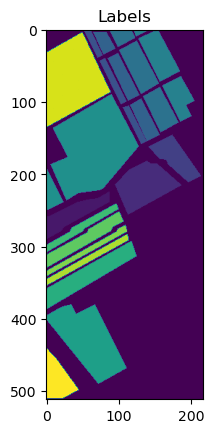

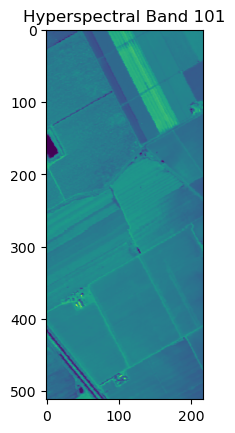

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53729 samples
	shape (53729, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(320, 5, 5, 204)
(80, 5, 5, 204)
(53729, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1579, PSNR: 7.1867


	 Training Batch [200/677], Loss: 0.0891, PSNR: 9.6732


	 Training Batch [400/677], Loss: 0.0442, PSNR: 12.7169


	 Training Batch [600/677], Loss: 0.0257, PSNR: 14.9324


Epoch [1/50] Training Loss: 0.0672, PSNR: 11.5870
	[Val]   Batch [1/170] Loss: 0.0216, PSNR: 15.7459
	[Val]   Batch [10/170] Loss: 0.0212, PSNR: 15.9093
	[Val]   Batch [20/170] Loss: 0.0214, PSNR: 15.8051
	[Val]   Batch [30/170] Loss: 0.0221, PSNR: 15.6054
	[Val]   Batch [40/170] Loss: 0.0222, PSNR: 15.6810
	[Val]   Batch [50/170] Loss: 0.0210, PSNR: 15.8895


	[Val]   Batch [60/170] Loss: 0.0220, PSNR: 15.7628
	[Val]   Batch [70/170] Loss: 0.0215, PSNR: 15.8537
	[Val]   Batch [80/170] Loss: 0.0219, PSNR: 15.6663
	[Val]   Batch [90/170] Loss: 0.0212, PSNR: 15.9115


	[Val]   Batch [100/170] Loss: 0.0212, PSNR: 15.8345
	[Val]   Batch [110/170] Loss: 0.0213, PSNR: 15.8150
	[Val]   Batch [120/170] Loss: 0.0201, PSNR: 14.1254
	[Val]   Batch [130/170] Loss: 0.0212, PSNR: 15.9148
	[Val]   Batch [140/170] Loss: 0.0208, PSNR: 15.9627


	[Val]   Batch [150/170] Loss: 0.0222, PSNR: 15.7127
	[Val]   Batch [160/170] Loss: 0.0219, PSNR: 15.7466
	[Val]   Batch [170/170] Loss: 0.0227, PSNR: 15.0263
Epoch [1/50] Validation Loss: 0.0216, PSNR: 15.7338

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0210, PSNR: 15.4891


	 Training Batch [200/677], Loss: 0.0161, PSNR: 16.9589


	 Training Batch [400/677], Loss: 0.0104, PSNR: 18.8968


	 Training Batch [600/677], Loss: 0.0102, PSNR: 18.9906


Epoch [2/50] Training Loss: 0.0133, PSNR: 17.9974
	[Val]   Batch [1/170] Loss: 0.0087, PSNR: 19.6699
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 20.0094
	[Val]   Batch [20/170] Loss: 0.0084, PSNR: 19.8714
	[Val]   Batch [30/170] Loss: 0.0090, PSNR: 19.4803
	[Val]   Batch [40/170] Loss: 0.0093, PSNR: 19.4697


	[Val]   Batch [50/170] Loss: 0.0081, PSNR: 20.0400
	[Val]   Batch [60/170] Loss: 0.0090, PSNR: 19.6185
	[Val]   Batch [70/170] Loss: 0.0088, PSNR: 19.7263
	[Val]   Batch [80/170] Loss: 0.0089, PSNR: 19.5761
	[Val]   Batch [90/170] Loss: 0.0085, PSNR: 19.8745


	[Val]   Batch [100/170] Loss: 0.0085, PSNR: 19.7906
	[Val]   Batch [110/170] Loss: 0.0084, PSNR: 19.8518
	[Val]   Batch [120/170] Loss: 0.0073, PSNR: 18.4965
	[Val]   Batch [130/170] Loss: 0.0085, PSNR: 19.8785
	[Val]   Batch [140/170] Loss: 0.0079, PSNR: 20.1585


	[Val]   Batch [150/170] Loss: 0.0093, PSNR: 19.5076
	[Val]   Batch [160/170] Loss: 0.0090, PSNR: 19.6104
	[Val]   Batch [170/170] Loss: 0.0093, PSNR: 18.9145
Epoch [2/50] Validation Loss: 0.0086, PSNR: 19.7128

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0089, PSNR: 19.6724


	 Training Batch [200/677], Loss: 0.0067, PSNR: 20.7704


	 Training Batch [400/677], Loss: 0.0062, PSNR: 21.1386


	 Training Batch [600/677], Loss: 0.0043, PSNR: 22.7450


Epoch [3/50] Training Loss: 0.0066, PSNR: 20.9588
	[Val]   Batch [1/170] Loss: 0.0047, PSNR: 22.3501
	[Val]   Batch [10/170] Loss: 0.0045, PSNR: 22.6741
	[Val]   Batch [20/170] Loss: 0.0045, PSNR: 22.5435
	[Val]   Batch [30/170] Loss: 0.0049, PSNR: 22.1062
	[Val]   Batch [40/170] Loss: 0.0050, PSNR: 22.1491


	[Val]   Batch [50/170] Loss: 0.0044, PSNR: 22.6534
	[Val]   Batch [60/170] Loss: 0.0049, PSNR: 22.2680
	[Val]   Batch [70/170] Loss: 0.0047, PSNR: 22.4190
	[Val]   Batch [80/170] Loss: 0.0048, PSNR: 22.2534
	[Val]   Batch [90/170] Loss: 0.0046, PSNR: 22.5165


	[Val]   Batch [100/170] Loss: 0.0047, PSNR: 22.3827
	[Val]   Batch [110/170] Loss: 0.0046, PSNR: 22.5089
	[Val]   Batch [120/170] Loss: 0.0040, PSNR: 21.0921
	[Val]   Batch [130/170] Loss: 0.0047, PSNR: 22.4735
	[Val]   Batch [140/170] Loss: 0.0043, PSNR: 22.8440


	[Val]   Batch [150/170] Loss: 0.0050, PSNR: 22.1692
	[Val]   Batch [160/170] Loss: 0.0049, PSNR: 22.2821
	[Val]   Batch [170/170] Loss: 0.0050, PSNR: 21.6031
Epoch [3/50] Validation Loss: 0.0047, PSNR: 22.3714

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0047, PSNR: 22.3350


	 Training Batch [200/677], Loss: 0.0040, PSNR: 23.1445


	 Training Batch [400/677], Loss: 0.0035, PSNR: 23.6219


	 Training Batch [600/677], Loss: 0.0032, PSNR: 24.0394


Epoch [4/50] Training Loss: 0.0037, PSNR: 23.4783
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.7648
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0157
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 24.8798
	[Val]   Batch [30/170] Loss: 0.0029, PSNR: 24.4279
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.6584


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9054
	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.6529
	[Val]   Batch [70/170] Loss: 0.0027, PSNR: 24.9007
	[Val]   Batch [80/170] Loss: 0.0027, PSNR: 24.6911
	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.8846


	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6138
	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9212
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.1889
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.6948
	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.1787


	[Val]   Batch [150/170] Loss: 0.0029, PSNR: 24.5898
	[Val]   Batch [160/170] Loss: 0.0028, PSNR: 24.7146
	[Val]   Batch [170/170] Loss: 0.0029, PSNR: 24.0115
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.7301

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0026, PSNR: 24.5459


	 Training Batch [200/677], Loss: 0.0026, PSNR: 25.0363


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.4563


	 Training Batch [600/677], Loss: 0.0023, PSNR: 25.4805


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3495
	[Val]   Batch [1/170] Loss: 0.0018, PSNR: 26.4720
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.7265
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.5494
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 26.0399
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.4093


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.5523
	[Val]   Batch [60/170] Loss: 0.0019, PSNR: 26.3127
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.6385
	[Val]   Batch [80/170] Loss: 0.0018, PSNR: 26.4012
	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.5647


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.1863
	[Val]   Batch [110/170] Loss: 0.0017, PSNR: 26.7214
	[Val]   Batch [120/170] Loss: 0.0017, PSNR: 24.7793
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.2607
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.9007


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.2527
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.4153
	[Val]   Batch [170/170] Loss: 0.0019, PSNR: 25.6952
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.4057

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0020, PSNR: 26.1482


	 Training Batch [200/677], Loss: 0.0020, PSNR: 26.2585


	 Training Batch [400/677], Loss: 0.0017, PSNR: 26.8908


	 Training Batch [600/677], Loss: 0.0014, PSNR: 27.6422


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.6199
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6962
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.9185
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.7025
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.1615
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6924


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6810
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4747
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.9200
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.5906
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7897


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3008
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 28.0185
	[Val]   Batch [120/170] Loss: 0.0013, PSNR: 25.8735
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3675
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.1078


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4048
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6210
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.8643
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5813

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.2880


	 Training Batch [200/677], Loss: 0.0016, PSNR: 27.1005


	 Training Batch [400/677], Loss: 0.0012, PSNR: 28.2404


	 Training Batch [600/677], Loss: 0.0012, PSNR: 28.4001


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5737
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6215
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.8413
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6152
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 28.0156
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6540


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5408
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.3601
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.9047
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.4988
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7200


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.1474
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0192
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7359
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.2107
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0567


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.2583
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.5500
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.7814
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.4784

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.7676


	 Training Batch [200/677], Loss: 0.0013, PSNR: 28.0371


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.8875


	 Training Batch [600/677], Loss: 0.0014, PSNR: 27.7882


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3720
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.7358
	[Val]   Batch [10/170] Loss: 0.0008, PSNR: 29.9975
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.7632
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 29.0771
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.8373
	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.5457


	[Val]   Batch [60/170] Loss: 0.0009, PSNR: 29.4650
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 30.0743
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.6868
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.8557
	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.1978


	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.2172
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.6800
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.2783
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.1950
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.3750


	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.6651
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 29.0095
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.5969

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.7329


	 Training Batch [200/677], Loss: 0.0012, PSNR: 28.0187


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.5184


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.2224


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0812
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.5048
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.7718
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.4972
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 29.8379
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.6208


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.2457
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.2440
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.8529
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.5017
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.6741


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.9888
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.0197
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3784
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0930
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.9642


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.1604
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.4199
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.8360
Epoch [9/50] Validation Loss: 0.0007, PSNR: 30.3645

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.4899


	 Training Batch [200/677], Loss: 0.0010, PSNR: 29.0367


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.9742


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.8669


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.7101
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.0912
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.3346
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.0203
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.4170
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.1923


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.8195
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.8118
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.4546
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.0542
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.3356


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.6390
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.6288
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.9896
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.7143
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.5507


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7130
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.9765
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.3598
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.9291

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.2311


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.6940


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4646


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.6840


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.3254
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.0867
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.4043
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.0000
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.4595
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.2248


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 31.7458
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 31.8419
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.3890
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.1495
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.3690


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.6568
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.6765
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.8941
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.7556
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.5649


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 31.7847
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.9240
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.6116
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.9523

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.9905


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.3643


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4313


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5866


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.8454
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.7326
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.0717
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.6518
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.1515
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.8523


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.3260
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.5298
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.0359
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.8310
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.0965


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.4319
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.3462
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.5943
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.5349
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.2235


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.5096
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.5656
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.4242
Epoch [12/50] Validation Loss: 0.0004, PSNR: 32.6302

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.1315


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5052


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4524


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.6129


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.3189
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.2101
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.5736
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.1193
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.7264
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.3112


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.7932
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.0829
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.4255
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.3808
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.6399


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.0065
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.7964
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.0674
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.1344
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.6968


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.1093
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.0015
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 33.0490
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.1400

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 29.8293


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.6757


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9543


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.4970


Epoch [14/50] Training Loss: 0.0005, PSNR: 31.7308
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.7804
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.1592
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.6388
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.3038
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.8639


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.3692
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.6692
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.9671
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.9350
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.2771


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.6145
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.3785
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.7011
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.7124


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3071
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.6355
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.5077
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.6811
Epoch [14/50] Validation Loss: 0.0003, PSNR: 33.7006

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.5396


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.3879


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1722


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1539


Epoch [15/50] Training Loss: 0.0005, PSNR: 32.0843
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.4665
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.8560
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.2549
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.0445
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.6168


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.9270
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.4198
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.6252
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.7133
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 35.0268


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.3515
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 35.0683
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.2707
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.4753
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.9522


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.4422
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.1526
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.5898
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.3985

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.6567


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.1467


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.5050


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.0165


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3953
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.7061
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.1170
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.5013
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.3669
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.8341
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.1768


	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.7145
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.8519
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.9850
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.3261


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.7172
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.3123
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.5936
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.8404
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.1951


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.7656
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.4083
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.9355
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.6795

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.4210


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.1696


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.5799


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.2077


Epoch [17/50] Training Loss: 0.0004, PSNR: 32.6571
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.8534
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.2842
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6344
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.5485
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.9364


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4038
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.9025
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.9759
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.1449
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5440


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9242
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.4516
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.8394
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0475
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.3871


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9118
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5250
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.0230
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8283

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.5069


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4904


	 Training Batch [400/677], Loss: 0.0003, PSNR: 33.8825


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.6515


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.9728
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.5608
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.9482
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.2457
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.2498
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.6543


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.8895
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.6334
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.6396
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.8724
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.2202


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.6338
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.1543
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.3632
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.7812
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.9746


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.7092
	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.1723
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.0451
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.5185

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.9478


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.7370


	 Training Batch [400/677], Loss: 0.0003, PSNR: 33.7608


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.1584


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.1634
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.8443
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 36.2183
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.4912
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.5114
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.9190
	[Val]   Batch [50/170] Loss: 0.0002, PSNR: 35.1338


	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.9000
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.9371
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 36.1774
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.5554
	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.8924


	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.4776
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.6067
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 36.0841
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.2393
	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.9526


	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.4295
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.2997
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.7892
Early stopping triggered at epoch 19. No improvement for 3 epochs.


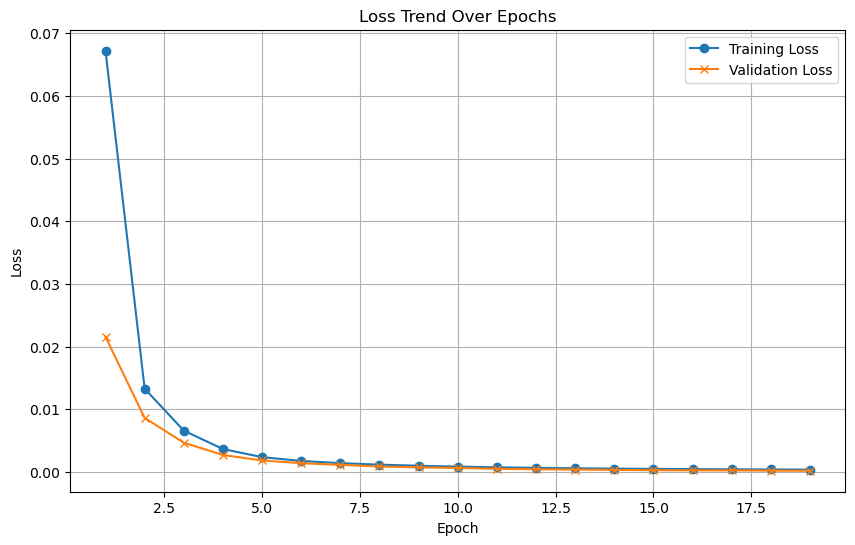

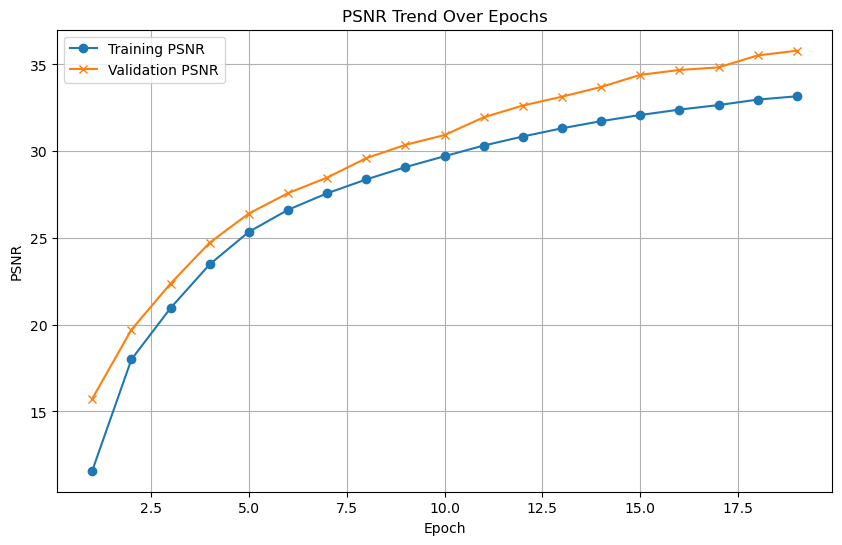

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/210 for test dataset.


    Processed batch 101/210 for test dataset.


    Processed batch 201/210 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8132
    Validation Batch [1/1], Loss: 2.7805
Validation Loss: 2.7805, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7805. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7507
    Validation Batch [1/1], Loss: 2.7804
Validation Loss: 2.7804, Validation Accuracy: 6.25%
Validation loss improved from 2.7805 to 2.7804. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7124
    Validation Batch [1/1], Loss: 2.7804
Validation Loss: 2.7804, Validation Accuracy: 6.25%
Validation loss improved from 2.7804 to 2.7804. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6789
    Validation Batch [1/1], Loss: 2.7804
Validation Loss: 2.7804, Validation Accuracy: 6.25%
Validation loss improved from 2.7804 to 2.7804. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.7807
Validation Loss: 2.7807, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.4590
    Validation Batch [1/1], Loss: 2.7807
Validation Loss: 2.7807, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.4642
    Validation Batch [1/1], Loss: 2.7806
Validation Loss: 2.7806, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.4637
    Validation Batch [1/1], Loss: 2.7804
Validation Loss: 2.7804, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4483
    Validation Batch [1/1], Loss: 2.7799
Validation Loss: 2.7799, Va

    Validation Batch [1/1], Loss: 2.7160
Validation Loss: 2.7160, Validation Accuracy: 17.50%
Validation loss improved from 2.7249 to 2.7160. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.2697
    Validation Batch [1/1], Loss: 2.7052
Validation Loss: 2.7052, Validation Accuracy: 18.75%
Validation loss improved from 2.7160 to 2.7052. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.2669
    Validation Batch [1/1], Loss: 2.6937
Validation Loss: 2.6937, Validation Accuracy: 18.75%
Validation loss improved from 2.7052 to 2.6937. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.2759
    Validation Batch [1/1], Loss: 2.6813
Validation Loss: 2.6813, Validation Accuracy: 18.75%
Validation loss improved from 2.6937 to 2.6813. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.2529
    Vali

Epoch [61/1000] completed, Average Training Loss: 2.0910
    Validation Batch [1/1], Loss: 2.3776
Validation Loss: 2.3776, Validation Accuracy: 36.25%
Validation loss improved from 2.3788 to 2.3776. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.0888
    Validation Batch [1/1], Loss: 2.3829
Validation Loss: 2.3829, Validation Accuracy: 37.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.0824
    Validation Batch [1/1], Loss: 2.3606
Validation Loss: 2.3606, Validation Accuracy: 42.50%
Validation loss improved from 2.3776 to 2.3606. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.0707
    Validation Batch [1/1], Loss: 2.3331
Validation Loss: 2.3331, Validation Accuracy: 47.50%
Validation loss improved from 2.3606 to 2.3331. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] complet

Epoch [74/1000] completed, Average Training Loss: 1.9966
    Validation Batch [1/1], Loss: 2.1330
Validation Loss: 2.1330, Validation Accuracy: 65.00%
Validation loss improved from 2.1630 to 2.1330. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.9882
    Validation Batch [1/1], Loss: 2.1355
Validation Loss: 2.1355, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.9689
    Validation Batch [1/1], Loss: 2.1540
Validation Loss: 2.1540, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.9679
    Validation Batch [1/1], Loss: 2.1425
Validation Loss: 2.1425, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.9

    Validation Batch [1/1], Loss: 1.7985
Validation Loss: 1.7985, Validation Accuracy: 70.00%
Validation loss improved from 1.8089 to 1.7985. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.7876
    Validation Batch [1/1], Loss: 1.8053
Validation Loss: 1.8053, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.7802
    Validation Batch [1/1], Loss: 1.7887
Validation Loss: 1.7887, Validation Accuracy: 75.00%
Validation loss improved from 1.7985 to 1.7887. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.7626
    Validation Batch [1/1], Loss: 1.7703
Validation Loss: 1.7703, Validation Accuracy: 77.50%
Validation loss improved from 1.7887 to 1.7703. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.7378
    Validation Batch 

Epoch [119/1000] completed, Average Training Loss: 1.6099
    Validation Batch [1/1], Loss: 1.5630
Validation Loss: 1.5630, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.5999
    Validation Batch [1/1], Loss: 1.5378
Validation Loss: 1.5378, Validation Accuracy: 82.50%
Validation loss improved from 1.5479 to 1.5378. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.5606
    Validation Batch [1/1], Loss: 1.5551
Validation Loss: 1.5551, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.5911
    Validation Batch [1/1], Loss: 1.5388
Validation Loss: 1.5388, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.3634
Validation Loss: 1.3634, Validation Accuracy: 86.25%
Validation loss improved from 1.3804 to 1.3634. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.4067
    Validation Batch [1/1], Loss: 1.3497
Validation Loss: 1.3497, Validation Accuracy: 87.50%
Validation loss improved from 1.3634 to 1.3497. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.3810
    Validation Batch [1/1], Loss: 1.3610
Validation Loss: 1.3610, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.3716
    Validation Batch [1/1], Loss: 1.3188
Validation Loss: 1.3188, Validation Accuracy: 87.50%
Validation loss improved from 1.3497 to 1.3188. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.3851
    Validation 

Epoch [162/1000] completed, Average Training Loss: 1.2530
    Validation Batch [1/1], Loss: 1.1664
Validation Loss: 1.1664, Validation Accuracy: 88.75%
Validation loss improved from 1.1865 to 1.1664. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.2227
    Validation Batch [1/1], Loss: 1.1522
Validation Loss: 1.1522, Validation Accuracy: 88.75%
Validation loss improved from 1.1664 to 1.1522. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.2392
    Validation Batch [1/1], Loss: 1.1492
Validation Loss: 1.1492, Validation Accuracy: 90.00%
Validation loss improved from 1.1522 to 1.1492. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.2172
    Validation Batch [1/1], Loss: 1.1359
Validation Loss: 1.1359, Validation Accuracy: 90.00%
Validation loss improved from 1.1492 to 1.1359. Saving model...

LOG: Epoch [166/1000] - Training


Epoch [185/1000] completed, Average Training Loss: 1.0765
    Validation Batch [1/1], Loss: 0.9964
Validation Loss: 0.9964, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 1.0206
    Validation Batch [1/1], Loss: 0.9812
Validation Loss: 0.9812, Validation Accuracy: 92.50%
Validation loss improved from 0.9861 to 0.9812. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.0521
    Validation Batch [1/1], Loss: 0.9578
Validation Loss: 0.9578, Validation Accuracy: 92.50%
Validation loss improved from 0.9812 to 0.9578. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.0399
    Validation Batch [1/1], Loss: 0.9717
Validation Loss: 0.9717, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Av

Epoch [208/1000] completed, Average Training Loss: 0.8472
    Validation Batch [1/1], Loss: 0.7891
Validation Loss: 0.7891, Validation Accuracy: 92.50%
Validation loss improved from 0.8104 to 0.7891. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.8773
    Validation Batch [1/1], Loss: 0.7880
Validation Loss: 0.7880, Validation Accuracy: 95.00%
Validation loss improved from 0.7891 to 0.7880. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.8705
    Validation Batch [1/1], Loss: 0.7788
Validation Loss: 0.7788, Validation Accuracy: 92.50%
Validation loss improved from 0.7880 to 0.7788. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.8454
    Validation Batch [1/1], Loss: 0.7873
Validation Loss: 0.7873, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000

Epoch [231/1000] completed, Average Training Loss: 0.7243
    Validation Batch [1/1], Loss: 0.6373
Validation Loss: 0.6373, Validation Accuracy: 95.00%
Validation loss improved from 0.6382 to 0.6373. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7091
    Validation Batch [1/1], Loss: 0.6286
Validation Loss: 0.6286, Validation Accuracy: 96.25%
Validation loss improved from 0.6373 to 0.6286. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.6810
    Validation Batch [1/1], Loss: 0.6177
Validation Loss: 0.6177, Validation Accuracy: 93.75%
Validation loss improved from 0.6286 to 0.6177. Saving model...

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.6823
    Validation Batch [1/1], Loss: 0.6070
Validation Loss: 0.6070, Validation Accuracy: 93.75%
Validation loss improved from 0.6177 to 0.6070. Saving model...

LOG: Epoch [235/1000] - Training


Epoch [253/1000] completed, Average Training Loss: 0.5651
    Validation Batch [1/1], Loss: 0.5051
Validation Loss: 0.5051, Validation Accuracy: 96.25%
Validation loss improved from 0.5120 to 0.5051. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.5590
    Validation Batch [1/1], Loss: 0.5060
Validation Loss: 0.5060, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.5333
    Validation Batch [1/1], Loss: 0.4984
Validation Loss: 0.4984, Validation Accuracy: 96.25%
Validation loss improved from 0.5051 to 0.4984. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.5661
    Validation Batch [1/1], Loss: 0.4897
Validation Loss: 0.4897, Validation Accuracy: 96.25%
Validation loss improved from 0.4984 to 0.4897. Saving model...

LOG: Epoch [257/1000] - Training
Epoch [257/1000

Epoch [276/1000] completed, Average Training Loss: 0.4648
    Validation Batch [1/1], Loss: 0.4056
Validation Loss: 0.4056, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.4457
    Validation Batch [1/1], Loss: 0.3909
Validation Loss: 0.3909, Validation Accuracy: 96.25%
Validation loss improved from 0.4025 to 0.3909. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.4379
    Validation Batch [1/1], Loss: 0.4088
Validation Loss: 0.4088, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4278
    Validation Batch [1/1], Loss: 0.3861
Validation Loss: 0.3861, Validation Accuracy: 95.00%
Validation loss improved from 0.3909 to 0.3861. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Av

    Validation Batch [1/1], Loss: 0.3140
Validation Loss: 0.3140, Validation Accuracy: 96.25%
Validation loss improved from 0.3368 to 0.3140. Saving model...

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.3653
    Validation Batch [1/1], Loss: 0.3232
Validation Loss: 0.3232, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.3794
    Validation Batch [1/1], Loss: 0.3205
Validation Loss: 0.3205, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.3482
    Validation Batch [1/1], Loss: 0.3179
Validation Loss: 0.3179, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3652
    Validation Batch [1/1], Loss: 0.3080
Vali

    Validation Batch [1/1], Loss: 0.2717
Validation Loss: 0.2717, Validation Accuracy: 96.25%
Validation loss improved from 0.2735 to 0.2717. Saving model...

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.2955
    Validation Batch [1/1], Loss: 0.2747
Validation Loss: 0.2747, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.2826
    Validation Batch [1/1], Loss: 0.3115
Validation Loss: 0.3115, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.2856
    Validation Batch [1/1], Loss: 0.2902
Validation Loss: 0.2902, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.2815
    Validation Batch [1/1], Loss: 0.2881
Vali

Epoch [345/1000] completed, Average Training Loss: 0.2382
    Validation Batch [1/1], Loss: 0.2344
Validation Loss: 0.2344, Validation Accuracy: 97.50%
Validation loss improved from 0.2368 to 0.2344. Saving model...

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2601
    Validation Batch [1/1], Loss: 0.2388
Validation Loss: 0.2388, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.2331
    Validation Batch [1/1], Loss: 0.2456
Validation Loss: 0.2456, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.2275
    Validation Batch [1/1], Loss: 0.2375
Validation Loss: 0.2375, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training 

Epoch [367/1000] completed, Average Training Loss: 0.2067
    Validation Batch [1/1], Loss: 0.2119
Validation Loss: 0.2119, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2074
    Validation Batch [1/1], Loss: 0.2193
Validation Loss: 0.2193, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.2110
    Validation Batch [1/1], Loss: 0.2347
Validation Loss: 0.2347, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.2087
    Validation Batch [1/1], Loss: 0.2261
Validation Loss: 0.2261, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2016
  

Epoch [391/1000] completed, Average Training Loss: 0.1621
    Validation Batch [1/1], Loss: 0.1840
Validation Loss: 0.1840, Validation Accuracy: 96.25%
Validation loss improved from 0.1866 to 0.1840. Saving model...

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.1581
    Validation Batch [1/1], Loss: 0.1801
Validation Loss: 0.1801, Validation Accuracy: 96.25%
Validation loss improved from 0.1840 to 0.1801. Saving model...

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.1822
    Validation Batch [1/1], Loss: 0.1812
Validation Loss: 0.1812, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.1830
    Validation Batch [1/1], Loss: 0.1790
Validation Loss: 0.1790, Validation Accuracy: 96.25%
Validation loss improved from 0.1801 to 0.1790. Saving model...

LOG: Epoch [395/1000] - Training
Epoch [395/1000

Epoch [413/1000] completed, Average Training Loss: 0.1614
    Validation Batch [1/1], Loss: 0.1692
Validation Loss: 0.1692, Validation Accuracy: 96.25%
Validation loss improved from 0.1733 to 0.1692. Saving model...

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1324
    Validation Batch [1/1], Loss: 0.1692
Validation Loss: 0.1692, Validation Accuracy: 97.50%
Validation loss improved from 0.1692 to 0.1692. Saving model...

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1513
    Validation Batch [1/1], Loss: 0.1700
Validation Loss: 0.1700, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1411
    Validation Batch [1/1], Loss: 0.1731
Validation Loss: 0.1731, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Av

    Validation Batch [1/1], Loss: 0.1600
Validation Loss: 0.1600, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1169
    Validation Batch [1/1], Loss: 0.1652
Validation Loss: 0.1652, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.1262
    Validation Batch [1/1], Loss: 0.1626
Validation Loss: 0.1626, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.1270
    Validation Batch [1/1], Loss: 0.1702
Validation Loss: 0.1702, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1366
    Validation Batch [1/1], Loss: 0.1692
Validation Loss: 0.

Epoch [459/1000] completed, Average Training Loss: 0.1297
    Validation Batch [1/1], Loss: 0.1621
Validation Loss: 0.1621, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1091
    Validation Batch [1/1], Loss: 0.1539
Validation Loss: 0.1539, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1236
    Validation Batch [1/1], Loss: 0.1621
Validation Loss: 0.1621, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1133
    Validation Batch [1/1], Loss: 0.1653
Validation Loss: 0.1653, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1144
  

Epoch [483/1000] completed, Average Training Loss: 0.1073
    Validation Batch [1/1], Loss: 0.1433
Validation Loss: 0.1433, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.1015
    Validation Batch [1/1], Loss: 0.1431
Validation Loss: 0.1431, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1011
    Validation Batch [1/1], Loss: 0.1483
Validation Loss: 0.1483, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0951
    Validation Batch [1/1], Loss: 0.1478
Validation Loss: 0.1478, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.0935
  

Epoch [505/1000] completed, Average Training Loss: 0.0816
    Validation Batch [1/1], Loss: 0.1381
Validation Loss: 0.1381, Validation Accuracy: 96.25%
Validation loss improved from 0.1387 to 0.1381. Saving model...

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0840
    Validation Batch [1/1], Loss: 0.1356
Validation Loss: 0.1356, Validation Accuracy: 96.25%
Validation loss improved from 0.1381 to 0.1356. Saving model...

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.0797
    Validation Batch [1/1], Loss: 0.1352
Validation Loss: 0.1352, Validation Accuracy: 96.25%
Validation loss improved from 0.1356 to 0.1352. Saving model...

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0890
    Validation Batch [1/1], Loss: 0.1369
Validation Loss: 0.1369, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000

Epoch [528/1000] completed, Average Training Loss: 0.0790
    Validation Batch [1/1], Loss: 0.1364
Validation Loss: 0.1364, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.1342
Validation Loss: 0.1342, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.1375
Validation Loss: 0.1375, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0750
    Validation Batch [1/1], Loss: 0.1400
Validation Loss: 0.1400, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0728
  

    Validation Batch [1/1], Loss: 0.1334
Validation Loss: 0.1334, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0870
    Validation Batch [1/1], Loss: 0.1413
Validation Loss: 0.1413, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.1519
Validation Loss: 0.1519, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0715
    Validation Batch [1/1], Loss: 0.1469
Validation Loss: 0.1469, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0836
    Validation Batch [1/1], Loss: 0.1393
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.1281
Validation Loss: 0.1281, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0616
    Validation Batch [1/1], Loss: 0.1291
Validation Loss: 0.1291, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 0.1283
Validation Loss: 0.1283, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0745
    Validation Batch [1/1], Loss: 0.1292
Validation Loss: 0.1292, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0620
    Validation Batch [1/1], Loss: 0.1286
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.1276
Validation Loss: 0.1276, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0553
    Validation Batch [1/1], Loss: 0.1291
Validation Loss: 0.1291, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0719
    Validation Batch [1/1], Loss: 0.1262
Validation Loss: 0.1262, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0596
    Validation Batch [1/1], Loss: 0.1286
Validation Loss: 0.1286, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0635
    Validation Batch [1/1], Loss: 0.1359
Validation Loss: 0.

Epoch [618/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.1401
Validation Loss: 0.1401, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0634
    Validation Batch [1/1], Loss: 0.1318
Validation Loss: 0.1318, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0487
    Validation Batch [1/1], Loss: 0.1279
Validation Loss: 0.1279, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0451
    Validation Batch [1/1], Loss: 0.1322
Validation Loss: 0.1322, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.055

Epoch [639/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.1319
Validation Loss: 0.1319, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.1307
Validation Loss: 0.1307, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.1306
Validation Loss: 0.1306, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0611
    Validation Batch [1/1], Loss: 0.1328
Validation Loss: 0.1328, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.053

Epoch [661/1000] completed, Average Training Loss: 0.0503
    Validation Batch [1/1], Loss: 0.1319
Validation Loss: 0.1319, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0433
    Validation Batch [1/1], Loss: 0.1276
Validation Loss: 0.1276, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0501
    Validation Batch [1/1], Loss: 0.1397
Validation Loss: 0.1397, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0545
    Validation Batch [1/1], Loss: 0.1520
Validation Loss: 0.1520, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.038

Epoch [685/1000] completed, Average Training Loss: 0.0451
    Validation Batch [1/1], Loss: 0.1307
Validation Loss: 0.1307, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0412
    Validation Batch [1/1], Loss: 0.1359
Validation Loss: 0.1359, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.1394
Validation Loss: 0.1394, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.0480
    Validation Batch [1/1], Loss: 0.1368
Validation Loss: 0.1368, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0397
  

Epoch [708/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.1204
Validation Loss: 0.1204, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [709/1000] - Training
Epoch [709/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.1279
Validation Loss: 0.1279, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [710/1000] - Training
Epoch [710/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.1230
Validation Loss: 0.1230, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.2012
Validation Loss: 0.2012, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.054

    Validation Batch [1/1], Loss: 0.4584
Validation Loss: 0.4584, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [731/1000] - Training
Epoch [731/1000] completed, Average Training Loss: 0.0783
    Validation Batch [1/1], Loss: 0.2707
Validation Loss: 0.2707, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.2219
Validation Loss: 0.2219, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [733/1000] - Training
Epoch [733/1000] completed, Average Training Loss: 0.0771
    Validation Batch [1/1], Loss: 0.2592
Validation Loss: 0.2592, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [734/1000] - Training
Epoch [734/1000] completed, Average Training Loss: 0.0824
    Validation Batch [1/1], Loss: 0.2754
Validation Loss

    Validation Batch [1/1], Loss: 0.1627
Validation Loss: 0.1627, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [754/1000] - Training
Epoch [754/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.1511
Validation Loss: 0.1511, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [755/1000] - Training
Epoch [755/1000] completed, Average Training Loss: 0.0456
    Validation Batch [1/1], Loss: 0.1364
Validation Loss: 0.1364, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [756/1000] - Training
Epoch [756/1000] completed, Average Training Loss: 0.0440
    Validation Batch [1/1], Loss: 0.1563
Validation Loss: 0.1563, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [757/1000] - Training
Epoch [757/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.1547
Validation Loss

Epoch [776/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1], Loss: 0.1264
Validation Loss: 0.1264, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [777/1000] - Training
Epoch [777/1000] completed, Average Training Loss: 0.0303
    Validation Batch [1/1], Loss: 0.1328
Validation Loss: 0.1328, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [778/1000] - Training
Epoch [778/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.1348
Validation Loss: 0.1348, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [779/1000] - Training
Epoch [779/1000] completed, Average Training Loss: 0.0410
    Validation Batch [1/1], Loss: 0.1295
Validation Loss: 0.1295, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [780/1000] - Training
Epoch [780/1000] completed, Average Training Loss: 0.0368

Epoch [799/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.1158
Validation Loss: 0.1158, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [800/1000] - Training
Epoch [800/1000] completed, Average Training Loss: 0.0310
    Validation Batch [1/1], Loss: 0.1142
Validation Loss: 0.1142, Validation Accuracy: 96.25%
Validation loss improved from 0.1155 to 0.1142. Saving model...

LOG: Epoch [801/1000] - Training
Epoch [801/1000] completed, Average Training Loss: 0.0305
    Validation Batch [1/1], Loss: 0.1139
Validation Loss: 0.1139, Validation Accuracy: 96.25%
Validation loss improved from 0.1142 to 0.1139. Saving model...

LOG: Epoch [802/1000] - Training
Epoch [802/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.1136
Validation Loss: 0.1136, Validation Accuracy: 96.25%
Validation loss improved from 0.1139 to 0.1136. Saving model...

LOG: Epoch [803/1000] - Training
Epoch [803/100

Epoch [822/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.1197
Validation Loss: 0.1197, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [823/1000] - Training
Epoch [823/1000] completed, Average Training Loss: 0.0270
    Validation Batch [1/1], Loss: 0.1261
Validation Loss: 0.1261, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [824/1000] - Training
Epoch [824/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.1253
Validation Loss: 0.1253, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [825/1000] - Training
Epoch [825/1000] completed, Average Training Loss: 0.0323
    Validation Batch [1/1], Loss: 0.1229
Validation Loss: 0.1229, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0270
  

Epoch [845/1000] completed, Average Training Loss: 0.0252
    Validation Batch [1/1], Loss: 0.1185
Validation Loss: 0.1185, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [846/1000] - Training
Epoch [846/1000] completed, Average Training Loss: 0.0271
    Validation Batch [1/1], Loss: 0.1219
Validation Loss: 0.1219, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [847/1000] - Training
Epoch [847/1000] completed, Average Training Loss: 0.0286
    Validation Batch [1/1], Loss: 0.1228
Validation Loss: 0.1228, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [848/1000] - Training
Epoch [848/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.1208
Validation Loss: 0.1208, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [849/1000] - Training
Epoch [849/1000] completed, Average Training Loss: 0.028

Epoch [868/1000] completed, Average Training Loss: 0.0279
    Validation Batch [1/1], Loss: 0.1569
Validation Loss: 0.1569, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [869/1000] - Training
Epoch [869/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.1493
Validation Loss: 0.1493, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [870/1000] - Training
Epoch [870/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.1224
Validation Loss: 0.1224, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [871/1000] - Training
Epoch [871/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.1245
Validation Loss: 0.1245, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [872/1000] - Training
Epoch [872/1000] completed, Average Training Loss: 0.027

Epoch [891/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.1210
Validation Loss: 0.1210, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [892/1000] - Training
Epoch [892/1000] completed, Average Training Loss: 0.0270
    Validation Batch [1/1], Loss: 0.1273
Validation Loss: 0.1273, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [893/1000] - Training
Epoch [893/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.1341
Validation Loss: 0.1341, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [894/1000] - Training
Epoch [894/1000] completed, Average Training Loss: 0.0264
    Validation Batch [1/1], Loss: 0.1311
Validation Loss: 0.1311, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [895/1000] - Training
Epoch [895/1000] completed, Average Training Loss: 0.025

Epoch [915/1000] completed, Average Training Loss: 0.0226
    Validation Batch [1/1], Loss: 0.1209
Validation Loss: 0.1209, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [916/1000] - Training
Epoch [916/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.1218
Validation Loss: 0.1218, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [917/1000] - Training
Epoch [917/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.1230
Validation Loss: 0.1230, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [918/1000] - Training
Epoch [918/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.1225
Validation Loss: 0.1225, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [919/1000] - Training
Epoch [919/1000] completed, Average Training Loss: 0.024

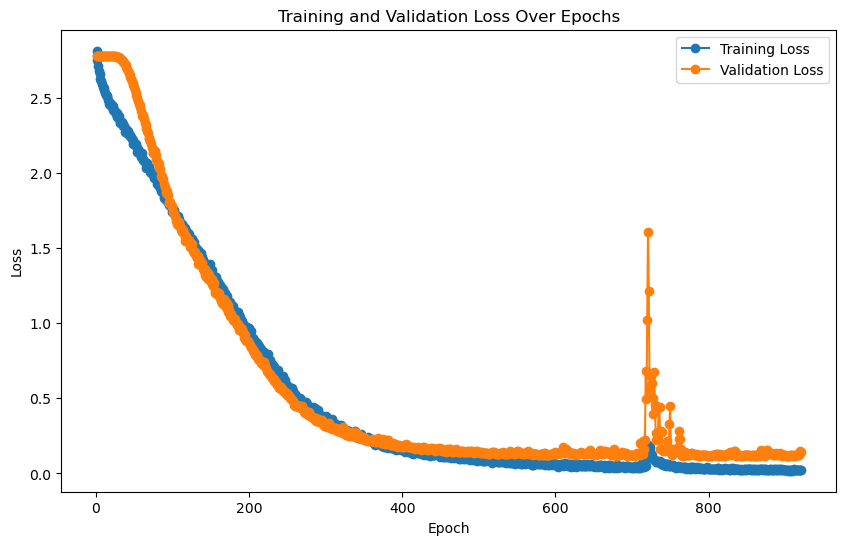

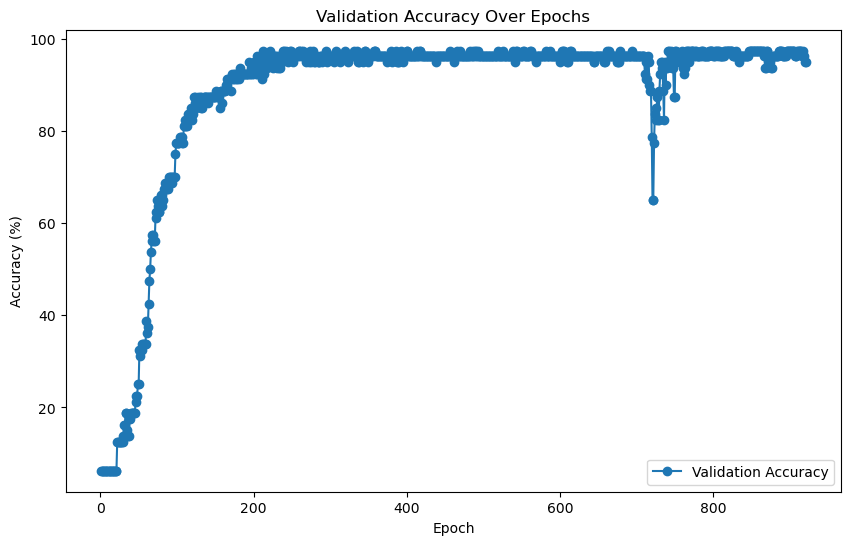


Evaluating on the test set...
    Test Batch [1/210], Loss: 0.3599



Final Test Loss: 0.4653, Test Accuracy: 88.52%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.


  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.
  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.


  Processed batch 80/210 for test dataset.
  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.


  Processed batch 120/210 for test dataset.
  Processed batch 130/210 for test dataset.
  Processed batch 140/210 for test dataset.
  Processed batch 150/210 for test dataset.
  Processed batch 160/210 for test dataset.


  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.
  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53729, 64), Test labels shape: (53729,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.67      0.40      0.50         5
           8       1.00      1.


Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97      1984
           1       1.00      0.93      0.96      3701
           2       0.96      0.91      0.93      1951
           3       1.00      0.98      0.99      1369
           4       0.87      0.99      0.92      2653
           5       1.00      0.98      0.99      3934
           6       0.96      0.96      0.96      3554
           7       0.72      0.60      0.65     11246
           8       0.99      0.96      0.97      6178
           9       0.85      0.77      0.81      3253
          10       0.66      0.90      0.77      1043
          11       0.80      0.97      0.88      1902
          12       0.78      0.98      0.87       891
          13       0.83      0.86      0.85      1045
          14       0.51      0.58      0.54      7243
          15       0.78      0.91      0.84      1782

    accuracy                           0.82     53

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53729, 64)
Test labels shape: (53729,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7759  |  Val Loss: 2.6463
Validation loss improved from inf to 2.6463.
[Epoch 2/1000] Train Loss: 2.6064  |  Val Loss: 2.5503
Validation loss improved from 2.6463 to 2.5503.
[Epoch 3/1000] Train Loss: 2.5090  |  Val Loss: 2.4366
Validation loss improved from 2.5503 to 2.4366.
[Epoch 4/1000] Train Loss: 2.3938  |  Val Loss: 2.3185
Validation loss improved from 2.4366 to 2.3185.
[Epoch 5/1000] Train Loss: 2.2796  |  Val Loss: 2.2059
Validation loss improved from 2.3185 to 2.2059.
[Epoch 6/1000] Train Loss: 2.1658  |  Val Loss: 2.0974
Validation loss improved from 2.2059 to 2.0974.
[Epoch 7/1000] Train Loss: 2.0455  |  Val Loss: 1.9664
Validation loss improved from 2.0974 to 1.9664.
[Epoch 8/1000] Train Loss: 1.9166  |  Val Loss: 1.8337
Validation loss improved from 1.9664 to 1.8337.
[Epoch 9/1000] Train Loss: 1.7832  |  Val Loss: 1.7030
Validation loss improved from 1.8337 to 1.7030.
[Epoch 10/1000] Train Loss: 1.6454  |  Val Loss: 1.5655
Validation loss impr

[Epoch 11/1000] Train Loss: 1.5193  |  Val Loss: 1.4419
Validation loss improved from 1.5655 to 1.4419.
[Epoch 12/1000] Train Loss: 1.4081  |  Val Loss: 1.3285
Validation loss improved from 1.4419 to 1.3285.
[Epoch 13/1000] Train Loss: 1.2943  |  Val Loss: 1.2334
Validation loss improved from 1.3285 to 1.2334.
[Epoch 14/1000] Train Loss: 1.2069  |  Val Loss: 1.1270
Validation loss improved from 1.2334 to 1.1270.
[Epoch 15/1000] Train Loss: 1.1178  |  Val Loss: 1.0493
Validation loss improved from 1.1270 to 1.0493.
[Epoch 16/1000] Train Loss: 1.0429  |  Val Loss: 0.9795
Validation loss improved from 1.0493 to 0.9795.
[Epoch 17/1000] Train Loss: 0.9782  |  Val Loss: 0.9104
Validation loss improved from 0.9795 to 0.9104.
[Epoch 18/1000] Train Loss: 0.9255  |  Val Loss: 0.8593
Validation loss improved from 0.9104 to 0.8593.
[Epoch 19/1000] Train Loss: 0.8729  |  Val Loss: 0.8117
Validation loss improved from 0.8593 to 0.8117.


[Epoch 20/1000] Train Loss: 0.8251  |  Val Loss: 0.7560
Validation loss improved from 0.8117 to 0.7560.
[Epoch 21/1000] Train Loss: 0.7987  |  Val Loss: 0.7221
Validation loss improved from 0.7560 to 0.7221.
[Epoch 22/1000] Train Loss: 0.7524  |  Val Loss: 0.6784
Validation loss improved from 0.7221 to 0.6784.
[Epoch 23/1000] Train Loss: 0.7237  |  Val Loss: 0.6473
Validation loss improved from 0.6784 to 0.6473.
[Epoch 24/1000] Train Loss: 0.6900  |  Val Loss: 0.6203
Validation loss improved from 0.6473 to 0.6203.
[Epoch 25/1000] Train Loss: 0.6613  |  Val Loss: 0.5892
Validation loss improved from 0.6203 to 0.5892.
[Epoch 26/1000] Train Loss: 0.6406  |  Val Loss: 0.5714
Validation loss improved from 0.5892 to 0.5714.
[Epoch 27/1000] Train Loss: 0.6169  |  Val Loss: 0.5416
Validation loss improved from 0.5714 to 0.5416.
[Epoch 28/1000] Train Loss: 0.6002  |  Val Loss: 0.5204
Validation loss improved from 0.5416 to 0.5204.
[Epoch 29/1000] Train Loss: 0.5787  |  Val Loss: 0.4978
Validati

[Epoch 30/1000] Train Loss: 0.5570  |  Val Loss: 0.4882
Validation loss improved from 0.4978 to 0.4882.
[Epoch 31/1000] Train Loss: 0.5477  |  Val Loss: 0.4645
Validation loss improved from 0.4882 to 0.4645.
[Epoch 32/1000] Train Loss: 0.5252  |  Val Loss: 0.4513
Validation loss improved from 0.4645 to 0.4513.
[Epoch 33/1000] Train Loss: 0.5164  |  Val Loss: 0.4369
Validation loss improved from 0.4513 to 0.4369.
[Epoch 34/1000] Train Loss: 0.4938  |  Val Loss: 0.4239
Validation loss improved from 0.4369 to 0.4239.
[Epoch 35/1000] Train Loss: 0.4798  |  Val Loss: 0.4175
Validation loss improved from 0.4239 to 0.4175.
[Epoch 36/1000] Train Loss: 0.4833  |  Val Loss: 0.4097
Validation loss improved from 0.4175 to 0.4097.


[Epoch 37/1000] Train Loss: 0.4642  |  Val Loss: 0.3894
Validation loss improved from 0.4097 to 0.3894.
[Epoch 38/1000] Train Loss: 0.4468  |  Val Loss: 0.3802
Validation loss improved from 0.3894 to 0.3802.
[Epoch 39/1000] Train Loss: 0.4415  |  Val Loss: 0.3583
Validation loss improved from 0.3802 to 0.3583.
[Epoch 40/1000] Train Loss: 0.4320  |  Val Loss: 0.3831
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.4177  |  Val Loss: 0.3482
Validation loss improved from 0.3583 to 0.3482.
[Epoch 42/1000] Train Loss: 0.4096  |  Val Loss: 0.3546
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.4077  |  Val Loss: 0.3361
Validation loss improved from 0.3482 to 0.3361.
[Epoch 44/1000] Train Loss: 0.3931  |  Val Loss: 0.3252
Validation loss improved from 0.3361 to 0.3252.
[Epoch 45/1000] Train Loss: 0.3951  |  Val Loss: 0.3199
Validation loss improved from 0.3252 to 0.3199.
[Epoch 46/1000] Train Loss: 0.3800  |  Val Loss: 0.3

[Epoch 47/1000] Train Loss: 0.3685  |  Val Loss: 0.3110
Validation loss improved from 0.3199 to 0.3110.
[Epoch 48/1000] Train Loss: 0.3652  |  Val Loss: 0.3028
Validation loss improved from 0.3110 to 0.3028.
[Epoch 49/1000] Train Loss: 0.3521  |  Val Loss: 0.3155
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 0.3504  |  Val Loss: 0.2957
Validation loss improved from 0.3028 to 0.2957.
[Epoch 51/1000] Train Loss: 0.3536  |  Val Loss: 0.3001
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 52/1000] Train Loss: 0.3563  |  Val Loss: 0.2912
Validation loss improved from 0.2957 to 0.2912.
[Epoch 53/1000] Train Loss: 0.3551  |  Val Loss: 0.2974
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 54/1000] Train Loss: 0.3333  |  Val Loss: 0.2841
Validation loss improved from 0.2912 to 0.2841.
[Epoch 55/1000] Train Loss: 0.3259  |  Val Loss: 0.2777
Validation loss improved from 0.2841 to 0.2777.
[Epoch 56/1000] Train Loss: 0.3188  |  Val Loss: 0.2869
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.3308  |  Val Loss: 0.2764
Validation loss improved from 0.2777 to 0.2764.
[Epoch 58/1000] Train Loss: 0.3315  |  Val Loss: 0.2757
Validation loss improved from 0.2764 to 0.2757.
[Epoch 59/1000] Train Loss: 0.3093  |  Val Loss: 0.2775
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.3096  |  Val Loss: 0.2537
Validation loss improved from 0.2757 to 0.2537.
[Epoch 61/1000] Train Loss: 0.2971  |  Val Loss: 0.2533
Validation loss improved from 0.2537 to 0.2533.
[Epoch 62/1000] Train Loss: 0.2871  |  Val Loss: 0.2521
Validation loss improved from 0.2533 to 0.2521.
[Epoch 63/1000] Train Loss: 0.2887  |  Val Loss: 0.2

[Epoch 64/1000] Train Loss: 0.2784  |  Val Loss: 0.2609
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.2759  |  Val Loss: 0.2478
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 0.2696  |  Val Loss: 0.2358
Validation loss improved from 0.2453 to 0.2358.
[Epoch 67/1000] Train Loss: 0.2747  |  Val Loss: 0.2382
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.2655  |  Val Loss: 0.2446
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 0.2735  |  Val Loss: 0.2312
Validation loss improved from 0.2358 to 0.2312.
[Epoch 70/1000] Train Loss: 0.2583  |  Val Loss: 0.2290
Validation loss improved from 0.2312 to 0.2290.
[Epoch 71/1000] Train Loss: 0.2591  |  Val Loss: 0.2573
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 0.2697  |  Val Loss: 0.2338
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 73/1000] Train Loss: 

[Epoch 74/1000] Train Loss: 0.2627  |  Val Loss: 0.2514
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 75/1000] Train Loss: 0.2726  |  Val Loss: 0.2227
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 76/1000] Train Loss: 0.2790  |  Val Loss: 0.2467
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 77/1000] Train Loss: 0.2548  |  Val Loss: 0.2420
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 78/1000] Train Loss: 0.2492  |  Val Loss: 0.2124
Validation loss improved from 0.2169 to 0.2124.
[Epoch 79/1000] Train Loss: 0.2386  |  Val Loss: 0.2366
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 80/1000] Train Loss: 0.2347  |  Val Loss: 0.2157
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 81/1000] Train Loss: 0.2363  |  Val Loss: 0.2044
Validation loss improved from 0.2124 to 0.2044.
[Epoch 82/1000] Train Loss: 0.2347  |  Val Loss: 0.2299
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 83/1000] Train Loss: 0.2350  |  Val Loss: 0.2279
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 0.2315  |  Val Loss: 0.1976
Validation loss improved from 0.2044 to 0.1976.
[Epoch 85/1000] Train Loss: 0.2285  |  Val Loss: 0.2249
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.2255  |  Val Loss: 0.2131
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 0.2235  |  Val Loss: 0.2051
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 0.2183  |  Val Loss: 0.2173
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 89/1000] Train Loss: 0.2110  |  Val Loss: 0.2126
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 90/1000] Train Loss: 0.2100  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 91/1000] Train Loss: 0.2113  |  Val Loss: 0.2019
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 92/1000] Train Loss: 0.2062  |  Val Loss: 0.2195
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 93/1000] Train Loss: 0.2059  |  Val Loss: 0.1955
Validation loss improved from 0.1976 to 0.1955.
[Epoch 94/1000] Train Loss: 0.2061  |  Val Loss: 0.2075
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 95/1000] Train Loss: 0.2172  |  Val Loss: 0.2123
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 96/1000] Train Loss: 0.2019  |  Val Loss: 0.1994
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 97/1000] Train Loss: 0.2009  |  Val Loss: 0.2257
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 98/1000] Train Loss: 0.1998  |  Val Loss: 0.1938
Validation loss improved from 0.1955 to 0.1938.
[Epoch 99/1000] Train Loss: 0.1987  |  Val Loss: 0.1940
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 100/1000] Train

[Epoch 104/1000] Train Loss: 0.1841  |  Val Loss: 0.2029
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 105/1000] Train Loss: 0.1883  |  Val Loss: 0.1954
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 106/1000] Train Loss: 0.1857  |  Val Loss: 0.1928
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 107/1000] Train Loss: 0.1824  |  Val Loss: 0.2096
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 108/1000] Train Loss: 0.1835  |  Val Loss: 0.1883
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 109/1000] Train Loss: 0.1876  |  Val Loss: 0.1931
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 110/1000] Train Loss: 0.1903  |  Val Loss: 0.2008
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 111/1000] Train Loss: 0.1816  |  Val Loss: 0.1867
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 112/1000] Train Loss: 0.1767  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 113/1000] Train Loss: 0.1860  |  Val Loss: 0.2113
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 114/1000] Train Loss: 0.1747  |  Val Loss: 0.1827
Validation loss improved from 0.1828 to 0.1827.
[Epoch 115/1000] Train Loss: 0.1758  |  Val Loss: 0.2200
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 0.1790  |  Val Loss: 0.1799
Validation loss improved from 0.1827 to 0.1799.
[Epoch 117/1000] Train Loss: 0.1768  |  Val Loss: 0.1997
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118

[Epoch 122/1000] Train Loss: 0.1631  |  Val Loss: 0.1874
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 123/1000] Train Loss: 0.1720  |  Val Loss: 0.1891
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 124/1000] Train Loss: 0.1702  |  Val Loss: 0.2169
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 125/1000] Train Loss: 0.1592  |  Val Loss: 0.1919
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 126/1000] Train Loss: 0.1667  |  Val Loss: 0.1901
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 127/1000] Train Loss: 0.1621  |  Val Loss: 0.1946
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 128/1000] Train Loss: 0.1567  |  Val Loss: 0.1804
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 129/1000] Train Loss: 0.1652  |  Val Loss: 0.2133
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 130/1000] Train Loss: 0.1594  |  Val Loss: 0.1826
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 131/1000] Train Loss: 0.1692  |  Val Loss: 0.1841
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 132/1000] Train Loss: 0.1626  |  Val Loss: 0.1931
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 133/1000] Train Loss: 0.1553  |  Val Loss: 0.1789
Validation loss improved from 0.1799 to 0.1789.
[Epoch 134/1000] Train Loss: 0.1529  |  Val Loss: 0.1994
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 0.1559  |  Val Loss: 0.1936
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 136/1000] Train Loss: 0.1609  |  Val Loss: 0.1768
Validation loss improved from 0.1789 to 0.1768.
[Epoch 1

[Epoch 141/1000] Train Loss: 0.1482  |  Val Loss: 0.1821
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 142/1000] Train Loss: 0.1669  |  Val Loss: 0.1834
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 143/1000] Train Loss: 0.1590  |  Val Loss: 0.1797
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 144/1000] Train Loss: 0.1512  |  Val Loss: 0.1806
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 145/1000] Train Loss: 0.1466  |  Val Loss: 0.2009
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 146/1000] Train Loss: 0.1453  |  Val Loss: 0.1663
Validation loss improved from 0.1755 to 0.1663.


[Epoch 147/1000] Train Loss: 0.1435  |  Val Loss: 0.2253
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 148/1000] Train Loss: 0.1479  |  Val Loss: 0.1836
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 149/1000] Train Loss: 0.1532  |  Val Loss: 0.1631
Validation loss improved from 0.1663 to 0.1631.
[Epoch 150/1000] Train Loss: 0.1387  |  Val Loss: 0.2121
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 151/1000] Train Loss: 0.1393  |  Val Loss: 0.1695
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/1000] Train Loss: 0.1390  |  Val Loss: 0.1710
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 153/1000] Train Loss: 0.1403  |  Val Loss: 0.2023
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 154/1000] Train Loss: 0.1367  |  Val Loss: 0.1701
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 155/1000] Train Loss: 0.1413  |  Val Loss: 0.1836
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 158/1000] Train Loss: 0.1449  |  Val Loss: 0.1954
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 159/1000] Train Loss: 0.1374  |  Val Loss: 0.1846
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 160/1000] Train Loss: 0.1443  |  Val Loss: 0.2004
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 161/1000] Train Loss: 0.1706  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 162/1000] Train Loss: 0.1372  |  Val Loss: 0.2123
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 163/1000] Train Loss: 0.1299  |  Val Loss: 0.1633
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 164/1000] Train Loss: 0.1342  |  Val Loss: 0.1908
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 165/1000] Train Loss: 0.1306  |  Val Loss: 0.1981
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 166/1000] Train Loss: 0.1259  |  Val Loss: 0.1658
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 167/1000] Train Loss: 0.1240  |  Val Loss: 0.2006
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 168/1000] Train Loss: 0.1345  |  Val Loss: 0.1740
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 169/1000] Train Loss: 0.1266  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 170/1000] Train Loss: 0.1139  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 171/1000] Train Loss: 0.1246  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 172/1000] Train Loss: 0.1237  |  Val Loss: 0.1709
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 173/1000] Train Loss: 0.1259  |  Val Loss: 0.1962
!! Validation loss did NOT improve !! Patience:

[Epoch 178/1000] Train Loss: 0.1339  |  Val Loss: 0.2102
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 179/1000] Train Loss: 0.1314  |  Val Loss: 0.1835
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 180/1000] Train Loss: 0.1223  |  Val Loss: 0.1835
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 181/1000] Train Loss: 0.1210  |  Val Loss: 0.1777
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 182/1000] Train Loss: 0.1142  |  Val Loss: 0.1612
Validation loss improved from 0.1617 to 0.1612.
[Epoch 183/1000] Train Loss: 0.1138  |  Val Loss: 0.1880
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 184/1000] Train Loss: 0.1172  |  Val Loss: 0.1728
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 185/1000] Train Loss: 0.1117  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 186/1000] Train Loss: 0.1063  |  Val Loss: 0.1880
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 187/1000] Train Loss: 0.1088  |  Val Loss: 0.1893
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 188/1000] Train Loss: 0.1145  |  Val Loss: 0.1766
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 189/1000] Train Loss: 0.1189  |  Val Loss: 0.1799
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 190/1000] Train Loss: 0.1311  |  Val Loss: 0.1706
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 191/1000] Train Loss: 0.1233  |  Val Loss: 0.1663
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 192/1000] Train Loss: 0.1423  |  Val Loss: 0.2113
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 193/1000] Train Loss: 0.1294  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 198/1000] Train Loss: 0.1024  |  Val Loss: 0.1623
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 199/1000] Train Loss: 0.1055  |  Val Loss: 0.1911
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 200/1000] Train Loss: 0.1156  |  Val Loss: 0.1822
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 201/1000] Train Loss: 0.1075  |  Val Loss: 0.1699
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 202/1000] Train Loss: 0.1053  |  Val Loss: 0.1789
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 203/1000] Train Loss: 0.1042  |  Val Loss: 0.1922
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 204/1000] Train Loss: 0.1021  |  Val Loss: 0.1606
Validation loss improved from 0.1612 to 0.1606.


[Epoch 205/1000] Train Loss: 0.1041  |  Val Loss: 0.2019
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 206/1000] Train Loss: 0.1046  |  Val Loss: 0.1716
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 207/1000] Train Loss: 0.1039  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 208/1000] Train Loss: 0.0976  |  Val Loss: 0.1748
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 209/1000] Train Loss: 0.0924  |  Val Loss: 0.1916
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 210/1000] Train Loss: 0.0927  |  Val Loss: 0.1729
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 211/1000] Train Loss: 0.1001  |  Val Loss: 0.1967
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 212/1000] Train Loss: 0.0881  |  Val Loss: 0.1605
Validation loss improved from 0.1606 to 0.1605.
[Epoch 213/1000] Train Loss: 0.0910  |  Val Loss: 0.2176
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 216/1000] Train Loss: 0.1109  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 217/1000] Train Loss: 0.0979  |  Val Loss: 0.2054
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 218/1000] Train Loss: 0.0983  |  Val Loss: 0.1543
Validation loss improved from 0.1605 to 0.1543.
[Epoch 219/1000] Train Loss: 0.1015  |  Val Loss: 0.1873
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 220/1000] Train Loss: 0.0926  |  Val Loss: 0.1735
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 221/1000] Train Loss: 0.0970  |  Val Loss: 0.1822
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 222/1000] Train Loss: 0.0966  |  Val Loss: 0.1736
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 223/1000] Train Loss: 0.0937  |  Val Loss: 0.1553
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 224/1000] Train Loss: 0.0922  |  Val Loss: 0.2063
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 225/1000] Train Loss: 0.0844  |  Val Loss: 0.1677
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 226/1000] Train Loss: 0.0832  |  Val Loss: 0.1732
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 227/1000] Train Loss: 0.0814  |  Val Loss: 0.1742
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 228/1000] Train Loss: 0.0823  |  Val Loss: 0.1957
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 229/1000] Train Loss: 0.0870  |  Val Loss: 0.1611
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 230/1000] Train Loss: 0.0930  |  Val Loss: 0.1632
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 231/1000] Train Loss: 0.1058  |  Val Loss: 0.1905
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 234/1000] Train Loss: 0.0870  |  Val Loss: 0.1723
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 235/1000] Train Loss: 0.0828  |  Val Loss: 0.1637
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 236/1000] Train Loss: 0.0842  |  Val Loss: 0.1991
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 237/1000] Train Loss: 0.0746  |  Val Loss: 0.1566
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 238/1000] Train Loss: 0.0811  |  Val Loss: 0.1775
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 239/1000] Train Loss: 0.0820  |  Val Loss: 0.2091
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 240/1000] Train Loss: 0.0768  |  Val Loss: 0.1554
!! Validation loss did NOT improve !! Patience: 22/100


[Epoch 241/1000] Train Loss: 0.0934  |  Val Loss: 0.2056
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 242/1000] Train Loss: 0.0871  |  Val Loss: 0.1802
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 243/1000] Train Loss: 0.0809  |  Val Loss: 0.1811
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 244/1000] Train Loss: 0.0865  |  Val Loss: 0.1921
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 245/1000] Train Loss: 0.0831  |  Val Loss: 0.1710
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 246/1000] Train Loss: 0.0802  |  Val Loss: 0.1907
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 247/1000] Train Loss: 0.0713  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 248/1000] Train Loss: 0.0740  |  Val Loss: 0.1871
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 249/1000] Train Loss: 0.0739  |  Val Loss: 0.1654
!! Validation loss did NOT improve !! Patience:

[Epoch 252/1000] Train Loss: 0.0697  |  Val Loss: 0.1796
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 253/1000] Train Loss: 0.0686  |  Val Loss: 0.1709
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 254/1000] Train Loss: 0.0682  |  Val Loss: 0.1981
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 255/1000] Train Loss: 0.0704  |  Val Loss: 0.1744
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 256/1000] Train Loss: 0.0672  |  Val Loss: 0.1917
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 257/1000] Train Loss: 0.0671  |  Val Loss: 0.1588
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 258/1000] Train Loss: 0.0697  |  Val Loss: 0.1902
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 259/1000] Train Loss: 0.0667  |  Val Loss: 0.1777
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 260/1000] Train Loss: 0.0759  |  Val Loss: 0.1965
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 261/1000] Train Loss: 0.0713  |  Val Loss: 0.1816
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 262/1000] Train Loss: 0.0712  |  Val Loss: 0.1696
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 263/1000] Train Loss: 0.0752  |  Val Loss: 0.1740
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 264/1000] Train Loss: 0.0661  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 265/1000] Train Loss: 0.0674  |  Val Loss: 0.1974
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 266/1000] Train Loss: 0.0712  |  Val Loss: 0.1686
!! Validation loss did NOT improve !! Patience:

[Epoch 271/1000] Train Loss: 0.0588  |  Val Loss: 0.1798
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 272/1000] Train Loss: 0.0708  |  Val Loss: 0.1772
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 273/1000] Train Loss: 0.0573  |  Val Loss: 0.1696
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 274/1000] Train Loss: 0.0613  |  Val Loss: 0.1975
!! Validation loss did NOT improve !! Patience: 56/100


[Epoch 275/1000] Train Loss: 0.0687  |  Val Loss: 0.1777
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 276/1000] Train Loss: 0.0846  |  Val Loss: 0.1998
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 277/1000] Train Loss: 0.0834  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 278/1000] Train Loss: 0.0623  |  Val Loss: 0.1601
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 279/1000] Train Loss: 0.0687  |  Val Loss: 0.2006
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 280/1000] Train Loss: 0.0646  |  Val Loss: 0.1842
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 281/1000] Train Loss: 0.0616  |  Val Loss: 0.1787
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 282/1000] Train Loss: 0.0647  |  Val Loss: 0.2180
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 283/1000] Train Loss: 0.0651  |  Val Loss: 0.1579
!! Validation loss did NOT improve !! Patience:

[Epoch 291/1000] Train Loss: 0.0531  |  Val Loss: 0.1876
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 292/1000] Train Loss: 0.0505  |  Val Loss: 0.1869
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 293/1000] Train Loss: 0.0508  |  Val Loss: 0.1798
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 294/1000] Train Loss: 0.0538  |  Val Loss: 0.1936
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 295/1000] Train Loss: 0.0595  |  Val Loss: 0.1602
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 296/1000] Train Loss: 0.0537  |  Val Loss: 0.2056
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 297/1000] Train Loss: 0.0521  |  Val Loss: 0.1667
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 298/1000] Train Loss: 0.0535  |  Val Loss: 0.2004
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 299/1000] Train Loss: 0.0655  |  Val Loss: 0.1745
!! Validation loss did NOT improve !! Patience:

[Epoch 310/1000] Train Loss: 0.0560  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 311/1000] Train Loss: 0.0531  |  Val Loss: 0.1966
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 312/1000] Train Loss: 0.0601  |  Val Loss: 0.2375
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 313/1000] Train Loss: 0.0713  |  Val Loss: 0.1742
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 314/1000] Train Loss: 0.0792  |  Val Loss: 0.2371
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 315/1000] Train Loss: 0.0602  |  Val Loss: 0.1816
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 316/1000] Train Loss: 0.0533  |  Val Loss: 0.1894
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 317/1000] Train Loss: 0.0499  |  Val Loss: 0.1974
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 318/1000] Train Loss: 0.0481  |  Val Loss: 0.1999
!! Validation loss did NOT improve !! Patience:

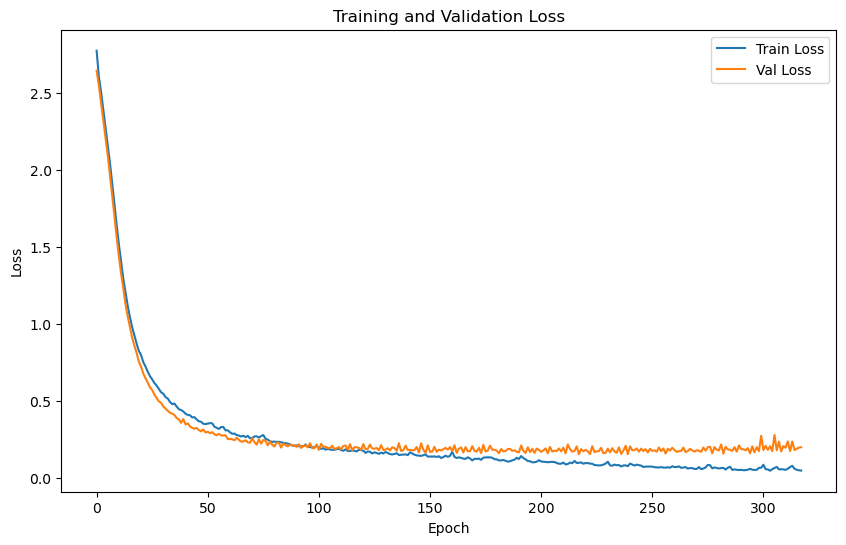

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.8392 | Test Accuracy: 84.93%


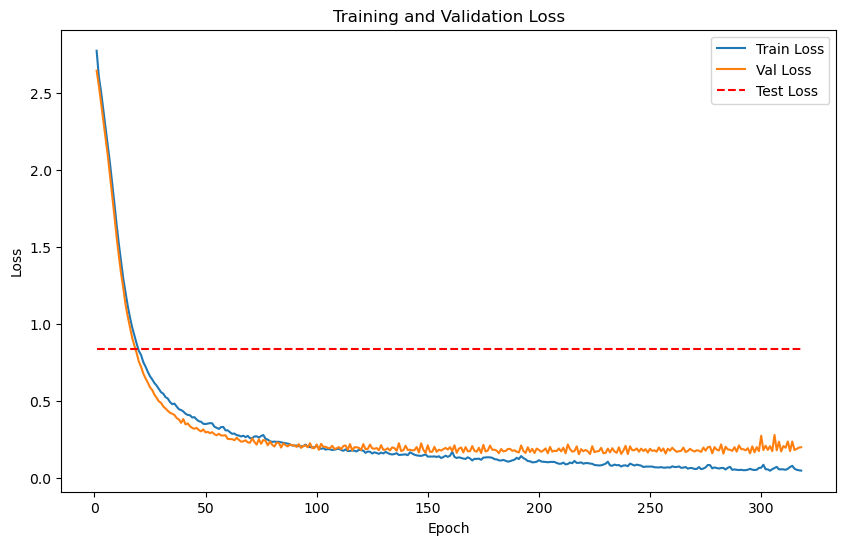

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.0684
Epoch [1/2000], Avg Train Loss: 8.0684
Epoch [1/2000], Avg Val Loss: 2.9780
Validation loss improved from inf to 2.9780. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1181
Epoch [2/2000], Avg Train Loss: 8.1181
Epoch [2/2000], Avg Val Loss: 2.9653
Validation loss improved from 2.9780 to 2.9653. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1663
Epoch [3/2000], Avg Train Loss: 8.1663
Epoch [3/2000], Avg Val Loss: 2.9533
Validation loss improved from 2.9653 to 2.9533. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.8431
Epoch [4/2000], Avg Train Loss: 7.8431


Epoch [4/2000], Avg Val Loss: 2.9418
Validation loss improved from 2.9533 to 2.9418. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.8545
Epoch [5/2000], Avg Train Loss: 7.8545
Epoch [5/2000], Avg Val Loss: 2.9306
Validation loss improved from 2.9418 to 2.9306. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.7838
Epoch [6/2000], Avg Train Loss: 7.7838
Epoch [6/2000], Avg Val Loss: 2.9197
Validation loss improved from 2.9306 to 2.9197. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.7398
Epoch [7/2000], Avg Train Loss: 7.7398
Epoch [7/2000], Avg Val Loss: 2.9092
Validation loss improved from 2.9197 to 2.9092. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.5495
Epoch [8/2000], Avg Train Loss: 7.5495
Epoch [8/2000], Avg Val Loss: 2.8992
Validation loss improved from 2.9092 to 2.8992. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.7176

Epoch [19/2000], Avg Val Loss: 2.8126
Validation loss improved from 2.8189 to 2.8126. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.9696
Epoch [20/2000], Avg Train Loss: 6.9696
Epoch [20/2000], Avg Val Loss: 2.8066
Validation loss improved from 2.8126 to 2.8066. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.9134
Epoch [21/2000], Avg Train Loss: 6.9134
Epoch [21/2000], Avg Val Loss: 2.8009
Validation loss improved from 2.8066 to 2.8009. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.8406
Epoch [22/2000], Avg Train Loss: 6.8406
Epoch [22/2000], Avg Val Loss: 2.7954
Validation loss improved from 2.8009 to 2.7954. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.7020
Epoch [23/2000], Avg Train Loss: 6.7020
Epoch [23/2000], Avg Val Loss: 2.7902
Validation loss improved from 2.7954 to 2.7902. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.0977
Epoch [37/2000], Avg Train Loss: 6.0977
Epoch [37/2000], Avg Val Loss: 2.7396
Validation loss improved from 2.7420 to 2.7396. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.0900
Epoch [38/2000], Avg Train Loss: 6.0900
Epoch [38/2000], Avg Val Loss: 2.7374
Validation loss improved from 2.7396 to 2.7374. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.0888
Epoch [39/2000], Avg Train Loss: 6.0888
Epoch [39/2000], Avg Val Loss: 2.7352
Validation loss improved from 2.7374 to 2.7352. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.0789
Epoch [40/2000], Avg Train Loss: 6.0789
Epoch [40/2000], Avg Val Loss: 2.7332
Validation loss improved from 2.7352 to 2.7332. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.0925
Epoch [41/2000], Avg Train Loss: 6.0925
Epoch [41/2000], Avg Val Loss: 2.7312
Validation loss improved from 2.7332 to 2.

    Batch [1/1], Train Loss: 5.6710
Epoch [54/2000], Avg Train Loss: 5.6710
Epoch [54/2000], Avg Val Loss: 2.7157
Validation loss improved from 2.7164 to 2.7157. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.6480
Epoch [55/2000], Avg Train Loss: 5.6480
Epoch [55/2000], Avg Val Loss: 2.7150
Validation loss improved from 2.7157 to 2.7150. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.6302
Epoch [56/2000], Avg Train Loss: 5.6302
Epoch [56/2000], Avg Val Loss: 2.7144
Validation loss improved from 2.7150 to 2.7144. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.6410
Epoch [57/2000], Avg Train Loss: 5.6410
Epoch [57/2000], Avg Val Loss: 2.7139
Validation loss improved from 2.7144 to 2.7139. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.6314
Epoch [58/2000], Avg Train Loss: 5.6314
Epoch [58/2000], Avg Val Loss: 2.7135
Validation loss improved from 2.7139 to 2.

Epoch [70/2000], Avg Val Loss: 2.7103
Validation loss improved from 2.7105 to 2.7103. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.3201
Epoch [71/2000], Avg Train Loss: 5.3201
Epoch [71/2000], Avg Val Loss: 2.7101
Validation loss improved from 2.7103 to 2.7101. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.3584
Epoch [72/2000], Avg Train Loss: 5.3584
Epoch [72/2000], Avg Val Loss: 2.7099
Validation loss improved from 2.7101 to 2.7099. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.2648
Epoch [73/2000], Avg Train Loss: 5.2648
Epoch [73/2000], Avg Val Loss: 2.7097
Validation loss improved from 2.7099 to 2.7097. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.3055
Epoch [74/2000], Avg Train Loss: 5.3055
Epoch [74/2000], Avg Val Loss: 2.7095
Validation loss improved from 2.7097 to 2.7095. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Trai

Epoch [88/2000], Avg Val Loss: 2.7062
Validation loss improved from 2.7065 to 2.7062. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.1445
Epoch [89/2000], Avg Train Loss: 5.1445
Epoch [89/2000], Avg Val Loss: 2.7059
Validation loss improved from 2.7062 to 2.7059. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.1113
Epoch [90/2000], Avg Train Loss: 5.1113
Epoch [90/2000], Avg Val Loss: 2.7056
Validation loss improved from 2.7059 to 2.7056. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.1227
Epoch [91/2000], Avg Train Loss: 5.1227
Epoch [91/2000], Avg Val Loss: 2.7053
Validation loss improved from 2.7056 to 2.7053. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.1393
Epoch [92/2000], Avg Train Loss: 5.1393
Epoch [92/2000], Avg Val Loss: 2.7050
Validation loss improved from 2.7053 to 2.7050. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.9988
Epoch [107/2000], Avg Train Loss: 4.9988
Epoch [107/2000], Avg Val Loss: 2.6989
Validation loss improved from 2.6994 to 2.6989. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.9743
Epoch [108/2000], Avg Train Loss: 4.9743
Epoch [108/2000], Avg Val Loss: 2.6983
Validation loss improved from 2.6989 to 2.6983. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.9556
Epoch [109/2000], Avg Train Loss: 4.9556
Epoch [109/2000], Avg Val Loss: 2.6977
Validation loss improved from 2.6983 to 2.6977. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.0095
Epoch [110/2000], Avg Train Loss: 5.0095
Epoch [110/2000], Avg Val Loss: 2.6972
Validation loss improved from 2.6977 to 2.6972. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.9213
Epoch [111/2000], Avg Train Loss: 4.9213
Epoch [111/2000], Avg Val Loss: 2.6967
Validation loss improved fro

Epoch [125/2000], Avg Val Loss: 2.6860
Validation loss improved from 2.6869 to 2.6860. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.8916
Epoch [126/2000], Avg Train Loss: 4.8916
Epoch [126/2000], Avg Val Loss: 2.6850
Validation loss improved from 2.6860 to 2.6850. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.8145
Epoch [127/2000], Avg Train Loss: 4.8145
Epoch [127/2000], Avg Val Loss: 2.6840
Validation loss improved from 2.6850 to 2.6840. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.8033
Epoch [128/2000], Avg Train Loss: 4.8033
Epoch [128/2000], Avg Val Loss: 2.6830
Validation loss improved from 2.6840 to 2.6830. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.8080
Epoch [129/2000], Avg Train Loss: 4.8080
Epoch [129/2000], Avg Val Loss: 2.6820
Validation loss improved from 2.6830 to 2.6820. Saving model...

LOG: Epoch [130/2000] - Training
    Bat

Epoch [144/2000], Avg Val Loss: 2.6647
Validation loss improved from 2.6659 to 2.6647. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.8145
Epoch [145/2000], Avg Train Loss: 4.8145
Epoch [145/2000], Avg Val Loss: 2.6635
Validation loss improved from 2.6647 to 2.6635. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.7824
Epoch [146/2000], Avg Train Loss: 4.7824
Epoch [146/2000], Avg Val Loss: 2.6623
Validation loss improved from 2.6635 to 2.6623. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.7873
Epoch [147/2000], Avg Train Loss: 4.7873
Epoch [147/2000], Avg Val Loss: 2.6611
Validation loss improved from 2.6623 to 2.6611. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.7660
Epoch [148/2000], Avg Train Loss: 4.7660
Epoch [148/2000], Avg Val Loss: 2.6599
Validation loss improved from 2.6611 to 2.6599. Saving model...

LOG: Epoch [149/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6929
Epoch [158/2000], Avg Train Loss: 4.6929
Epoch [158/2000], Avg Val Loss: 2.6476
Validation loss improved from 2.6489 to 2.6476. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.7106
Epoch [159/2000], Avg Train Loss: 4.7106
Epoch [159/2000], Avg Val Loss: 2.6463
Validation loss improved from 2.6476 to 2.6463. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.7297
Epoch [160/2000], Avg Train Loss: 4.7297
Epoch [160/2000], Avg Val Loss: 2.6449
Validation loss improved from 2.6463 to 2.6449. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.7192
Epoch [161/2000], Avg Train Loss: 4.7192
Epoch [161/2000], Avg Val Loss: 2.6436
Validation loss improved from 2.6449 to 2.6436. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6940
Epoch [162/2000], Avg Train Loss: 4.6940
Epoch [162/2000], Avg Val Loss: 2.6423
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6505
Epoch [181/2000], Avg Train Loss: 4.6505
Epoch [181/2000], Avg Val Loss: 2.6166
Validation loss improved from 2.6179 to 2.6166. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.6299
Epoch [182/2000], Avg Train Loss: 4.6299
Epoch [182/2000], Avg Val Loss: 2.6153
Validation loss improved from 2.6166 to 2.6153. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.6177
Epoch [183/2000], Avg Train Loss: 4.6177
Epoch [183/2000], Avg Val Loss: 2.6140
Validation loss improved from 2.6153 to 2.6140. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.6243
Epoch [184/2000], Avg Train Loss: 4.6243
Epoch [184/2000], Avg Val Loss: 2.6127
Validation loss improved from 2.6140 to 2.6127. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 4.6126
Epoch [185/2000], Avg Train Loss: 4.6126
Epoch [185/2000], Avg Val Loss: 2.6114
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6118
Epoch [197/2000], Avg Train Loss: 4.6118
Epoch [197/2000], Avg Val Loss: 2.5955
Validation loss improved from 2.5967 to 2.5955. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 4.5511
Epoch [198/2000], Avg Train Loss: 4.5511
Epoch [198/2000], Avg Val Loss: 2.5943
Validation loss improved from 2.5955 to 2.5943. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.5756
Epoch [199/2000], Avg Train Loss: 4.5756
Epoch [199/2000], Avg Val Loss: 2.5931
Validation loss improved from 2.5943 to 2.5931. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.5656
Epoch [200/2000], Avg Train Loss: 4.5656
Epoch [200/2000], Avg Val Loss: 2.5919
Validation loss improved from 2.5931 to 2.5919. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.5654
Epoch [201/2000], Avg Train Loss: 4.5654
Epoch [201/2000], Avg Val Loss: 2.5907
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5188
Epoch [221/2000], Avg Train Loss: 4.5188
Epoch [221/2000], Avg Val Loss: 2.5671
Validation loss improved from 2.5682 to 2.5671. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.5166
Epoch [222/2000], Avg Train Loss: 4.5166
Epoch [222/2000], Avg Val Loss: 2.5659
Validation loss improved from 2.5671 to 2.5659. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 4.4996
Epoch [223/2000], Avg Train Loss: 4.4996
Epoch [223/2000], Avg Val Loss: 2.5647
Validation loss improved from 2.5659 to 2.5647. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 4.5223
Epoch [224/2000], Avg Train Loss: 4.5223
Epoch [224/2000], Avg Val Loss: 2.5636
Validation loss improved from 2.5647 to 2.5636. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 4.5619
Epoch [225/2000], Avg Train Loss: 4.5619
Epoch [225/2000], Avg Val Loss: 2.5624
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5123
Epoch [234/2000], Avg Train Loss: 4.5123
Epoch [234/2000], Avg Val Loss: 2.5522
Validation loss improved from 2.5533 to 2.5522. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.4940
Epoch [235/2000], Avg Train Loss: 4.4940
Epoch [235/2000], Avg Val Loss: 2.5511
Validation loss improved from 2.5522 to 2.5511. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.4752
Epoch [236/2000], Avg Train Loss: 4.4752
Epoch [236/2000], Avg Val Loss: 2.5500
Validation loss improved from 2.5511 to 2.5500. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.4807
Epoch [237/2000], Avg Train Loss: 4.4807
Epoch [237/2000], Avg Val Loss: 2.5488
Validation loss improved from 2.5500 to 2.5488. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.4810
Epoch [238/2000], Avg Train Loss: 4.4810
Epoch [238/2000], Avg Val Loss: 2.5477
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4583
Epoch [256/2000], Avg Train Loss: 4.4583
Epoch [256/2000], Avg Val Loss: 2.5287
Validation loss improved from 2.5297 to 2.5287. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.4577
Epoch [257/2000], Avg Train Loss: 4.4577
Epoch [257/2000], Avg Val Loss: 2.5277
Validation loss improved from 2.5287 to 2.5277. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 4.4402
Epoch [258/2000], Avg Train Loss: 4.4402
Epoch [258/2000], Avg Val Loss: 2.5268
Validation loss improved from 2.5277 to 2.5268. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.4295
Epoch [259/2000], Avg Train Loss: 4.4295
Epoch [259/2000], Avg Val Loss: 2.5259
Validation loss improved from 2.5268 to 2.5259. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.4313
Epoch [260/2000], Avg Train Loss: 4.4313
Epoch [260/2000], Avg Val Loss: 2.5249
Validation loss improved fro

Epoch [270/2000], Avg Val Loss: 2.5157
Validation loss improved from 2.5166 to 2.5157. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.3672
Epoch [271/2000], Avg Train Loss: 4.3672
Epoch [271/2000], Avg Val Loss: 2.5147
Validation loss improved from 2.5157 to 2.5147. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.4252
Epoch [272/2000], Avg Train Loss: 4.4252
Epoch [272/2000], Avg Val Loss: 2.5138
Validation loss improved from 2.5147 to 2.5138. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.3839
Epoch [273/2000], Avg Train Loss: 4.3839
Epoch [273/2000], Avg Val Loss: 2.5129
Validation loss improved from 2.5138 to 2.5129. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.4038
Epoch [274/2000], Avg Train Loss: 4.4038
Epoch [274/2000], Avg Val Loss: 2.5119
Validation loss improved from 2.5129 to 2.5119. Saving model...

LOG: Epoch [275/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3952
Epoch [290/2000], Avg Train Loss: 4.3952
Epoch [290/2000], Avg Val Loss: 2.4987
Validation loss improved from 2.4995 to 2.4987. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.3271
Epoch [291/2000], Avg Train Loss: 4.3271
Epoch [291/2000], Avg Val Loss: 2.4979
Validation loss improved from 2.4987 to 2.4979. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.3890
Epoch [292/2000], Avg Train Loss: 4.3890
Epoch [292/2000], Avg Val Loss: 2.4972
Validation loss improved from 2.4979 to 2.4972. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.3477
Epoch [293/2000], Avg Train Loss: 4.3477
Epoch [293/2000], Avg Val Loss: 2.4964
Validation loss improved from 2.4972 to 2.4964. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.3325
Epoch [294/2000], Avg Train Loss: 4.3325
Epoch [294/2000], Avg Val Loss: 2.4956
Validation loss improved fro

Epoch [305/2000], Avg Val Loss: 2.4869
Validation loss improved from 2.4877 to 2.4869. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.3399
Epoch [306/2000], Avg Train Loss: 4.3399
Epoch [306/2000], Avg Val Loss: 2.4861
Validation loss improved from 2.4869 to 2.4861. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.3123
Epoch [307/2000], Avg Train Loss: 4.3123
Epoch [307/2000], Avg Val Loss: 2.4854
Validation loss improved from 2.4861 to 2.4854. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.3364
Epoch [308/2000], Avg Train Loss: 4.3364
Epoch [308/2000], Avg Val Loss: 2.4846
Validation loss improved from 2.4854 to 2.4846. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.3041
Epoch [309/2000], Avg Train Loss: 4.3041
Epoch [309/2000], Avg Val Loss: 2.4838
Validation loss improved from 2.4846 to 2.4838. Saving model...

LOG: Epoch [310/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2773
Epoch [332/2000], Avg Train Loss: 4.2773
Epoch [332/2000], Avg Val Loss: 2.4675
Validation loss improved from 2.4682 to 2.4675. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 4.2926
Epoch [333/2000], Avg Train Loss: 4.2926
Epoch [333/2000], Avg Val Loss: 2.4669
Validation loss improved from 2.4675 to 2.4669. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 4.2738
Epoch [334/2000], Avg Train Loss: 4.2738
Epoch [334/2000], Avg Val Loss: 2.4662
Validation loss improved from 2.4669 to 2.4662. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.2385
Epoch [335/2000], Avg Train Loss: 4.2385
Epoch [335/2000], Avg Val Loss: 2.4655
Validation loss improved from 2.4662 to 2.4655. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.2798
Epoch [336/2000], Avg Train Loss: 4.2798
Epoch [336/2000], Avg Val Loss: 2.4648
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2536
Epoch [344/2000], Avg Train Loss: 4.2536
Epoch [344/2000], Avg Val Loss: 2.4599
Validation loss improved from 2.4605 to 2.4599. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.2695
Epoch [345/2000], Avg Train Loss: 4.2695
Epoch [345/2000], Avg Val Loss: 2.4593
Validation loss improved from 2.4599 to 2.4593. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.2589
Epoch [346/2000], Avg Train Loss: 4.2589
Epoch [346/2000], Avg Val Loss: 2.4588
Validation loss improved from 2.4593 to 2.4588. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.2552
Epoch [347/2000], Avg Train Loss: 4.2552
Epoch [347/2000], Avg Val Loss: 2.4582
Validation loss improved from 2.4588 to 2.4582. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.2461
Epoch [348/2000], Avg Train Loss: 4.2461
Epoch [348/2000], Avg Val Loss: 2.4576
Validation loss improved fro

Epoch [366/2000], Avg Val Loss: 2.4474
Validation loss improved from 2.4479 to 2.4474. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.2078
Epoch [367/2000], Avg Train Loss: 4.2078
Epoch [367/2000], Avg Val Loss: 2.4469
Validation loss improved from 2.4474 to 2.4469. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 4.2068
Epoch [368/2000], Avg Train Loss: 4.2068
Epoch [368/2000], Avg Val Loss: 2.4464
Validation loss improved from 2.4469 to 2.4464. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 4.1906
Epoch [369/2000], Avg Train Loss: 4.1906
Epoch [369/2000], Avg Val Loss: 2.4459
Validation loss improved from 2.4464 to 2.4459. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 4.2434
Epoch [370/2000], Avg Train Loss: 4.2434
Epoch [370/2000], Avg Val Loss: 2.4454
Validation loss improved from 2.4459 to 2.4454. Saving model...

LOG: Epoch [371/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2431
Epoch [382/2000], Avg Train Loss: 4.2431
Epoch [382/2000], Avg Val Loss: 2.4397
Validation loss improved from 2.4401 to 2.4397. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.2011
Epoch [383/2000], Avg Train Loss: 4.2011
Epoch [383/2000], Avg Val Loss: 2.4393
Validation loss improved from 2.4397 to 2.4393. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.2462
Epoch [384/2000], Avg Train Loss: 4.2462
Epoch [384/2000], Avg Val Loss: 2.4389
Validation loss improved from 2.4393 to 2.4389. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.2223
Epoch [385/2000], Avg Train Loss: 4.2223
Epoch [385/2000], Avg Val Loss: 2.4384
Validation loss improved from 2.4389 to 2.4384. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.2207
Epoch [386/2000], Avg Train Loss: 4.2207
Epoch [386/2000], Avg Val Loss: 2.4380
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1857
Epoch [403/2000], Avg Train Loss: 4.1857
Epoch [403/2000], Avg Val Loss: 2.4311
Validation loss improved from 2.4314 to 2.4311. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.2111
Epoch [404/2000], Avg Train Loss: 4.2111
Epoch [404/2000], Avg Val Loss: 2.4307
Validation loss improved from 2.4311 to 2.4307. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 4.1611
Epoch [405/2000], Avg Train Loss: 4.1611
Epoch [405/2000], Avg Val Loss: 2.4304
Validation loss improved from 2.4307 to 2.4304. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 4.2042
Epoch [406/2000], Avg Train Loss: 4.2042
Epoch [406/2000], Avg Val Loss: 2.4300
Validation loss improved from 2.4304 to 2.4300. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 4.1788
Epoch [407/2000], Avg Train Loss: 4.1788
Epoch [407/2000], Avg Val Loss: 2.4296
Validation loss improved fro

Epoch [416/2000], Avg Val Loss: 2.4265
Validation loss improved from 2.4269 to 2.4265. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 4.1270
Epoch [417/2000], Avg Train Loss: 4.1270
Epoch [417/2000], Avg Val Loss: 2.4262
Validation loss improved from 2.4265 to 2.4262. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 4.1808
Epoch [418/2000], Avg Train Loss: 4.1808
Epoch [418/2000], Avg Val Loss: 2.4258
Validation loss improved from 2.4262 to 2.4258. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 4.1687
Epoch [419/2000], Avg Train Loss: 4.1687
Epoch [419/2000], Avg Val Loss: 2.4254
Validation loss improved from 2.4258 to 2.4254. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.1518
Epoch [420/2000], Avg Train Loss: 4.1518
Epoch [420/2000], Avg Val Loss: 2.4250
Validation loss improved from 2.4254 to 2.4250. Saving model...

LOG: Epoch [421/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1249
Epoch [441/2000], Avg Train Loss: 4.1249
Epoch [441/2000], Avg Val Loss: 2.4166
Validation loss improved from 2.4170 to 2.4166. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.0863
Epoch [442/2000], Avg Train Loss: 4.0863
Epoch [442/2000], Avg Val Loss: 2.4163
Validation loss improved from 2.4166 to 2.4163. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.1077
Epoch [443/2000], Avg Train Loss: 4.1077
Epoch [443/2000], Avg Val Loss: 2.4159
Validation loss improved from 2.4163 to 2.4159. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.1381
Epoch [444/2000], Avg Train Loss: 4.1381
Epoch [444/2000], Avg Val Loss: 2.4155
Validation loss improved from 2.4159 to 2.4155. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 4.1186
Epoch [445/2000], Avg Train Loss: 4.1186
Epoch [445/2000], Avg Val Loss: 2.4151
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0982
Epoch [454/2000], Avg Train Loss: 4.0982
Epoch [454/2000], Avg Val Loss: 2.4121
Validation loss improved from 2.4125 to 2.4121. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 4.1075
Epoch [455/2000], Avg Train Loss: 4.1075
Epoch [455/2000], Avg Val Loss: 2.4118
Validation loss improved from 2.4121 to 2.4118. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 4.1103
Epoch [456/2000], Avg Train Loss: 4.1103
Epoch [456/2000], Avg Val Loss: 2.4115
Validation loss improved from 2.4118 to 2.4115. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 4.1048
Epoch [457/2000], Avg Train Loss: 4.1048
Epoch [457/2000], Avg Val Loss: 2.4111
Validation loss improved from 2.4115 to 2.4111. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 4.0728
Epoch [458/2000], Avg Train Loss: 4.0728
Epoch [458/2000], Avg Val Loss: 2.4108
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1069
Epoch [478/2000], Avg Train Loss: 4.1069
Epoch [478/2000], Avg Val Loss: 2.4044
Validation loss improved from 2.4048 to 2.4044. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.0820
Epoch [479/2000], Avg Train Loss: 4.0820
Epoch [479/2000], Avg Val Loss: 2.4042
Validation loss improved from 2.4044 to 2.4042. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.0593
Epoch [480/2000], Avg Train Loss: 4.0593
Epoch [480/2000], Avg Val Loss: 2.4039
Validation loss improved from 2.4042 to 2.4039. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.0779
Epoch [481/2000], Avg Train Loss: 4.0779
Epoch [481/2000], Avg Val Loss: 2.4036
Validation loss improved from 2.4039 to 2.4036. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 4.0970
Epoch [482/2000], Avg Train Loss: 4.0970
Epoch [482/2000], Avg Val Loss: 2.4033
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0580
Epoch [491/2000], Avg Train Loss: 4.0580
Epoch [491/2000], Avg Val Loss: 2.4002
Validation loss improved from 2.4005 to 2.4002. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.0844
Epoch [492/2000], Avg Train Loss: 4.0844
Epoch [492/2000], Avg Val Loss: 2.3999
Validation loss improved from 2.4002 to 2.3999. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.0645
Epoch [493/2000], Avg Train Loss: 4.0645
Epoch [493/2000], Avg Val Loss: 2.3995
Validation loss improved from 2.3999 to 2.3995. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.0771
Epoch [494/2000], Avg Train Loss: 4.0771
Epoch [494/2000], Avg Val Loss: 2.3992
Validation loss improved from 2.3995 to 2.3992. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.0521
Epoch [495/2000], Avg Train Loss: 4.0521
Epoch [495/2000], Avg Val Loss: 2.3988
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0452
Epoch [518/2000], Avg Train Loss: 4.0452
Epoch [518/2000], Avg Val Loss: 2.3920
Validation loss improved from 2.3923 to 2.3920. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 4.0655
Epoch [519/2000], Avg Train Loss: 4.0655
Epoch [519/2000], Avg Val Loss: 2.3917
Validation loss improved from 2.3920 to 2.3917. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 4.0559
Epoch [520/2000], Avg Train Loss: 4.0559
Epoch [520/2000], Avg Val Loss: 2.3913
Validation loss improved from 2.3917 to 2.3913. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 4.0834
Epoch [521/2000], Avg Train Loss: 4.0834
Epoch [521/2000], Avg Val Loss: 2.3910
Validation loss improved from 2.3913 to 2.3910. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.0386
Epoch [522/2000], Avg Train Loss: 4.0386
Epoch [522/2000], Avg Val Loss: 2.3906
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0950
Epoch [528/2000], Avg Train Loss: 4.0950
Epoch [528/2000], Avg Val Loss: 2.3886
Validation loss improved from 2.3889 to 2.3886. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 4.0495
Epoch [529/2000], Avg Train Loss: 4.0495
Epoch [529/2000], Avg Val Loss: 2.3883
Validation loss improved from 2.3886 to 2.3883. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.0577
Epoch [530/2000], Avg Train Loss: 4.0577
Epoch [530/2000], Avg Val Loss: 2.3880
Validation loss improved from 2.3883 to 2.3880. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.0751
Epoch [531/2000], Avg Train Loss: 4.0751
Epoch [531/2000], Avg Val Loss: 2.3877
Validation loss improved from 2.3880 to 2.3877. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.0141
Epoch [532/2000], Avg Train Loss: 4.0141
Epoch [532/2000], Avg Val Loss: 2.3874
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0239
Epoch [557/2000], Avg Train Loss: 4.0239
Epoch [557/2000], Avg Val Loss: 2.3796
Validation loss improved from 2.3799 to 2.3796. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 3.9805
Epoch [558/2000], Avg Train Loss: 3.9805
Epoch [558/2000], Avg Val Loss: 2.3793
Validation loss improved from 2.3796 to 2.3793. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 3.9768
Epoch [559/2000], Avg Train Loss: 3.9768
Epoch [559/2000], Avg Val Loss: 2.3790
Validation loss improved from 2.3793 to 2.3790. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.9791
Epoch [560/2000], Avg Train Loss: 3.9791
Epoch [560/2000], Avg Val Loss: 2.3787
Validation loss improved from 2.3790 to 2.3787. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.0279
Epoch [561/2000], Avg Train Loss: 4.0279
Epoch [561/2000], Avg Val Loss: 2.3784
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0012
Epoch [567/2000], Avg Train Loss: 4.0012
Epoch [567/2000], Avg Val Loss: 2.3766
Validation loss improved from 2.3769 to 2.3766. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 3.9672
Epoch [568/2000], Avg Train Loss: 3.9672
Epoch [568/2000], Avg Val Loss: 2.3763
Validation loss improved from 2.3766 to 2.3763. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.0151
Epoch [569/2000], Avg Train Loss: 4.0151
Epoch [569/2000], Avg Val Loss: 2.3760
Validation loss improved from 2.3763 to 2.3760. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 4.0174
Epoch [570/2000], Avg Train Loss: 4.0174
Epoch [570/2000], Avg Val Loss: 2.3756
Validation loss improved from 2.3760 to 2.3756. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 4.0227
Epoch [571/2000], Avg Train Loss: 4.0227
Epoch [571/2000], Avg Val Loss: 2.3753
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0139
Epoch [594/2000], Avg Train Loss: 4.0139
Epoch [594/2000], Avg Val Loss: 2.3682
Validation loss improved from 2.3685 to 2.3682. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.0075
Epoch [595/2000], Avg Train Loss: 4.0075
Epoch [595/2000], Avg Val Loss: 2.3679
Validation loss improved from 2.3682 to 2.3679. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 3.9857
Epoch [596/2000], Avg Train Loss: 3.9857
Epoch [596/2000], Avg Val Loss: 2.3675
Validation loss improved from 2.3679 to 2.3675. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 3.9722
Epoch [597/2000], Avg Train Loss: 3.9722
Epoch [597/2000], Avg Val Loss: 2.3673
Validation loss improved from 2.3675 to 2.3673. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.9583
Epoch [598/2000], Avg Train Loss: 3.9583
Epoch [598/2000], Avg Val Loss: 2.3670
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9522
Epoch [604/2000], Avg Train Loss: 3.9522
Epoch [604/2000], Avg Val Loss: 2.3654
Validation loss improved from 2.3656 to 2.3654. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 3.9421
Epoch [605/2000], Avg Train Loss: 3.9421
Epoch [605/2000], Avg Val Loss: 2.3651
Validation loss improved from 2.3654 to 2.3651. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.9687
Epoch [606/2000], Avg Train Loss: 3.9687
Epoch [606/2000], Avg Val Loss: 2.3648
Validation loss improved from 2.3651 to 2.3648. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 3.9851
Epoch [607/2000], Avg Train Loss: 3.9851
Epoch [607/2000], Avg Val Loss: 2.3644
Validation loss improved from 2.3648 to 2.3644. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 3.9552
Epoch [608/2000], Avg Train Loss: 3.9552
Epoch [608/2000], Avg Val Loss: 2.3641
Validation loss improved fro

Epoch [629/2000], Avg Val Loss: 2.3555
Validation loss improved from 2.3560 to 2.3555. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 3.9255
Epoch [630/2000], Avg Train Loss: 3.9255
Epoch [630/2000], Avg Val Loss: 2.3550
Validation loss improved from 2.3555 to 2.3550. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 3.9338
Epoch [631/2000], Avg Train Loss: 3.9338
Epoch [631/2000], Avg Val Loss: 2.3545
Validation loss improved from 2.3550 to 2.3545. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.9484
Epoch [632/2000], Avg Train Loss: 3.9484
Epoch [632/2000], Avg Val Loss: 2.3539
Validation loss improved from 2.3545 to 2.3539. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 3.9294
Epoch [633/2000], Avg Train Loss: 3.9294
Epoch [633/2000], Avg Val Loss: 2.3534
Validation loss improved from 2.3539 to 2.3534. Saving model...

LOG: Epoch [634/2000] - Training
    Bat

Epoch [643/2000], Avg Val Loss: 2.3492
Validation loss improved from 2.3496 to 2.3492. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 3.9566
Epoch [644/2000], Avg Train Loss: 3.9566
Epoch [644/2000], Avg Val Loss: 2.3489
Validation loss improved from 2.3492 to 2.3489. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 3.9333
Epoch [645/2000], Avg Train Loss: 3.9333
Epoch [645/2000], Avg Val Loss: 2.3485
Validation loss improved from 2.3489 to 2.3485. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 3.9436
Epoch [646/2000], Avg Train Loss: 3.9436
Epoch [646/2000], Avg Val Loss: 2.3482
Validation loss improved from 2.3485 to 2.3482. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 3.9208
Epoch [647/2000], Avg Train Loss: 3.9208
Epoch [647/2000], Avg Val Loss: 2.3479
Validation loss improved from 2.3482 to 2.3479. Saving model...

LOG: Epoch [648/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9336
Epoch [666/2000], Avg Train Loss: 3.9336
Epoch [666/2000], Avg Val Loss: 2.3419
Validation loss improved from 2.3423 to 2.3419. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.8903
Epoch [667/2000], Avg Train Loss: 3.8903
Epoch [667/2000], Avg Val Loss: 2.3415
Validation loss improved from 2.3419 to 2.3415. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.9144
Epoch [668/2000], Avg Train Loss: 3.9144
Epoch [668/2000], Avg Val Loss: 2.3411
Validation loss improved from 2.3415 to 2.3411. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 3.9320
Epoch [669/2000], Avg Train Loss: 3.9320
Epoch [669/2000], Avg Val Loss: 2.3405
Validation loss improved from 2.3411 to 2.3405. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 3.9258
Epoch [670/2000], Avg Train Loss: 3.9258
Epoch [670/2000], Avg Val Loss: 2.3400
Validation loss improved fro

Epoch [677/2000], Avg Val Loss: 2.3371
Validation loss improved from 2.3375 to 2.3371. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.9252
Epoch [678/2000], Avg Train Loss: 3.9252
Epoch [678/2000], Avg Val Loss: 2.3367
Validation loss improved from 2.3371 to 2.3367. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 3.8996
Epoch [679/2000], Avg Train Loss: 3.8996
Epoch [679/2000], Avg Val Loss: 2.3363
Validation loss improved from 2.3367 to 2.3363. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 3.9431
Epoch [680/2000], Avg Train Loss: 3.9431
Epoch [680/2000], Avg Val Loss: 2.3359
Validation loss improved from 2.3363 to 2.3359. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.8854
Epoch [681/2000], Avg Train Loss: 3.8854
Epoch [681/2000], Avg Val Loss: 2.3356
Validation loss improved from 2.3359 to 2.3356. Saving model...

LOG: Epoch [682/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9260
Epoch [707/2000], Avg Train Loss: 3.9260
Epoch [707/2000], Avg Val Loss: 2.3261
Validation loss improved from 2.3263 to 2.3261. Saving model...

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 3.9120
Epoch [708/2000], Avg Train Loss: 3.9120
Epoch [708/2000], Avg Val Loss: 2.3259
Validation loss improved from 2.3261 to 2.3259. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 3.8771
Epoch [709/2000], Avg Train Loss: 3.8771
Epoch [709/2000], Avg Val Loss: 2.3257
Validation loss improved from 2.3259 to 2.3257. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 3.9138
Epoch [710/2000], Avg Train Loss: 3.9138
Epoch [710/2000], Avg Val Loss: 2.3254
Validation loss improved from 2.3257 to 2.3254. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.8919
Epoch [711/2000], Avg Train Loss: 3.8919
Epoch [711/2000], Avg Val Loss: 2.3251
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8950
Epoch [712/2000], Avg Train Loss: 3.8950
Epoch [712/2000], Avg Val Loss: 2.3247
Validation loss improved from 2.3251 to 2.3247. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.9098
Epoch [713/2000], Avg Train Loss: 3.9098
Epoch [713/2000], Avg Val Loss: 2.3244
Validation loss improved from 2.3247 to 2.3244. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.8628
Epoch [714/2000], Avg Train Loss: 3.8628
Epoch [714/2000], Avg Val Loss: 2.3240
Validation loss improved from 2.3244 to 2.3240. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.9156
Epoch [715/2000], Avg Train Loss: 3.9156
Epoch [715/2000], Avg Val Loss: 2.3236
Validation loss improved from 2.3240 to 2.3236. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.8767
Epoch [716/2000], Avg Train Loss: 3.8767
Epoch [716/2000], Avg Val Loss: 2.3233
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8794
Epoch [743/2000], Avg Train Loss: 3.8794
Epoch [743/2000], Avg Val Loss: 2.3143
Validation loss improved from 2.3145 to 2.3143. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.8799
Epoch [744/2000], Avg Train Loss: 3.8799
Epoch [744/2000], Avg Val Loss: 2.3139
Validation loss improved from 2.3143 to 2.3139. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.8880
Epoch [745/2000], Avg Train Loss: 3.8880
Epoch [745/2000], Avg Val Loss: 2.3135
Validation loss improved from 2.3139 to 2.3135. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.9122
Epoch [746/2000], Avg Train Loss: 3.9122
Epoch [746/2000], Avg Val Loss: 2.3132
Validation loss improved from 2.3135 to 2.3132. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.8380
Epoch [747/2000], Avg Train Loss: 3.8380
Epoch [747/2000], Avg Val Loss: 2.3128
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8770
Epoch [782/2000], Avg Train Loss: 3.8770
Epoch [782/2000], Avg Val Loss: 2.2997
Validation loss improved from 2.3001 to 2.2997. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 3.8728
Epoch [783/2000], Avg Train Loss: 3.8728
Epoch [783/2000], Avg Val Loss: 2.2993
Validation loss improved from 2.2997 to 2.2993. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 3.8742
Epoch [784/2000], Avg Train Loss: 3.8742
Epoch [784/2000], Avg Val Loss: 2.2989
Validation loss improved from 2.2993 to 2.2989. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 3.8388
Epoch [785/2000], Avg Train Loss: 3.8388
Epoch [785/2000], Avg Val Loss: 2.2986
Validation loss improved from 2.2989 to 2.2986. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 3.8788
Epoch [786/2000], Avg Train Loss: 3.8788
Epoch [786/2000], Avg Val Loss: 2.2982
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8412
Epoch [819/2000], Avg Train Loss: 3.8412
Epoch [819/2000], Avg Val Loss: 2.2885
Validation loss improved from 2.2887 to 2.2885. Saving model...

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 3.7929
Epoch [820/2000], Avg Train Loss: 3.7929
Epoch [820/2000], Avg Val Loss: 2.2882
Validation loss improved from 2.2885 to 2.2882. Saving model...

LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 3.8878
Epoch [821/2000], Avg Train Loss: 3.8878
Epoch [821/2000], Avg Val Loss: 2.2879
Validation loss improved from 2.2882 to 2.2879. Saving model...

LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 3.7864
Epoch [822/2000], Avg Train Loss: 3.7864
Epoch [822/2000], Avg Val Loss: 2.2876
Validation loss improved from 2.2879 to 2.2876. Saving model...

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 3.8168
Epoch [823/2000], Avg Train Loss: 3.8168
Epoch [823/2000], Avg Val Loss: 2.2873
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8222
Epoch [855/2000], Avg Train Loss: 3.8222
Epoch [855/2000], Avg Val Loss: 2.2769
Validation loss improved from 2.2771 to 2.2769. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.8028
Epoch [856/2000], Avg Train Loss: 3.8028
Epoch [856/2000], Avg Val Loss: 2.2768
Validation loss improved from 2.2769 to 2.2768. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.7918
Epoch [857/2000], Avg Train Loss: 3.7918
Epoch [857/2000], Avg Val Loss: 2.2767
Validation loss improved from 2.2768 to 2.2767. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 3.8033
Epoch [858/2000], Avg Train Loss: 3.8033
Epoch [858/2000], Avg Val Loss: 2.2767
Validation loss improved from 2.2767 to 2.2767. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 3.8042
Epoch [859/2000], Avg Train Loss: 3.8042
Epoch [859/2000], Avg Val Loss: 2.2766
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8062
Epoch [895/2000], Avg Train Loss: 3.8062
Epoch [895/2000], Avg Val Loss: 2.2697
Validation loss improved from 2.2700 to 2.2697. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 3.7827
Epoch [896/2000], Avg Train Loss: 3.7827
Epoch [896/2000], Avg Val Loss: 2.2693
Validation loss improved from 2.2697 to 2.2693. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 3.7724
Epoch [897/2000], Avg Train Loss: 3.7724
Epoch [897/2000], Avg Val Loss: 2.2689
Validation loss improved from 2.2693 to 2.2689. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 3.7663
Epoch [898/2000], Avg Train Loss: 3.7663
Epoch [898/2000], Avg Val Loss: 2.2684
Validation loss improved from 2.2689 to 2.2684. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 3.7930
Epoch [899/2000], Avg Train Loss: 3.7930
Epoch [899/2000], Avg Val Loss: 2.2679
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7840
Epoch [932/2000], Avg Train Loss: 3.7840
Epoch [932/2000], Avg Val Loss: 2.2605
Validation loss improved from 2.2607 to 2.2605. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.7867
Epoch [933/2000], Avg Train Loss: 3.7867
Epoch [933/2000], Avg Val Loss: 2.2603
Validation loss improved from 2.2605 to 2.2603. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.8059
Epoch [934/2000], Avg Train Loss: 3.8059
Epoch [934/2000], Avg Val Loss: 2.2600
Validation loss improved from 2.2603 to 2.2600. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.7412
Epoch [935/2000], Avg Train Loss: 3.7412
Epoch [935/2000], Avg Val Loss: 2.2598
Validation loss improved from 2.2600 to 2.2598. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.7829
Epoch [936/2000], Avg Train Loss: 3.7829
Epoch [936/2000], Avg Val Loss: 2.2597
Validation loss improved fro

Epoch [968/2000], Avg Val Loss: 2.2487
Validation loss improved from 2.2491 to 2.2487. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 3.7741
Epoch [969/2000], Avg Train Loss: 3.7741
Epoch [969/2000], Avg Val Loss: 2.2482
Validation loss improved from 2.2487 to 2.2482. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 3.7564
Epoch [970/2000], Avg Train Loss: 3.7564
Epoch [970/2000], Avg Val Loss: 2.2479
Validation loss improved from 2.2482 to 2.2479. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 3.7682
Epoch [971/2000], Avg Train Loss: 3.7682
Epoch [971/2000], Avg Val Loss: 2.2477
Validation loss improved from 2.2479 to 2.2477. Saving model...

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 3.7545
Epoch [972/2000], Avg Train Loss: 3.7545
Epoch [972/2000], Avg Val Loss: 2.2475
Validation loss improved from 2.2477 to 2.2475. Saving model...

LOG: Epoch [973/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7330
Epoch [1005/2000], Avg Train Loss: 3.7330
Epoch [1005/2000], Avg Val Loss: 2.2399
Validation loss improved from 2.2401 to 2.2399. Saving model...

LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 3.7519
Epoch [1006/2000], Avg Train Loss: 3.7519
Epoch [1006/2000], Avg Val Loss: 2.2397
Validation loss improved from 2.2399 to 2.2397. Saving model...

LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 3.7459
Epoch [1007/2000], Avg Train Loss: 3.7459
Epoch [1007/2000], Avg Val Loss: 2.2395
Validation loss improved from 2.2397 to 2.2395. Saving model...

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 3.7269
Epoch [1008/2000], Avg Train Loss: 3.7269
Epoch [1008/2000], Avg Val Loss: 2.2392
Validation loss improved from 2.2395 to 2.2392. Saving model...

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 3.7517
Epoch [1009/2000], Avg Train Loss: 3.7517
Epoch [1009/2000], Avg Val Loss: 2.2388
Validation los

    Batch [1/1], Train Loss: 3.7452
Epoch [1040/2000], Avg Train Loss: 3.7452
Epoch [1040/2000], Avg Val Loss: 2.2295
Validation loss improved from 2.2298 to 2.2295. Saving model...

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 3.7201
Epoch [1041/2000], Avg Train Loss: 3.7201
Epoch [1041/2000], Avg Val Loss: 2.2292
Validation loss improved from 2.2295 to 2.2292. Saving model...

LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 3.7027
Epoch [1042/2000], Avg Train Loss: 3.7027
Epoch [1042/2000], Avg Val Loss: 2.2289
Validation loss improved from 2.2292 to 2.2289. Saving model...

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 3.6987
Epoch [1043/2000], Avg Train Loss: 3.6987
Epoch [1043/2000], Avg Val Loss: 2.2286
Validation loss improved from 2.2289 to 2.2286. Saving model...

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 3.7216
Epoch [1044/2000], Avg Train Loss: 3.7216
Epoch [1044/2000], Avg Val Loss: 2.2284
Validation los

Epoch [1076/2000], Avg Val Loss: 2.2210
Validation loss improved from 2.2214 to 2.2210. Saving model...

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 3.7203
Epoch [1077/2000], Avg Train Loss: 3.7203
Epoch [1077/2000], Avg Val Loss: 2.2206
Validation loss improved from 2.2210 to 2.2206. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 3.7114
Epoch [1078/2000], Avg Train Loss: 3.7114
Epoch [1078/2000], Avg Val Loss: 2.2203
Validation loss improved from 2.2206 to 2.2203. Saving model...

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 3.7011
Epoch [1079/2000], Avg Train Loss: 3.7011
Epoch [1079/2000], Avg Val Loss: 2.2199
Validation loss improved from 2.2203 to 2.2199. Saving model...

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 3.6971
Epoch [1080/2000], Avg Train Loss: 3.6971
Epoch [1080/2000], Avg Val Loss: 2.2196
Validation loss improved from 2.2199 to 2.2196. Saving model...

LOG: Epoch [1081/2000] - Tr

Epoch [1112/2000], Avg Val Loss: 2.2106
Validation loss improved from 2.2108 to 2.2106. Saving model...

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 3.7051
Epoch [1113/2000], Avg Train Loss: 3.7051
Epoch [1113/2000], Avg Val Loss: 2.2104
Validation loss improved from 2.2106 to 2.2104. Saving model...

LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 3.7224
Epoch [1114/2000], Avg Train Loss: 3.7224
Epoch [1114/2000], Avg Val Loss: 2.2102
Validation loss improved from 2.2104 to 2.2102. Saving model...

LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 3.7095
Epoch [1115/2000], Avg Train Loss: 3.7095
Epoch [1115/2000], Avg Val Loss: 2.2100
Validation loss improved from 2.2102 to 2.2100. Saving model...

LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 3.7166
Epoch [1116/2000], Avg Train Loss: 3.7166
Epoch [1116/2000], Avg Val Loss: 2.2099
Validation loss improved from 2.2100 to 2.2099. Saving model...

LOG: Epoch [1117/2000] - Tr

    Batch [1/1], Train Loss: 3.7219
Epoch [1150/2000], Avg Train Loss: 3.7219
Epoch [1150/2000], Avg Val Loss: 2.2028
Validation loss improved from 2.2029 to 2.2028. Saving model...

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.6822
Epoch [1151/2000], Avg Train Loss: 3.6822
Epoch [1151/2000], Avg Val Loss: 2.2027
Validation loss improved from 2.2028 to 2.2027. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 3.7351
Epoch [1152/2000], Avg Train Loss: 3.7351
Epoch [1152/2000], Avg Val Loss: 2.2027
Validation loss improved from 2.2027 to 2.2027. Saving model...

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 3.7198
Epoch [1153/2000], Avg Train Loss: 3.7198
Epoch [1153/2000], Avg Val Loss: 2.2026
Validation loss improved from 2.2027 to 2.2026. Saving model...

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 3.7115
Epoch [1154/2000], Avg Train Loss: 3.7115
Epoch [1154/2000], Avg Val Loss: 2.2025
Validation los

Epoch [1183/2000], Avg Val Loss: 2.1950
Validation loss improved from 2.1955 to 2.1950. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 3.6748
Epoch [1184/2000], Avg Train Loss: 3.6748
Epoch [1184/2000], Avg Val Loss: 2.1946
Validation loss improved from 2.1950 to 2.1946. Saving model...

LOG: Epoch [1185/2000] - Training
    Batch [1/1], Train Loss: 3.6898
Epoch [1185/2000], Avg Train Loss: 3.6898
Epoch [1185/2000], Avg Val Loss: 2.1942
Validation loss improved from 2.1946 to 2.1942. Saving model...

LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 3.6777
Epoch [1186/2000], Avg Train Loss: 3.6777
Epoch [1186/2000], Avg Val Loss: 2.1939
Validation loss improved from 2.1942 to 2.1939. Saving model...

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 3.6630
Epoch [1187/2000], Avg Train Loss: 3.6630
Epoch [1187/2000], Avg Val Loss: 2.1935
Validation loss improved from 2.1939 to 2.1935. Saving model...

LOG: Epoch [1188/2000] - Tr

    Batch [1/1], Train Loss: 3.6669
Epoch [1221/2000], Avg Train Loss: 3.6669
Epoch [1221/2000], Avg Val Loss: 2.1856
Validation loss improved from 2.1858 to 2.1856. Saving model...

LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 3.6820
Epoch [1222/2000], Avg Train Loss: 3.6820
Epoch [1222/2000], Avg Val Loss: 2.1855
Validation loss improved from 2.1856 to 2.1855. Saving model...

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 3.6522
Epoch [1223/2000], Avg Train Loss: 3.6522
Epoch [1223/2000], Avg Val Loss: 2.1854
Validation loss improved from 2.1855 to 2.1854. Saving model...

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 3.6259
Epoch [1224/2000], Avg Train Loss: 3.6259
Epoch [1224/2000], Avg Val Loss: 2.1853
Validation loss improved from 2.1854 to 2.1853. Saving model...

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 3.6745
Epoch [1225/2000], Avg Train Loss: 3.6745
Epoch [1225/2000], Avg Val Loss: 2.1852
Validation los

    Batch [1/1], Train Loss: 3.6520
Epoch [1258/2000], Avg Train Loss: 3.6520
Epoch [1258/2000], Avg Val Loss: 2.1786
Validation loss improved from 2.1788 to 2.1786. Saving model...

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 3.6763
Epoch [1259/2000], Avg Train Loss: 3.6763
Epoch [1259/2000], Avg Val Loss: 2.1784
Validation loss improved from 2.1786 to 2.1784. Saving model...

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 3.6728
Epoch [1260/2000], Avg Train Loss: 3.6728
Epoch [1260/2000], Avg Val Loss: 2.1781
Validation loss improved from 2.1784 to 2.1781. Saving model...

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 3.6353
Epoch [1261/2000], Avg Train Loss: 3.6353
Epoch [1261/2000], Avg Val Loss: 2.1777
Validation loss improved from 2.1781 to 2.1777. Saving model...

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 3.6311
Epoch [1262/2000], Avg Train Loss: 3.6311
Epoch [1262/2000], Avg Val Loss: 2.1774
Validation los

    Batch [1/1], Train Loss: 3.6463
Epoch [1295/2000], Avg Train Loss: 3.6463
Epoch [1295/2000], Avg Val Loss: 2.1692
Validation loss improved from 2.1695 to 2.1692. Saving model...

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 3.6457
Epoch [1296/2000], Avg Train Loss: 3.6457
Epoch [1296/2000], Avg Val Loss: 2.1690
Validation loss improved from 2.1692 to 2.1690. Saving model...

LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 3.6320
Epoch [1297/2000], Avg Train Loss: 3.6320
Epoch [1297/2000], Avg Val Loss: 2.1688
Validation loss improved from 2.1690 to 2.1688. Saving model...

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 3.6384
Epoch [1298/2000], Avg Train Loss: 3.6384
Epoch [1298/2000], Avg Val Loss: 2.1687
Validation loss improved from 2.1688 to 2.1687. Saving model...

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 3.6387
Epoch [1299/2000], Avg Train Loss: 3.6387
Epoch [1299/2000], Avg Val Loss: 2.1685
Validation los

Epoch [1331/2000], Avg Val Loss: 2.1607
Validation loss improved from 2.1610 to 2.1607. Saving model...

LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 3.6482
Epoch [1332/2000], Avg Train Loss: 3.6482
Epoch [1332/2000], Avg Val Loss: 2.1604
Validation loss improved from 2.1607 to 2.1604. Saving model...

LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 3.6228
Epoch [1333/2000], Avg Train Loss: 3.6228
Epoch [1333/2000], Avg Val Loss: 2.1602
Validation loss improved from 2.1604 to 2.1602. Saving model...

LOG: Epoch [1334/2000] - Training
    Batch [1/1], Train Loss: 3.5985
Epoch [1334/2000], Avg Train Loss: 3.5985
Epoch [1334/2000], Avg Val Loss: 2.1600
Validation loss improved from 2.1602 to 2.1600. Saving model...

LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 3.6652
Epoch [1335/2000], Avg Train Loss: 3.6652
Epoch [1335/2000], Avg Val Loss: 2.1600
Validation loss improved from 2.1600 to 2.1600. Saving model...

LOG: Epoch [1336/2000] - Tr

    Batch [1/1], Train Loss: 3.6598
Epoch [1367/2000], Avg Train Loss: 3.6598
Epoch [1367/2000], Avg Val Loss: 2.1550
Validation loss improved from 2.1551 to 2.1550. Saving model...

LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 3.6273
Epoch [1368/2000], Avg Train Loss: 3.6273
Epoch [1368/2000], Avg Val Loss: 2.1549
Validation loss improved from 2.1550 to 2.1549. Saving model...

LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 3.6490
Epoch [1369/2000], Avg Train Loss: 3.6490
Epoch [1369/2000], Avg Val Loss: 2.1548
Validation loss improved from 2.1549 to 2.1548. Saving model...

LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 3.6288
Epoch [1370/2000], Avg Train Loss: 3.6288
Epoch [1370/2000], Avg Val Loss: 2.1547
Validation loss improved from 2.1548 to 2.1547. Saving model...

LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 3.6424
Epoch [1371/2000], Avg Train Loss: 3.6424
Epoch [1371/2000], Avg Val Loss: 2.1546
Validation los

    Batch [1/1], Train Loss: 3.6241
Epoch [1404/2000], Avg Train Loss: 3.6241
Epoch [1404/2000], Avg Val Loss: 2.1473
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 3.6376
Epoch [1405/2000], Avg Train Loss: 3.6376
Epoch [1405/2000], Avg Val Loss: 2.1472
Validation loss improved from 2.1472 to 2.1472. Saving model...

LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 3.6465
Epoch [1406/2000], Avg Train Loss: 3.6465
Epoch [1406/2000], Avg Val Loss: 2.1471
Validation loss improved from 2.1472 to 2.1471. Saving model...

LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 3.5847
Epoch [1407/2000], Avg Train Loss: 3.5847
Epoch [1407/2000], Avg Val Loss: 2.1470
Validation loss improved from 2.1471 to 2.1470. Saving model...

LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 3.6313
Epoch [1408/2000], Avg Train Loss: 3.6313
Epoch [1408/2000], Avg Val Loss: 2.1470
Validation loss improved from

Epoch [1440/2000], Avg Val Loss: 2.1378
Validation loss improved from 2.1381 to 2.1378. Saving model...

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 3.5901
Epoch [1441/2000], Avg Train Loss: 3.5901
Epoch [1441/2000], Avg Val Loss: 2.1376
Validation loss improved from 2.1378 to 2.1376. Saving model...

LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 3.5933
Epoch [1442/2000], Avg Train Loss: 3.5933
Epoch [1442/2000], Avg Val Loss: 2.1374
Validation loss improved from 2.1376 to 2.1374. Saving model...

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 3.6127
Epoch [1443/2000], Avg Train Loss: 3.6127
Epoch [1443/2000], Avg Val Loss: 2.1373
Validation loss improved from 2.1374 to 2.1373. Saving model...

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 3.6124
Epoch [1444/2000], Avg Train Loss: 3.6124
Epoch [1444/2000], Avg Val Loss: 2.1372
Validation loss improved from 2.1373 to 2.1372. Saving model...

LOG: Epoch [1445/2000] - Tr

    Batch [1/1], Train Loss: 3.5938
Epoch [1478/2000], Avg Train Loss: 3.5938
Epoch [1478/2000], Avg Val Loss: 2.1331
Validation loss improved from 2.1331 to 2.1331. Saving model...

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 3.6167
Epoch [1479/2000], Avg Train Loss: 3.6167
Epoch [1479/2000], Avg Val Loss: 2.1330
Validation loss improved from 2.1331 to 2.1330. Saving model...

LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 3.5954
Epoch [1480/2000], Avg Train Loss: 3.5954
Epoch [1480/2000], Avg Val Loss: 2.1329
Validation loss improved from 2.1330 to 2.1329. Saving model...

LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 3.6041
Epoch [1481/2000], Avg Train Loss: 3.6041
Epoch [1481/2000], Avg Val Loss: 2.1328
Validation loss improved from 2.1329 to 2.1328. Saving model...

LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 3.6243
Epoch [1482/2000], Avg Train Loss: 3.6243
Epoch [1482/2000], Avg Val Loss: 2.1326
Validation los

    Batch [1/1], Train Loss: 3.5646
Epoch [1515/2000], Avg Train Loss: 3.5646
Epoch [1515/2000], Avg Val Loss: 2.1250
Validation loss improved from 2.1253 to 2.1250. Saving model...

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 3.5889
Epoch [1516/2000], Avg Train Loss: 3.5889
Epoch [1516/2000], Avg Val Loss: 2.1247
Validation loss improved from 2.1250 to 2.1247. Saving model...

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 3.6171
Epoch [1517/2000], Avg Train Loss: 3.6171
Epoch [1517/2000], Avg Val Loss: 2.1245
Validation loss improved from 2.1247 to 2.1245. Saving model...

LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 3.5939
Epoch [1518/2000], Avg Train Loss: 3.5939
Epoch [1518/2000], Avg Val Loss: 2.1244
Validation loss improved from 2.1245 to 2.1244. Saving model...

LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 3.5704
Epoch [1519/2000], Avg Train Loss: 3.5704
Epoch [1519/2000], Avg Val Loss: 2.1242
Validation los

Epoch [1553/2000], Avg Val Loss: 2.1177
Validation loss improved from 2.1179 to 2.1177. Saving model...

LOG: Epoch [1554/2000] - Training
    Batch [1/1], Train Loss: 3.5691
Epoch [1554/2000], Avg Train Loss: 3.5691
Epoch [1554/2000], Avg Val Loss: 2.1175
Validation loss improved from 2.1177 to 2.1175. Saving model...

LOG: Epoch [1555/2000] - Training
    Batch [1/1], Train Loss: 3.6205
Epoch [1555/2000], Avg Train Loss: 3.6205
Epoch [1555/2000], Avg Val Loss: 2.1174
Validation loss improved from 2.1175 to 2.1174. Saving model...

LOG: Epoch [1556/2000] - Training
    Batch [1/1], Train Loss: 3.5992
Epoch [1556/2000], Avg Train Loss: 3.5992
Epoch [1556/2000], Avg Val Loss: 2.1173
Validation loss improved from 2.1174 to 2.1173. Saving model...

LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 3.5715
Epoch [1557/2000], Avg Train Loss: 3.5715
Epoch [1557/2000], Avg Val Loss: 2.1173
Validation loss improved from 2.1173 to 2.1173. Saving model...

LOG: Epoch [1558/2000] - Tr

    Batch [1/1], Train Loss: 3.5797
Epoch [1589/2000], Avg Train Loss: 3.5797
Epoch [1589/2000], Avg Val Loss: 2.1136
Validation loss improved from 2.1137 to 2.1136. Saving model...

LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 3.5882
Epoch [1590/2000], Avg Train Loss: 3.5882
Epoch [1590/2000], Avg Val Loss: 2.1135
Validation loss improved from 2.1136 to 2.1135. Saving model...

LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 3.5607
Epoch [1591/2000], Avg Train Loss: 3.5607
Epoch [1591/2000], Avg Val Loss: 2.1134
Validation loss improved from 2.1135 to 2.1134. Saving model...

LOG: Epoch [1592/2000] - Training
    Batch [1/1], Train Loss: 3.6060
Epoch [1592/2000], Avg Train Loss: 3.6060
Epoch [1592/2000], Avg Val Loss: 2.1133
Validation loss improved from 2.1134 to 2.1133. Saving model...

LOG: Epoch [1593/2000] - Training
    Batch [1/1], Train Loss: 3.5883
Epoch [1593/2000], Avg Train Loss: 3.5883
Epoch [1593/2000], Avg Val Loss: 2.1131
Validation los

    Batch [1/1], Train Loss: 3.5645
Epoch [1624/2000], Avg Train Loss: 3.5645
Epoch [1624/2000], Avg Val Loss: 2.1090
Validation loss improved from 2.1093 to 2.1090. Saving model...

LOG: Epoch [1625/2000] - Training
    Batch [1/1], Train Loss: 3.6027
Epoch [1625/2000], Avg Train Loss: 3.6027
Epoch [1625/2000], Avg Val Loss: 2.1088
Validation loss improved from 2.1090 to 2.1088. Saving model...

LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 3.5681
Epoch [1626/2000], Avg Train Loss: 3.5681
Epoch [1626/2000], Avg Val Loss: 2.1085
Validation loss improved from 2.1088 to 2.1085. Saving model...

LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 3.5339
Epoch [1627/2000], Avg Train Loss: 3.5339
Epoch [1627/2000], Avg Val Loss: 2.1083
Validation loss improved from 2.1085 to 2.1083. Saving model...

LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 3.5699
Epoch [1628/2000], Avg Train Loss: 3.5699
Epoch [1628/2000], Avg Val Loss: 2.1080
Validation los

Epoch [1660/2000], Avg Val Loss: 2.1027
Validation loss improved from 2.1029 to 2.1027. Saving model...

LOG: Epoch [1661/2000] - Training
    Batch [1/1], Train Loss: 3.5617
Epoch [1661/2000], Avg Train Loss: 3.5617
Epoch [1661/2000], Avg Val Loss: 2.1025
Validation loss improved from 2.1027 to 2.1025. Saving model...

LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 3.5877
Epoch [1662/2000], Avg Train Loss: 3.5877
Epoch [1662/2000], Avg Val Loss: 2.1023
Validation loss improved from 2.1025 to 2.1023. Saving model...

LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 3.6064
Epoch [1663/2000], Avg Train Loss: 3.6064
Epoch [1663/2000], Avg Val Loss: 2.1022
Validation loss improved from 2.1023 to 2.1022. Saving model...

LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 3.5767
Epoch [1664/2000], Avg Train Loss: 3.5767
Epoch [1664/2000], Avg Val Loss: 2.1022
Validation loss improved from 2.1022 to 2.1022. Saving model...

LOG: Epoch [1665/2000] - Tr

    Batch [1/1], Train Loss: 3.5584
Epoch [1699/2000], Avg Train Loss: 3.5584
Epoch [1699/2000], Avg Val Loss: 2.0985
Validation loss improved from 2.0987 to 2.0985. Saving model...

LOG: Epoch [1700/2000] - Training
    Batch [1/1], Train Loss: 3.5712
Epoch [1700/2000], Avg Train Loss: 3.5712
Epoch [1700/2000], Avg Val Loss: 2.0984
Validation loss improved from 2.0985 to 2.0984. Saving model...

LOG: Epoch [1701/2000] - Training
    Batch [1/1], Train Loss: 3.5743
Epoch [1701/2000], Avg Train Loss: 3.5743
Epoch [1701/2000], Avg Val Loss: 2.0982
Validation loss improved from 2.0984 to 2.0982. Saving model...

LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 3.5716
Epoch [1702/2000], Avg Train Loss: 3.5716
Epoch [1702/2000], Avg Val Loss: 2.0979
Validation loss improved from 2.0982 to 2.0979. Saving model...

LOG: Epoch [1703/2000] - Training
    Batch [1/1], Train Loss: 3.5511
Epoch [1703/2000], Avg Train Loss: 3.5511
Epoch [1703/2000], Avg Val Loss: 2.0977
Validation los

    Batch [1/1], Train Loss: 3.5289
Epoch [1736/2000], Avg Train Loss: 3.5289
Epoch [1736/2000], Avg Val Loss: 2.0912
Validation loss improved from 2.0913 to 2.0912. Saving model...

LOG: Epoch [1737/2000] - Training
    Batch [1/1], Train Loss: 3.5724
Epoch [1737/2000], Avg Train Loss: 3.5724
Epoch [1737/2000], Avg Val Loss: 2.0911
Validation loss improved from 2.0912 to 2.0911. Saving model...

LOG: Epoch [1738/2000] - Training
    Batch [1/1], Train Loss: 3.6067
Epoch [1738/2000], Avg Train Loss: 3.6067
Epoch [1738/2000], Avg Val Loss: 2.0910
Validation loss improved from 2.0911 to 2.0910. Saving model...

LOG: Epoch [1739/2000] - Training
    Batch [1/1], Train Loss: 3.5445
Epoch [1739/2000], Avg Train Loss: 3.5445
Epoch [1739/2000], Avg Val Loss: 2.0910
Validation loss improved from 2.0910 to 2.0910. Saving model...

LOG: Epoch [1740/2000] - Training
    Batch [1/1], Train Loss: 3.5446
Epoch [1740/2000], Avg Train Loss: 3.5446
Epoch [1740/2000], Avg Val Loss: 2.0909
Validation los

    Batch [1/1], Train Loss: 3.5553
Epoch [1774/2000], Avg Train Loss: 3.5553
Epoch [1774/2000], Avg Val Loss: 2.0852
Validation loss improved from 2.0854 to 2.0852. Saving model...

LOG: Epoch [1775/2000] - Training
    Batch [1/1], Train Loss: 3.5424
Epoch [1775/2000], Avg Train Loss: 3.5424
Epoch [1775/2000], Avg Val Loss: 2.0851
Validation loss improved from 2.0852 to 2.0851. Saving model...

LOG: Epoch [1776/2000] - Training
    Batch [1/1], Train Loss: 3.5357
Epoch [1776/2000], Avg Train Loss: 3.5357
Epoch [1776/2000], Avg Val Loss: 2.0849
Validation loss improved from 2.0851 to 2.0849. Saving model...

LOG: Epoch [1777/2000] - Training
    Batch [1/1], Train Loss: 3.5442
Epoch [1777/2000], Avg Train Loss: 3.5442
Epoch [1777/2000], Avg Val Loss: 2.0847
Validation loss improved from 2.0849 to 2.0847. Saving model...

LOG: Epoch [1778/2000] - Training
    Batch [1/1], Train Loss: 3.5242
Epoch [1778/2000], Avg Train Loss: 3.5242
Epoch [1778/2000], Avg Val Loss: 2.0845
Validation los

    Batch [1/1], Train Loss: 3.5430
Epoch [1813/2000], Avg Train Loss: 3.5430
Epoch [1813/2000], Avg Val Loss: 2.0821
Validation loss improved from 2.0823 to 2.0821. Saving model...

LOG: Epoch [1814/2000] - Training
    Batch [1/1], Train Loss: 3.4998
Epoch [1814/2000], Avg Train Loss: 3.4998
Epoch [1814/2000], Avg Val Loss: 2.0819
Validation loss improved from 2.0821 to 2.0819. Saving model...

LOG: Epoch [1815/2000] - Training
    Batch [1/1], Train Loss: 3.5292
Epoch [1815/2000], Avg Train Loss: 3.5292
Epoch [1815/2000], Avg Val Loss: 2.0818
Validation loss improved from 2.0819 to 2.0818. Saving model...

LOG: Epoch [1816/2000] - Training
    Batch [1/1], Train Loss: 3.5283
Epoch [1816/2000], Avg Train Loss: 3.5283
Epoch [1816/2000], Avg Val Loss: 2.0817
Validation loss improved from 2.0818 to 2.0817. Saving model...

LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 3.5571
Epoch [1817/2000], Avg Train Loss: 3.5571
Epoch [1817/2000], Avg Val Loss: 2.0817
Validation los

    Batch [1/1], Train Loss: 3.5062
Epoch [1849/2000], Avg Train Loss: 3.5062
Epoch [1849/2000], Avg Val Loss: 2.0779
Validation loss improved from 2.0780 to 2.0779. Saving model...

LOG: Epoch [1850/2000] - Training
    Batch [1/1], Train Loss: 3.5435
Epoch [1850/2000], Avg Train Loss: 3.5435
Epoch [1850/2000], Avg Val Loss: 2.0778
Validation loss improved from 2.0779 to 2.0778. Saving model...

LOG: Epoch [1851/2000] - Training
    Batch [1/1], Train Loss: 3.5297
Epoch [1851/2000], Avg Train Loss: 3.5297
Epoch [1851/2000], Avg Val Loss: 2.0778
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1852/2000] - Training
    Batch [1/1], Train Loss: 3.5484
Epoch [1852/2000], Avg Train Loss: 3.5484
Epoch [1852/2000], Avg Val Loss: 2.0779
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1853/2000] - Training
    Batch [1/1], Train Loss: 3.5164
Epoch [1853/2000], Avg Train Loss: 3.5164
Epoch [1853/2000], Avg Val Loss: 2.0779
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.5342
Epoch [1886/2000], Avg Train Loss: 3.5342
Epoch [1886/2000], Avg Val Loss: 2.0740
Validation loss improved from 2.0741 to 2.0740. Saving model...

LOG: Epoch [1887/2000] - Training
    Batch [1/1], Train Loss: 3.5150
Epoch [1887/2000], Avg Train Loss: 3.5150
Epoch [1887/2000], Avg Val Loss: 2.0739
Validation loss improved from 2.0740 to 2.0739. Saving model...

LOG: Epoch [1888/2000] - Training
    Batch [1/1], Train Loss: 3.5309
Epoch [1888/2000], Avg Train Loss: 3.5309
Epoch [1888/2000], Avg Val Loss: 2.0738
Validation loss improved from 2.0739 to 2.0738. Saving model...

LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 3.5113
Epoch [1889/2000], Avg Train Loss: 3.5113
Epoch [1889/2000], Avg Val Loss: 2.0737
Validation loss improved from 2.0738 to 2.0737. Saving model...

LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 3.5032
Epoch [1890/2000], Avg Train Loss: 3.5032
Epoch [1890/2000], Avg Val Loss: 2.0735
Validation los

Epoch [1923/2000], Avg Val Loss: 2.0719
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 3.5157
Epoch [1924/2000], Avg Train Loss: 3.5157
Epoch [1924/2000], Avg Val Loss: 2.0718
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 3.5261
Epoch [1925/2000], Avg Train Loss: 3.5261
Epoch [1925/2000], Avg Val Loss: 2.0716
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 3.5272
Epoch [1926/2000], Avg Train Loss: 3.5272
Epoch [1926/2000], Avg Val Loss: 2.0714
Validation loss improved from 2.0715 to 2.0714. Saving model...

LOG: Epoch [1927/2000] - Training
    Batch [1/1], Train Loss: 3.5246
Epoch [1927/2000], Avg Train Loss: 3.5246
Epoch [1927/2000], Avg Val Loss: 2.0712
Validation loss improved from 2.0714 to 2.0712. Saving model...

LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 3.5157

    Batch [1/1], Train Loss: 3.5027
Epoch [1962/2000], Avg Train Loss: 3.5027
Epoch [1962/2000], Avg Val Loss: 2.0646
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1963/2000] - Training
    Batch [1/1], Train Loss: 3.5153
Epoch [1963/2000], Avg Train Loss: 3.5153
Epoch [1963/2000], Avg Val Loss: 2.0646
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1964/2000] - Training
    Batch [1/1], Train Loss: 3.5151
Epoch [1964/2000], Avg Train Loss: 3.5151
Epoch [1964/2000], Avg Val Loss: 2.0647
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1965/2000] - Training
    Batch [1/1], Train Loss: 3.5188
Epoch [1965/2000], Avg Train Loss: 3.5188
Epoch [1965/2000], Avg Val Loss: 2.0646
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1966/2000] - Training
    Batch [1/1], Train Loss: 3.4921
Epoch [1966/2000], Avg Train Loss: 3.4921
Epoch [1966/2000], Avg Val Loss: 2.0644
Validation loss improved from 2.0645 to 2.0644. Saving model...

LOG: Ep

    Batch [1/1], Train Loss: 3.4965
Epoch [2000/2000], Avg Train Loss: 3.4965
Epoch [2000/2000], Avg Val Loss: 2.0599
Validation loss did not improve. Patience: 17/100


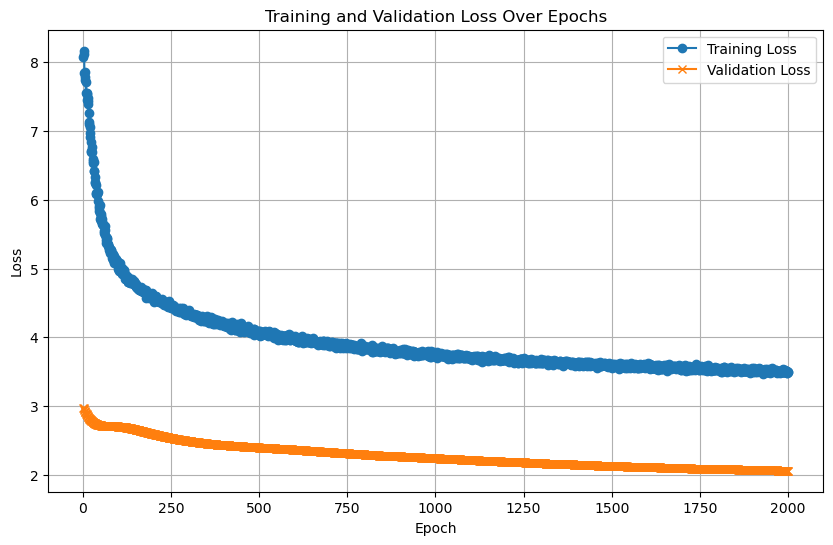

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/210], Loss: 4.6589
Test Batch [20/210], Loss: 5.0089
Test Batch [30/210], Loss: 5.6717
Test Batch [40/210], Loss: 6.0249
Test Batch [50/210], Loss: 7.4135


Test Batch [60/210], Loss: 5.8257
Test Batch [70/210], Loss: 5.0563
Test Batch [80/210], Loss: 5.5428
Test Batch [90/210], Loss: 4.7303
Test Batch [100/210], Loss: 4.7368
Test Batch [110/210], Loss: 4.6931
Test Batch [120/210], Loss: 4.5905
Test Batch [130/210], Loss: 5.2189
Test Batch [140/210], Loss: 5.1847
Test Batch [150/210], Loss: 5.2133


Test Batch [160/210], Loss: 5.3970
Test Batch [170/210], Loss: 5.1074
Test Batch [180/210], Loss: 5.1845
Test Batch [190/210], Loss: 4.8245
Test Batch [200/210], Loss: 5.1649
Test Batch [210/210], Loss: 4.5875

Test Loss: 5.2283


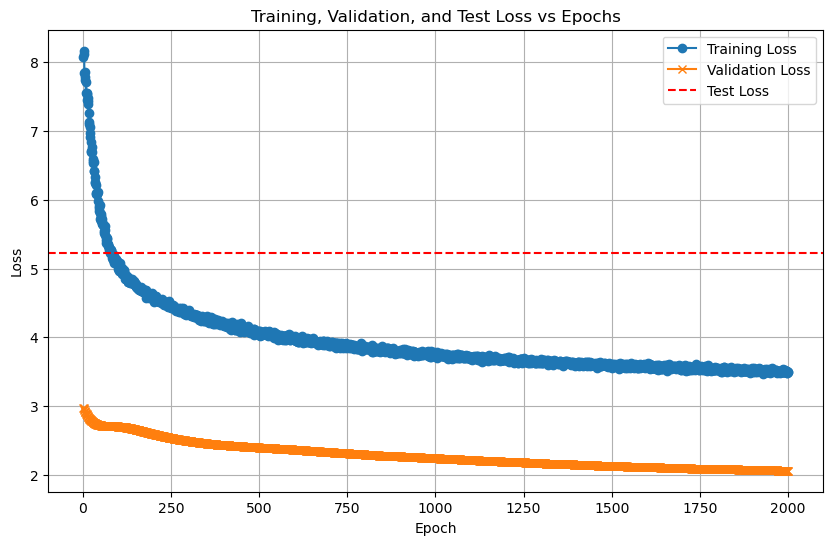

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.
  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.


  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.


  Processed batch 80/210 for test dataset.
  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.


  Processed batch 130/210 for test dataset.
  Processed batch 140/210 for test dataset.


  Processed batch 150/210 for test dataset.
  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.


  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 96.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6907  |  Val Loss: 2.6734
Validation loss improved from inf to 2.6734.
[Epoch 2/1000] Train Loss: 2.6563  |  Val Loss: 2.6427
Validation loss improved from 2.6734 to 2.6427.
[Epoch 3/1000] Train Loss: 2.6262  |  Val Loss: 2.6139
Validation loss improved from 2.6427 to 2.6139.
[Epoch 4/1000] Train Loss: 2.5970  |  Val Loss: 2.5864
Validation loss improved from 2.6139 to 2.5864.
[Epoch 5/1000] Train Loss: 2.5702  |  Val Loss: 2.5600
Validation loss improved from 2.5864 to 2.5600.
[Epoch 6/1000] Train Loss: 2.5436  |  Val Loss: 2.5348
Validation loss improved from 2.5600 to 2.5348.
[Epoch 7/1000] Train Loss: 2.5193  |  Val Loss: 2.5099
Validation loss improved from 2.5348 to 2.5099.
[Epoch 8/1000] Train Loss: 2.4927  |  Val Loss: 2.4863
Validation loss improved from 2.5099 to 2.4863.
[Epoch 9/1000] Train Loss: 2.4679  |  Val Loss: 2.4622
Validation loss improved from 2.4863 to 2.4622.
[Epoch 10/1000] Train Loss: 2.4447  |  Val Loss: 2.4375
Validation loss impr

[Epoch 18/1000] Train Loss: 2.2569  |  Val Loss: 2.2547
Validation loss improved from 2.2773 to 2.2547.
[Epoch 19/1000] Train Loss: 2.2344  |  Val Loss: 2.2316
Validation loss improved from 2.2547 to 2.2316.
[Epoch 20/1000] Train Loss: 2.2103  |  Val Loss: 2.2087
Validation loss improved from 2.2316 to 2.2087.
[Epoch 21/1000] Train Loss: 2.1873  |  Val Loss: 2.1860
Validation loss improved from 2.2087 to 2.1860.


[Epoch 22/1000] Train Loss: 2.1639  |  Val Loss: 2.1638
Validation loss improved from 2.1860 to 2.1638.
[Epoch 23/1000] Train Loss: 2.1415  |  Val Loss: 2.1411
Validation loss improved from 2.1638 to 2.1411.
[Epoch 24/1000] Train Loss: 2.1181  |  Val Loss: 2.1186
Validation loss improved from 2.1411 to 2.1186.
[Epoch 25/1000] Train Loss: 2.0954  |  Val Loss: 2.0964
Validation loss improved from 2.1186 to 2.0964.
[Epoch 26/1000] Train Loss: 2.0721  |  Val Loss: 2.0745
Validation loss improved from 2.0964 to 2.0745.
[Epoch 27/1000] Train Loss: 2.0501  |  Val Loss: 2.0531
Validation loss improved from 2.0745 to 2.0531.
[Epoch 28/1000] Train Loss: 2.0276  |  Val Loss: 2.0323
Validation loss improved from 2.0531 to 2.0323.
[Epoch 29/1000] Train Loss: 2.0069  |  Val Loss: 2.0120
Validation loss improved from 2.0323 to 2.0120.
[Epoch 30/1000] Train Loss: 1.9859  |  Val Loss: 1.9925
Validation loss improved from 2.0120 to 1.9925.
[Epoch 31/1000] Train Loss: 1.9657  |  Val Loss: 1.9735
Validati

[Epoch 36/1000] Train Loss: 1.8705  |  Val Loss: 1.8846
Validation loss improved from 1.9016 to 1.8846.
[Epoch 37/1000] Train Loss: 1.8521  |  Val Loss: 1.8678
Validation loss improved from 1.8846 to 1.8678.
[Epoch 38/1000] Train Loss: 1.8340  |  Val Loss: 1.8511
Validation loss improved from 1.8678 to 1.8511.


[Epoch 39/1000] Train Loss: 1.8161  |  Val Loss: 1.8345
Validation loss improved from 1.8511 to 1.8345.
[Epoch 40/1000] Train Loss: 1.7987  |  Val Loss: 1.8182
Validation loss improved from 1.8345 to 1.8182.
[Epoch 41/1000] Train Loss: 1.7816  |  Val Loss: 1.8022
Validation loss improved from 1.8182 to 1.8022.
[Epoch 42/1000] Train Loss: 1.7640  |  Val Loss: 1.7860
Validation loss improved from 1.8022 to 1.7860.
[Epoch 43/1000] Train Loss: 1.7470  |  Val Loss: 1.7700
Validation loss improved from 1.7860 to 1.7700.
[Epoch 44/1000] Train Loss: 1.7304  |  Val Loss: 1.7541
Validation loss improved from 1.7700 to 1.7541.
[Epoch 45/1000] Train Loss: 1.7132  |  Val Loss: 1.7380
Validation loss improved from 1.7541 to 1.7380.
[Epoch 46/1000] Train Loss: 1.6968  |  Val Loss: 1.7227
Validation loss improved from 1.7380 to 1.7227.
[Epoch 47/1000] Train Loss: 1.6805  |  Val Loss: 1.7068
Validation loss improved from 1.7227 to 1.7068.
[Epoch 48/1000] Train Loss: 1.6643  |  Val Loss: 1.6912
Validati

[Epoch 54/1000] Train Loss: 1.5687  |  Val Loss: 1.5982
Validation loss improved from 1.6134 to 1.5982.
[Epoch 55/1000] Train Loss: 1.5531  |  Val Loss: 1.5828
Validation loss improved from 1.5982 to 1.5828.
[Epoch 56/1000] Train Loss: 1.5368  |  Val Loss: 1.5672
Validation loss improved from 1.5828 to 1.5672.
[Epoch 57/1000] Train Loss: 1.5212  |  Val Loss: 1.5518
Validation loss improved from 1.5672 to 1.5518.
[Epoch 58/1000] Train Loss: 1.5054  |  Val Loss: 1.5364
Validation loss improved from 1.5518 to 1.5364.
[Epoch 59/1000] Train Loss: 1.4894  |  Val Loss: 1.5210
Validation loss improved from 1.5364 to 1.5210.


[Epoch 60/1000] Train Loss: 1.4737  |  Val Loss: 1.5056
Validation loss improved from 1.5210 to 1.5056.
[Epoch 61/1000] Train Loss: 1.4582  |  Val Loss: 1.4902
Validation loss improved from 1.5056 to 1.4902.
[Epoch 62/1000] Train Loss: 1.4419  |  Val Loss: 1.4751
Validation loss improved from 1.4902 to 1.4751.
[Epoch 63/1000] Train Loss: 1.4266  |  Val Loss: 1.4597
Validation loss improved from 1.4751 to 1.4597.
[Epoch 64/1000] Train Loss: 1.4106  |  Val Loss: 1.4447
Validation loss improved from 1.4597 to 1.4447.
[Epoch 65/1000] Train Loss: 1.3957  |  Val Loss: 1.4291
Validation loss improved from 1.4447 to 1.4291.
[Epoch 66/1000] Train Loss: 1.3796  |  Val Loss: 1.4136
Validation loss improved from 1.4291 to 1.4136.
[Epoch 67/1000] Train Loss: 1.3638  |  Val Loss: 1.3984
Validation loss improved from 1.4136 to 1.3984.
[Epoch 68/1000] Train Loss: 1.3485  |  Val Loss: 1.3829
Validation loss improved from 1.3984 to 1.3829.
[Epoch 69/1000] Train Loss: 1.3323  |  Val Loss: 1.3672
Validati

[Epoch 72/1000] Train Loss: 1.2870  |  Val Loss: 1.3227
Validation loss improved from 1.3370 to 1.3227.
[Epoch 73/1000] Train Loss: 1.2718  |  Val Loss: 1.3081
Validation loss improved from 1.3227 to 1.3081.
[Epoch 74/1000] Train Loss: 1.2567  |  Val Loss: 1.2933
Validation loss improved from 1.3081 to 1.2933.
[Epoch 75/1000] Train Loss: 1.2418  |  Val Loss: 1.2784
Validation loss improved from 1.2933 to 1.2784.
[Epoch 76/1000] Train Loss: 1.2268  |  Val Loss: 1.2639
Validation loss improved from 1.2784 to 1.2639.
[Epoch 77/1000] Train Loss: 1.2119  |  Val Loss: 1.2497
Validation loss improved from 1.2639 to 1.2497.


[Epoch 78/1000] Train Loss: 1.1971  |  Val Loss: 1.2356
Validation loss improved from 1.2497 to 1.2356.
[Epoch 79/1000] Train Loss: 1.1824  |  Val Loss: 1.2210
Validation loss improved from 1.2356 to 1.2210.
[Epoch 80/1000] Train Loss: 1.1676  |  Val Loss: 1.2070
Validation loss improved from 1.2210 to 1.2070.
[Epoch 81/1000] Train Loss: 1.1533  |  Val Loss: 1.1924
Validation loss improved from 1.2070 to 1.1924.
[Epoch 82/1000] Train Loss: 1.1386  |  Val Loss: 1.1783
Validation loss improved from 1.1924 to 1.1783.
[Epoch 83/1000] Train Loss: 1.1245  |  Val Loss: 1.1638
Validation loss improved from 1.1783 to 1.1638.
[Epoch 84/1000] Train Loss: 1.1100  |  Val Loss: 1.1494
Validation loss improved from 1.1638 to 1.1494.
[Epoch 85/1000] Train Loss: 1.0955  |  Val Loss: 1.1358
Validation loss improved from 1.1494 to 1.1358.
[Epoch 86/1000] Train Loss: 1.0816  |  Val Loss: 1.1216
Validation loss improved from 1.1358 to 1.1216.
[Epoch 87/1000] Train Loss: 1.0674  |  Val Loss: 1.1083
Validati

[Epoch 88/1000] Train Loss: 1.0531  |  Val Loss: 1.0944
Validation loss improved from 1.1083 to 1.0944.
[Epoch 89/1000] Train Loss: 1.0391  |  Val Loss: 1.0804
Validation loss improved from 1.0944 to 1.0804.
[Epoch 90/1000] Train Loss: 1.0253  |  Val Loss: 1.0657
Validation loss improved from 1.0804 to 1.0657.
[Epoch 91/1000] Train Loss: 1.0114  |  Val Loss: 1.0524
Validation loss improved from 1.0657 to 1.0524.
[Epoch 92/1000] Train Loss: 0.9975  |  Val Loss: 1.0389
Validation loss improved from 1.0524 to 1.0389.
[Epoch 93/1000] Train Loss: 0.9846  |  Val Loss: 1.0250
Validation loss improved from 1.0389 to 1.0250.
[Epoch 94/1000] Train Loss: 0.9708  |  Val Loss: 1.0117
Validation loss improved from 1.0250 to 1.0117.


[Epoch 95/1000] Train Loss: 0.9571  |  Val Loss: 0.9991
Validation loss improved from 1.0117 to 0.9991.
[Epoch 96/1000] Train Loss: 0.9437  |  Val Loss: 0.9858
Validation loss improved from 0.9991 to 0.9858.
[Epoch 97/1000] Train Loss: 0.9306  |  Val Loss: 0.9727
Validation loss improved from 0.9858 to 0.9727.
[Epoch 98/1000] Train Loss: 0.9170  |  Val Loss: 0.9597
Validation loss improved from 0.9727 to 0.9597.
[Epoch 99/1000] Train Loss: 0.9044  |  Val Loss: 0.9469
Validation loss improved from 0.9597 to 0.9469.
[Epoch 100/1000] Train Loss: 0.8910  |  Val Loss: 0.9339
Validation loss improved from 0.9469 to 0.9339.
[Epoch 101/1000] Train Loss: 0.8786  |  Val Loss: 0.9211
Validation loss improved from 0.9339 to 0.9211.
[Epoch 102/1000] Train Loss: 0.8657  |  Val Loss: 0.9083
Validation loss improved from 0.9211 to 0.9083.
[Epoch 103/1000] Train Loss: 0.8530  |  Val Loss: 0.8957
Validation loss improved from 0.9083 to 0.8957.
[Epoch 104/1000] Train Loss: 0.8401  |  Val Loss: 0.8838
Val

[Epoch 105/1000] Train Loss: 0.8280  |  Val Loss: 0.8720
Validation loss improved from 0.8838 to 0.8720.
[Epoch 106/1000] Train Loss: 0.8155  |  Val Loss: 0.8602
Validation loss improved from 0.8720 to 0.8602.
[Epoch 107/1000] Train Loss: 0.8036  |  Val Loss: 0.8481
Validation loss improved from 0.8602 to 0.8481.
[Epoch 108/1000] Train Loss: 0.7914  |  Val Loss: 0.8366
Validation loss improved from 0.8481 to 0.8366.
[Epoch 109/1000] Train Loss: 0.7791  |  Val Loss: 0.8245
Validation loss improved from 0.8366 to 0.8245.
[Epoch 110/1000] Train Loss: 0.7675  |  Val Loss: 0.8123
Validation loss improved from 0.8245 to 0.8123.
[Epoch 111/1000] Train Loss: 0.7555  |  Val Loss: 0.7997
Validation loss improved from 0.8123 to 0.7997.


[Epoch 112/1000] Train Loss: 0.7439  |  Val Loss: 0.7880
Validation loss improved from 0.7997 to 0.7880.
[Epoch 113/1000] Train Loss: 0.7325  |  Val Loss: 0.7767
Validation loss improved from 0.7880 to 0.7767.
[Epoch 114/1000] Train Loss: 0.7209  |  Val Loss: 0.7658
Validation loss improved from 0.7767 to 0.7658.
[Epoch 115/1000] Train Loss: 0.7095  |  Val Loss: 0.7537
Validation loss improved from 0.7658 to 0.7537.
[Epoch 116/1000] Train Loss: 0.6984  |  Val Loss: 0.7427
Validation loss improved from 0.7537 to 0.7427.
[Epoch 117/1000] Train Loss: 0.6881  |  Val Loss: 0.7325
Validation loss improved from 0.7427 to 0.7325.
[Epoch 118/1000] Train Loss: 0.6763  |  Val Loss: 0.7214
Validation loss improved from 0.7325 to 0.7214.
[Epoch 119/1000] Train Loss: 0.6660  |  Val Loss: 0.7106
Validation loss improved from 0.7214 to 0.7106.
[Epoch 120/1000] Train Loss: 0.6552  |  Val Loss: 0.6999
Validation loss improved from 0.7106 to 0.6999.
[Epoch 121/1000] Train Loss: 0.6454  |  Val Loss: 0.690

[Epoch 123/1000] Train Loss: 0.6246  |  Val Loss: 0.6707
Validation loss improved from 0.6796 to 0.6707.
[Epoch 124/1000] Train Loss: 0.6147  |  Val Loss: 0.6610
Validation loss improved from 0.6707 to 0.6610.
[Epoch 125/1000] Train Loss: 0.6050  |  Val Loss: 0.6522
Validation loss improved from 0.6610 to 0.6522.
[Epoch 126/1000] Train Loss: 0.5952  |  Val Loss: 0.6429
Validation loss improved from 0.6522 to 0.6429.
[Epoch 127/1000] Train Loss: 0.5856  |  Val Loss: 0.6335
Validation loss improved from 0.6429 to 0.6335.
[Epoch 128/1000] Train Loss: 0.5763  |  Val Loss: 0.6240
Validation loss improved from 0.6335 to 0.6240.
[Epoch 129/1000] Train Loss: 0.5670  |  Val Loss: 0.6154
Validation loss improved from 0.6240 to 0.6154.
[Epoch 130/1000] Train Loss: 0.5582  |  Val Loss: 0.6074
Validation loss improved from 0.6154 to 0.6074.


[Epoch 131/1000] Train Loss: 0.5491  |  Val Loss: 0.5986
Validation loss improved from 0.6074 to 0.5986.
[Epoch 132/1000] Train Loss: 0.5398  |  Val Loss: 0.5902
Validation loss improved from 0.5986 to 0.5902.
[Epoch 133/1000] Train Loss: 0.5317  |  Val Loss: 0.5820
Validation loss improved from 0.5902 to 0.5820.
[Epoch 134/1000] Train Loss: 0.5232  |  Val Loss: 0.5749
Validation loss improved from 0.5820 to 0.5749.
[Epoch 135/1000] Train Loss: 0.5147  |  Val Loss: 0.5670
Validation loss improved from 0.5749 to 0.5670.
[Epoch 136/1000] Train Loss: 0.5068  |  Val Loss: 0.5597
Validation loss improved from 0.5670 to 0.5597.
[Epoch 137/1000] Train Loss: 0.4989  |  Val Loss: 0.5517
Validation loss improved from 0.5597 to 0.5517.
[Epoch 138/1000] Train Loss: 0.4908  |  Val Loss: 0.5456
Validation loss improved from 0.5517 to 0.5456.
[Epoch 139/1000] Train Loss: 0.4832  |  Val Loss: 0.5392
Validation loss improved from 0.5456 to 0.5392.
[Epoch 140/1000] Train Loss: 0.4757  |  Val Loss: 0.532

[Epoch 143/1000] Train Loss: 0.4543  |  Val Loss: 0.5113
Validation loss improved from 0.5183 to 0.5113.
[Epoch 144/1000] Train Loss: 0.4478  |  Val Loss: 0.5050
Validation loss improved from 0.5113 to 0.5050.
[Epoch 145/1000] Train Loss: 0.4408  |  Val Loss: 0.4997
Validation loss improved from 0.5050 to 0.4997.
[Epoch 146/1000] Train Loss: 0.4346  |  Val Loss: 0.4956
Validation loss improved from 0.4997 to 0.4956.
[Epoch 147/1000] Train Loss: 0.4282  |  Val Loss: 0.4903
Validation loss improved from 0.4956 to 0.4903.
[Epoch 148/1000] Train Loss: 0.4218  |  Val Loss: 0.4843
Validation loss improved from 0.4903 to 0.4843.
[Epoch 149/1000] Train Loss: 0.4156  |  Val Loss: 0.4778
Validation loss improved from 0.4843 to 0.4778.


[Epoch 150/1000] Train Loss: 0.4099  |  Val Loss: 0.4714
Validation loss improved from 0.4778 to 0.4714.
[Epoch 151/1000] Train Loss: 0.4040  |  Val Loss: 0.4668
Validation loss improved from 0.4714 to 0.4668.
[Epoch 152/1000] Train Loss: 0.3982  |  Val Loss: 0.4628
Validation loss improved from 0.4668 to 0.4628.
[Epoch 153/1000] Train Loss: 0.3930  |  Val Loss: 0.4595
Validation loss improved from 0.4628 to 0.4595.
[Epoch 154/1000] Train Loss: 0.3877  |  Val Loss: 0.4541
Validation loss improved from 0.4595 to 0.4541.
[Epoch 155/1000] Train Loss: 0.3821  |  Val Loss: 0.4497
Validation loss improved from 0.4541 to 0.4497.
[Epoch 156/1000] Train Loss: 0.3770  |  Val Loss: 0.4451
Validation loss improved from 0.4497 to 0.4451.
[Epoch 157/1000] Train Loss: 0.3720  |  Val Loss: 0.4417
Validation loss improved from 0.4451 to 0.4417.
[Epoch 158/1000] Train Loss: 0.3671  |  Val Loss: 0.4365
Validation loss improved from 0.4417 to 0.4365.
[Epoch 159/1000] Train Loss: 0.3623  |  Val Loss: 0.432

[Epoch 163/1000] Train Loss: 0.3443  |  Val Loss: 0.4187
Validation loss improved from 0.4219 to 0.4187.
[Epoch 164/1000] Train Loss: 0.3405  |  Val Loss: 0.4138
Validation loss improved from 0.4187 to 0.4138.
[Epoch 165/1000] Train Loss: 0.3363  |  Val Loss: 0.4105
Validation loss improved from 0.4138 to 0.4105.
[Epoch 166/1000] Train Loss: 0.3320  |  Val Loss: 0.4088
Validation loss improved from 0.4105 to 0.4088.
[Epoch 167/1000] Train Loss: 0.3282  |  Val Loss: 0.4066
Validation loss improved from 0.4088 to 0.4066.
[Epoch 168/1000] Train Loss: 0.3244  |  Val Loss: 0.4025
Validation loss improved from 0.4066 to 0.4025.
[Epoch 169/1000] Train Loss: 0.3202  |  Val Loss: 0.3987
Validation loss improved from 0.4025 to 0.3987.


[Epoch 170/1000] Train Loss: 0.3168  |  Val Loss: 0.3953
Validation loss improved from 0.3987 to 0.3953.
[Epoch 171/1000] Train Loss: 0.3132  |  Val Loss: 0.3936
Validation loss improved from 0.3953 to 0.3936.
[Epoch 172/1000] Train Loss: 0.3099  |  Val Loss: 0.3907
Validation loss improved from 0.3936 to 0.3907.
[Epoch 173/1000] Train Loss: 0.3062  |  Val Loss: 0.3870
Validation loss improved from 0.3907 to 0.3870.
[Epoch 174/1000] Train Loss: 0.3028  |  Val Loss: 0.3849
Validation loss improved from 0.3870 to 0.3849.
[Epoch 175/1000] Train Loss: 0.2995  |  Val Loss: 0.3818
Validation loss improved from 0.3849 to 0.3818.
[Epoch 176/1000] Train Loss: 0.2962  |  Val Loss: 0.3799
Validation loss improved from 0.3818 to 0.3799.
[Epoch 177/1000] Train Loss: 0.2933  |  Val Loss: 0.3781
Validation loss improved from 0.3799 to 0.3781.
[Epoch 178/1000] Train Loss: 0.2901  |  Val Loss: 0.3760
Validation loss improved from 0.3781 to 0.3760.
[Epoch 179/1000] Train Loss: 0.2872  |  Val Loss: 0.373

[Epoch 185/1000] Train Loss: 0.2704  |  Val Loss: 0.3613
Validation loss improved from 0.3638 to 0.3613.
[Epoch 186/1000] Train Loss: 0.2679  |  Val Loss: 0.3586
Validation loss improved from 0.3613 to 0.3586.
[Epoch 187/1000] Train Loss: 0.2654  |  Val Loss: 0.3572
Validation loss improved from 0.3586 to 0.3572.
[Epoch 188/1000] Train Loss: 0.2631  |  Val Loss: 0.3559
Validation loss improved from 0.3572 to 0.3559.


[Epoch 189/1000] Train Loss: 0.2607  |  Val Loss: 0.3552
Validation loss improved from 0.3559 to 0.3552.
[Epoch 190/1000] Train Loss: 0.2582  |  Val Loss: 0.3545
Validation loss improved from 0.3552 to 0.3545.
[Epoch 191/1000] Train Loss: 0.2560  |  Val Loss: 0.3510
Validation loss improved from 0.3545 to 0.3510.
[Epoch 192/1000] Train Loss: 0.2538  |  Val Loss: 0.3493
Validation loss improved from 0.3510 to 0.3493.
[Epoch 193/1000] Train Loss: 0.2515  |  Val Loss: 0.3476
Validation loss improved from 0.3493 to 0.3476.
[Epoch 194/1000] Train Loss: 0.2494  |  Val Loss: 0.3469
Validation loss improved from 0.3476 to 0.3469.
[Epoch 195/1000] Train Loss: 0.2472  |  Val Loss: 0.3446
Validation loss improved from 0.3469 to 0.3446.
[Epoch 196/1000] Train Loss: 0.2450  |  Val Loss: 0.3431
Validation loss improved from 0.3446 to 0.3431.
[Epoch 197/1000] Train Loss: 0.2432  |  Val Loss: 0.3413
Validation loss improved from 0.3431 to 0.3413.
[Epoch 198/1000] Train Loss: 0.2410  |  Val Loss: 0.341

[Epoch 203/1000] Train Loss: 0.2316  |  Val Loss: 0.3355
Validation loss improved from 0.3371 to 0.3355.
[Epoch 204/1000] Train Loss: 0.2300  |  Val Loss: 0.3335
Validation loss improved from 0.3355 to 0.3335.
[Epoch 205/1000] Train Loss: 0.2283  |  Val Loss: 0.3323
Validation loss improved from 0.3335 to 0.3323.
[Epoch 206/1000] Train Loss: 0.2263  |  Val Loss: 0.3299
Validation loss improved from 0.3323 to 0.3299.


[Epoch 207/1000] Train Loss: 0.2249  |  Val Loss: 0.3301
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 0.2231  |  Val Loss: 0.3299
Validation loss improved from 0.3299 to 0.3299.
[Epoch 209/1000] Train Loss: 0.2216  |  Val Loss: 0.3279
Validation loss improved from 0.3299 to 0.3279.
[Epoch 210/1000] Train Loss: 0.2200  |  Val Loss: 0.3266
Validation loss improved from 0.3279 to 0.3266.
[Epoch 211/1000] Train Loss: 0.2184  |  Val Loss: 0.3249
Validation loss improved from 0.3266 to 0.3249.
[Epoch 212/1000] Train Loss: 0.2165  |  Val Loss: 0.3242
Validation loss improved from 0.3249 to 0.3242.
[Epoch 213/1000] Train Loss: 0.2155  |  Val Loss: 0.3235
Validation loss improved from 0.3242 to 0.3235.
[Epoch 214/1000] Train Loss: 0.2138  |  Val Loss: 0.3218
Validation loss improved from 0.3235 to 0.3218.
[Epoch 215/1000] Train Loss: 0.2124  |  Val Loss: 0.3199
Validation loss improved from 0.3218 to 0.3199.
[Epoch 216/1000] Train Loss: 0.2107  |  Val Loss:

[Epoch 222/1000] Train Loss: 0.2026  |  Val Loss: 0.3183
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 223/1000] Train Loss: 0.2013  |  Val Loss: 0.3158
Validation loss improved from 0.3169 to 0.3158.
[Epoch 224/1000] Train Loss: 0.2000  |  Val Loss: 0.3163
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.1987  |  Val Loss: 0.3145
Validation loss improved from 0.3158 to 0.3145.
[Epoch 226/1000] Train Loss: 0.1976  |  Val Loss: 0.3134
Validation loss improved from 0.3145 to 0.3134.
[Epoch 227/1000] Train Loss: 0.1962  |  Val Loss: 0.3135
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 228/1000] Train Loss: 0.1949  |  Val Loss: 0.3131
Validation loss improved from 0.3134 to 0.3131.
[Epoch 229/1000] Train Loss: 0.1939  |  Val Loss: 0.3137
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.1931  |  Val Loss: 0.3141
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 231/1000] Train Loss: 0.1919  |  Val Loss: 0.3113
Validation loss improved from 0.3131 to 0.3113.
[Epoch 232/1000] Train Loss: 0.

[Epoch 242/1000] Train Loss: 0.1804  |  Val Loss: 0.3062
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 243/1000] Train Loss: 0.1793  |  Val Loss: 0.3079
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 244/1000] Train Loss: 0.1783  |  Val Loss: 0.3088
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 245/1000] Train Loss: 0.1777  |  Val Loss: 0.3087
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 246/1000] Train Loss: 0.1772  |  Val Loss: 0.3073
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 247/1000] Train Loss: 0.1757  |  Val Loss: 0.3062
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 248/1000] Train Loss: 0.1749  |  Val Loss: 0.3042
Validation loss improved from 0.3058 to 0.3042.
[Epoch 249/1000] Train Loss: 0.1740  |  Val Loss: 0.3042
Validation loss improved from 0.3042 to 0.3042.
[Epoch 250/1000] Train Loss: 0.1732  |  Val Loss: 0.3037
Validation loss improved from 0.3042 to 0.3037.
[Epoch 251/1000] Tr

[Epoch 262/1000] Train Loss: 0.1639  |  Val Loss: 0.3051
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 263/1000] Train Loss: 0.1631  |  Val Loss: 0.3030
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 264/1000] Train Loss: 0.1624  |  Val Loss: 0.3021
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 265/1000] Train Loss: 0.1617  |  Val Loss: 0.3027
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 266/1000] Train Loss: 0.1615  |  Val Loss: 0.3024
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 267/1000] Train Loss: 0.1606  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 268/1000] Train Loss: 0.1599  |  Val Loss: 0.3034
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 269/1000] Train Loss: 0.1592  |  Val Loss: 0.3022
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 270/1000] Train Loss: 0.1584  |  Val Loss: 0.3034
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 279/1000] Train Loss: 0.1528  |  Val Loss: 0.3025
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 280/1000] Train Loss: 0.1524  |  Val Loss: 0.3008
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 281/1000] Train Loss: 0.1520  |  Val Loss: 0.3004
Validation loss improved from 0.3005 to 0.3004.
[Epoch 282/1000] Train Loss: 0.1511  |  Val Loss: 0.3004
Validation loss improved from 0.3004 to 0.3004.
[Epoch 283/1000] Train Loss: 0.1507  |  Val Loss: 0.3015
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 284/1000] Train Loss: 0.1502  |  Val Loss: 0.3015
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 285/1000] Train Loss: 0.1495  |  Val Loss: 0.3010
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 286/1000] Train Loss: 0.1489  |  Val Loss: 0.3008
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 287/1000] Train Loss: 0.1485  |  Val Loss: 0.3004
Validation loss improved from 0.3004 to 0.3004.
[Epoch 288/1000] Tr

[Epoch 297/1000] Train Loss: 0.1439  |  Val Loss: 0.3004
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 298/1000] Train Loss: 0.1432  |  Val Loss: 0.2985
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 299/1000] Train Loss: 0.1426  |  Val Loss: 0.2999
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 300/1000] Train Loss: 0.1423  |  Val Loss: 0.3010
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 301/1000] Train Loss: 0.1418  |  Val Loss: 0.3004
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 302/1000] Train Loss: 0.1413  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 303/1000] Train Loss: 0.1410  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 304/1000] Train Loss: 0.1408  |  Val Loss: 0.3025
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 305/1000] Train Loss: 0.1403  |  Val Loss: 0.3012
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 315/1000] Train Loss: 0.1361  |  Val Loss: 0.3036
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 316/1000] Train Loss: 0.1355  |  Val Loss: 0.3037
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 317/1000] Train Loss: 0.1358  |  Val Loss: 0.2999
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 318/1000] Train Loss: 0.1350  |  Val Loss: 0.3003
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 319/1000] Train Loss: 0.1346  |  Val Loss: 0.3010
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 320/1000] Train Loss: 0.1341  |  Val Loss: 0.3010
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 321/1000] Train Loss: 0.1339  |  Val Loss: 0.2997
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 322/1000] Train Loss: 0.1334  |  Val Loss: 0.3021
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 323/1000] Train Loss: 0.1328  |  Val Loss: 0.3013
!! Validation loss did NOT improve !! Patience:

[Epoch 335/1000] Train Loss: 0.1287  |  Val Loss: 0.3023
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 336/1000] Train Loss: 0.1285  |  Val Loss: 0.3034
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 337/1000] Train Loss: 0.1280  |  Val Loss: 0.3027
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 338/1000] Train Loss: 0.1277  |  Val Loss: 0.3009
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 339/1000] Train Loss: 0.1275  |  Val Loss: 0.3019
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 340/1000] Train Loss: 0.1274  |  Val Loss: 0.3024
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 341/1000] Train Loss: 0.1282  |  Val Loss: 0.3025
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 342/1000] Train Loss: 0.1270  |  Val Loss: 0.3014
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 343/1000] Train Loss: 0.1266  |  Val Loss: 0.3026
!! Validation loss did NOT improve !! Patience:

[Epoch 354/1000] Train Loss: 0.1233  |  Val Loss: 0.3048
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 355/1000] Train Loss: 0.1228  |  Val Loss: 0.3051
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 356/1000] Train Loss: 0.1233  |  Val Loss: 0.3056
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 357/1000] Train Loss: 0.1237  |  Val Loss: 0.3028
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 358/1000] Train Loss: 0.1221  |  Val Loss: 0.3051
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 359/1000] Train Loss: 0.1219  |  Val Loss: 0.3078
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 360/1000] Train Loss: 0.1214  |  Val Loss: 0.3074
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 361/1000] Train Loss: 0.1211  |  Val Loss: 0.3061
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 362/1000] Train Loss: 0.1212  |  Val Loss: 0.3046
!! Validation loss did NOT improve !! Patience:

[Epoch 373/1000] Train Loss: 0.1182  |  Val Loss: 0.3087
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 374/1000] Train Loss: 0.1178  |  Val Loss: 0.3096
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 375/1000] Train Loss: 0.1177  |  Val Loss: 0.3094
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 376/1000] Train Loss: 0.1179  |  Val Loss: 0.3103
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 377/1000] Train Loss: 0.1172  |  Val Loss: 0.3088
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 378/1000] Train Loss: 0.1168  |  Val Loss: 0.3088
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 379/1000] Train Loss: 0.1171  |  Val Loss: 0.3084
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 380/1000] Train Loss: 0.1162  |  Val Loss: 0.3082
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 381/1000] Train Loss: 0.1161  |  Val Loss: 0.3086
!! Validation loss did NOT improve !! Patience:

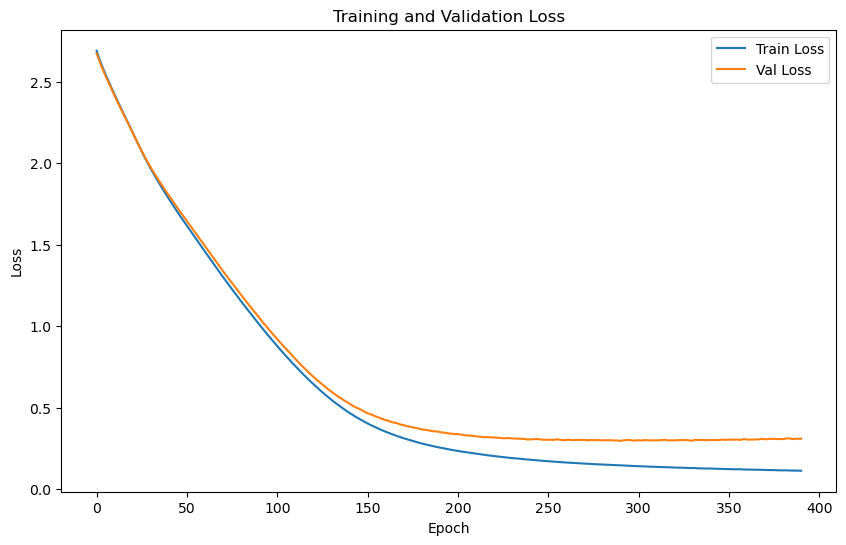

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7367 | Test Accuracy: 84.57%


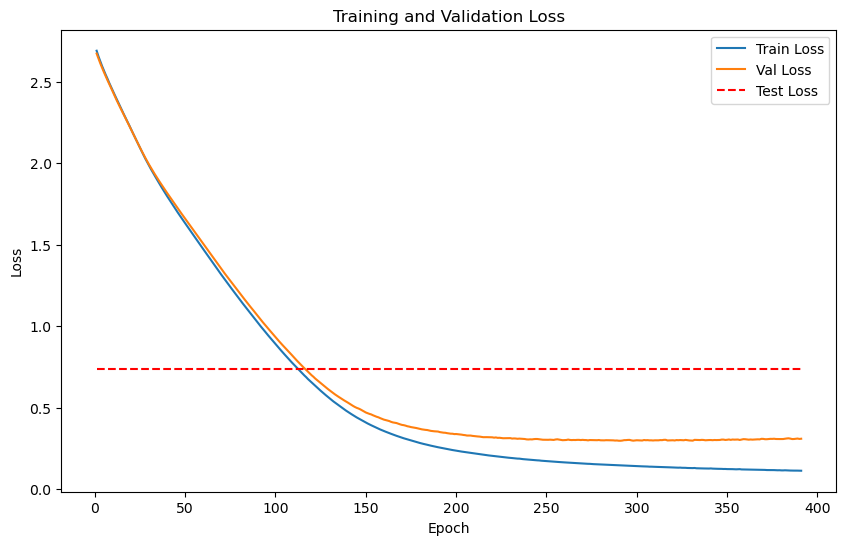

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3065
    Batch [2/2], Val Loss: 0.3727
Epoch [1/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.3396

Validation loss improved from inf to 0.3396. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.3705
Epoch [2/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3386

Validation loss improved from 0.3396 to 0.3386. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3081
    Batch [2/2], Val Loss: 0.3688
Epoch [3/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.3385

Validation loss improved from 0.3386 to 0.3385. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3088
    Batch [2/2], Val Loss: 0.3677
Epoch [4/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.3383

Validation loss improved from 0.3385 to 0.3383. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3087
    Batch [2/2], Val Loss: 0.3668
Epoch [5/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.3378

Validation loss improved from 0.3383 to 0.3378. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3073
    Batch [2/2], Val Loss: 0.3660
Epoch [6/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3366

Validation loss improved from 0.3378 to 0.3366. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.3659
Epoch [7/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.3352

Validation loss improved from 0.3366 to 0.3352. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3015
    Batch [2/2], Val Loss: 0.3658
Epoch [8/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3336

Validation loss improved from 0.3352 to 0.3336. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.2993
    Batch [2/2], Val Loss: 0.3662
Epoch [9/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3327

Validation loss improved from 0.3336 to 0.3327. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.2975
    Batch [2/2], Val Loss: 0.3665
Epoch [10/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.3320

Validation loss improved from 0.3327 to 0.3320. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.2958
    Batch [2/2], Val Loss: 0.3668
Epoch [11/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3313

Validation loss improved from 0.3320 to 0.3313. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.2952
    Batch [2/2], Val Loss: 0.3668
Epoch [12/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3310

Validation loss improved from 0.3313 to 0.3310. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.3667
Epoch [13/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.3310

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.2956
    Batch [2/2], Val Loss: 0.3670
Epoch [14/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3313

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.2954
    Batch [2/2], Val Loss: 0.3672
Epoch [15/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3313

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.2951
    Batch [2/2], Val Loss: 0.3674
Epoch [16/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.3313

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.3675
Epoch [17/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3313

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.2948
    Batch [2/2], Val Loss: 0.3672
Epoch [18/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.3310

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.2945
    Batch [2/2], Val Loss: 0.3671
Epoch [19/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3308

Validation loss improved from 0.3310 to 0.3308. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.3668
Epoch [20/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.3665
Epoch [21/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.3305

Validation loss improved from 0.3306 to 0.3305. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.2943
    Batch [2/2], Val Loss: 0.3665
Epoch [22/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.3304

Validation loss improved from 0.3305 to 0.3304. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.3661
Epoch [23/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3301

Validation loss improved from 0.3304 to 0.3301. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.3657
Epoch [24/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3297

Validation loss improved from 0.3301 to 0.3297. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.3652
Epoch [25/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3293

Validation loss improved from 0.3297 to 0.3293. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.2928
    Batch [2/2], Val Loss: 0.3649
Epoch [26/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3288

Validation loss improved from 0.3293 to 0.3288. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.2923
    Batch [2/2], Val Loss: 0.3643
Epoch [27/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3283

Validation loss improved from 0.3288 to 0.3283. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.2917
    Batch [2/2], Val Loss: 0.3638
Epoch [28/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.3277

Validation loss improved from 0.3283 to 0.3277. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.2911
    Batch [2/2], Val Loss: 0.3631
Epoch [29/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3271

Validation loss improved from 0.3277 to 0.3271. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.2905
    Batch [2/2], Val Loss: 0.3626
Epoch [30/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3265

Validation loss improved from 0.3271 to 0.3265. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.3621
Epoch [31/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3260

Validation loss improved from 0.3265 to 0.3260. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.3616
Epoch [32/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3255

Validation loss improved from 0.3260 to 0.3255. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.3611
Epoch [33/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3249

Validation loss improved from 0.3255 to 0.3249. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.3605
Epoch [34/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3244

Validation loss improved from 0.3249 to 0.3244. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.3600
Epoch [35/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3239

Validation loss improved from 0.3244 to 0.3239. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2872
    Batch [2/2], Val Loss: 0.3594
Epoch [36/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3233

Validation loss improved from 0.3239 to 0.3233. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2867
    Batch [2/2], Val Loss: 0.3588
Epoch [37/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3227

Validation loss improved from 0.3233 to 0.3227. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.3581
Epoch [38/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3222

Validation loss improved from 0.3227 to 0.3222. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2858
    Batch [2/2], Val Loss: 0.3574
Epoch [39/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3216

Validation loss improved from 0.3222 to 0.3216. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2853
    Batch [2/2], Val Loss: 0.3567
Epoch [40/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3210

Validation loss improved from 0.3216 to 0.3210. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2848
    Batch [2/2], Val Loss: 0.3559
Epoch [41/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3204

Validation loss improved from 0.3210 to 0.3204. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2843
    Batch [2/2], Val Loss: 0.3552
Epoch [42/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3197

Validation loss improved from 0.3204 to 0.3197. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.3545
Epoch [43/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.3191

Validation loss improved from 0.3197 to 0.3191. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.3537
Epoch [44/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3184

Validation loss improved from 0.3191 to 0.3184. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.3530
Epoch [45/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.3178

Validation loss improved from 0.3184 to 0.3178. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2821
    Batch [2/2], Val Loss: 0.3524
Epoch [46/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3172

Validation loss improved from 0.3178 to 0.3172. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.3516
Epoch [47/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3166

Validation loss improved from 0.3172 to 0.3166. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2809
    Batch [2/2], Val Loss: 0.3508
Epoch [48/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3159

Validation loss improved from 0.3166 to 0.3159. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2804
    Batch [2/2], Val Loss: 0.3500
Epoch [49/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3152

Validation loss improved from 0.3159 to 0.3152. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.3492
Epoch [50/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3145

Validation loss improved from 0.3152 to 0.3145. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2793
    Batch [2/2], Val Loss: 0.3484
Epoch [51/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3138

Validation loss improved from 0.3145 to 0.3138. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2788
    Batch [2/2], Val Loss: 0.3476
Epoch [52/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.3132

Validation loss improved from 0.3138 to 0.3132. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.3467
Epoch [53/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3125

Validation loss improved from 0.3132 to 0.3125. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.3459
Epoch [54/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3118

Validation loss improved from 0.3125 to 0.3118. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.3451
Epoch [55/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3112

Validation loss improved from 0.3118 to 0.3112. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.3443
Epoch [56/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3105

Validation loss improved from 0.3112 to 0.3105. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2763
    Batch [2/2], Val Loss: 0.3435
Epoch [57/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3099

Validation loss improved from 0.3105 to 0.3099. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2759
    Batch [2/2], Val Loss: 0.3427
Epoch [58/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3093

Validation loss improved from 0.3099 to 0.3093. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.3419
Epoch [59/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3087

Validation loss improved from 0.3093 to 0.3087. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.3411
Epoch [60/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3081

Validation loss improved from 0.3087 to 0.3081. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2745
    Batch [2/2], Val Loss: 0.3404
Epoch [61/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.3075

Validation loss improved from 0.3081 to 0.3075. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.3396
Epoch [62/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3068

Validation loss improved from 0.3075 to 0.3068. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2736
    Batch [2/2], Val Loss: 0.3389
Epoch [63/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.3062

Validation loss improved from 0.3068 to 0.3062. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.3383
Epoch [64/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3057

Validation loss improved from 0.3062 to 0.3057. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2726
    Batch [2/2], Val Loss: 0.3378
Epoch [65/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3052

Validation loss improved from 0.3057 to 0.3052. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2721
    Batch [2/2], Val Loss: 0.3372
Epoch [66/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.3046

Validation loss improved from 0.3052 to 0.3046. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2716
    Batch [2/2], Val Loss: 0.3366
Epoch [67/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.3041

Validation loss improved from 0.3046 to 0.3041. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.3361
Epoch [68/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3036

Validation loss improved from 0.3041 to 0.3036. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2705
    Batch [2/2], Val Loss: 0.3356
Epoch [69/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.3030

Validation loss improved from 0.3036 to 0.3030. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2700
    Batch [2/2], Val Loss: 0.3351
Epoch [70/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.3025

Validation loss improved from 0.3030 to 0.3025. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2695
    Batch [2/2], Val Loss: 0.3344
Epoch [71/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3019

Validation loss improved from 0.3025 to 0.3019. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2690
    Batch [2/2], Val Loss: 0.3336
Epoch [72/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3013

Validation loss improved from 0.3019 to 0.3013. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2685
    Batch [2/2], Val Loss: 0.3329
Epoch [73/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3007

Validation loss improved from 0.3013 to 0.3007. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2680
    Batch [2/2], Val Loss: 0.3322
Epoch [74/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3001

Validation loss improved from 0.3007 to 0.3001. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2675
    Batch [2/2], Val Loss: 0.3315
Epoch [75/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2995

Validation loss improved from 0.3001 to 0.2995. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2670
    Batch [2/2], Val Loss: 0.3309
Epoch [76/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2989

Validation loss improved from 0.2995 to 0.2989. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2665
    Batch [2/2], Val Loss: 0.3301
Epoch [77/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2983

Validation loss improved from 0.2989 to 0.2983. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.3294
Epoch [78/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2977

Validation loss improved from 0.2983 to 0.2977. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2654
    Batch [2/2], Val Loss: 0.3287
Epoch [79/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2970

Validation loss improved from 0.2977 to 0.2970. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.3281
Epoch [80/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2965

Validation loss improved from 0.2970 to 0.2965. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.3274
Epoch [81/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2958

Validation loss improved from 0.2965 to 0.2958. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.3267
Epoch [82/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2952

Validation loss improved from 0.2958 to 0.2952. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2633
    Batch [2/2], Val Loss: 0.3260
Epoch [83/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2947

Validation loss improved from 0.2952 to 0.2947. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2627
    Batch [2/2], Val Loss: 0.3254
Epoch [84/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2941

Validation loss improved from 0.2947 to 0.2941. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2622
    Batch [2/2], Val Loss: 0.3248
Epoch [85/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2935

Validation loss improved from 0.2941 to 0.2935. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.3241
Epoch [86/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2929

Validation loss improved from 0.2935 to 0.2929. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2612
    Batch [2/2], Val Loss: 0.3234
Epoch [87/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2923

Validation loss improved from 0.2929 to 0.2923. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2607
    Batch [2/2], Val Loss: 0.3228
Epoch [88/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2917

Validation loss improved from 0.2923 to 0.2917. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.3222
Epoch [89/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2912

Validation loss improved from 0.2917 to 0.2912. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2598
    Batch [2/2], Val Loss: 0.3215
Epoch [90/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2906

Validation loss improved from 0.2912 to 0.2906. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2593
    Batch [2/2], Val Loss: 0.3207
Epoch [91/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2900

Validation loss improved from 0.2906 to 0.2900. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2588
    Batch [2/2], Val Loss: 0.3199
Epoch [92/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2894

Validation loss improved from 0.2900 to 0.2894. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2584
    Batch [2/2], Val Loss: 0.3192
Epoch [93/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2888

Validation loss improved from 0.2894 to 0.2888. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.3183
Epoch [94/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2881

Validation loss improved from 0.2888 to 0.2881. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2575
    Batch [2/2], Val Loss: 0.3175
Epoch [95/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2875

Validation loss improved from 0.2881 to 0.2875. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2571
    Batch [2/2], Val Loss: 0.3166
Epoch [96/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2868

Validation loss improved from 0.2875 to 0.2868. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2567
    Batch [2/2], Val Loss: 0.3156
Epoch [97/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2861

Validation loss improved from 0.2868 to 0.2861. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.3148
Epoch [98/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2855

Validation loss improved from 0.2861 to 0.2855. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2558
    Batch [2/2], Val Loss: 0.3138
Epoch [99/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2848

Validation loss improved from 0.2855 to 0.2848. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2553
    Batch [2/2], Val Loss: 0.3130
Epoch [100/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2841

Validation loss improved from 0.2848 to 0.2841. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2548
    Batch [2/2], Val Loss: 0.3120
Epoch [101/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2834

Validation loss improved from 0.2841 to 0.2834. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2544
    Batch [2/2], Val Loss: 0.3111
Epoch [102/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2828

Validation loss improved from 0.2834 to 0.2828. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2540
    Batch [2/2], Val Loss: 0.3103
Epoch [103/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2821

Validation loss improved from 0.2828 to 0.2821. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2536
    Batch [2/2], Val Loss: 0.3096
Epoch [104/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2816

Validation loss improved from 0.2821 to 0.2816. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.3089
Epoch [105/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2810

Validation loss improved from 0.2816 to 0.2810. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2527
    Batch [2/2], Val Loss: 0.3080
Epoch [106/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2803

Validation loss improved from 0.2810 to 0.2803. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.3072
Epoch [107/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2797

Validation loss improved from 0.2803 to 0.2797. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.3063
Epoch [108/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.2790

Validation loss improved from 0.2797 to 0.2790. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3056
Epoch [109/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2784

Validation loss improved from 0.2790 to 0.2784. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.3047
Epoch [110/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2778

Validation loss improved from 0.2784 to 0.2778. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.3041
Epoch [111/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2772

Validation loss improved from 0.2778 to 0.2772. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.3034
Epoch [112/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2766

Validation loss improved from 0.2772 to 0.2766. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.3026
Epoch [113/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2760

Validation loss improved from 0.2766 to 0.2760. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.3018
Epoch [114/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2754

Validation loss improved from 0.2760 to 0.2754. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.3011
Epoch [115/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2747

Validation loss improved from 0.2754 to 0.2747. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.3004
Epoch [116/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2742

Validation loss improved from 0.2747 to 0.2742. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2997
Epoch [117/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2736

Validation loss improved from 0.2742 to 0.2736. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2472
    Batch [2/2], Val Loss: 0.2990
Epoch [118/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2731

Validation loss improved from 0.2736 to 0.2731. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2469
    Batch [2/2], Val Loss: 0.2983
Epoch [119/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2726

Validation loss improved from 0.2731 to 0.2726. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2466
    Batch [2/2], Val Loss: 0.2976
Epoch [120/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2721

Validation loss improved from 0.2726 to 0.2721. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2462
    Batch [2/2], Val Loss: 0.2969
Epoch [121/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2715

Validation loss improved from 0.2721 to 0.2715. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2459
    Batch [2/2], Val Loss: 0.2962
Epoch [122/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2711

Validation loss improved from 0.2715 to 0.2711. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2456
    Batch [2/2], Val Loss: 0.2956
Epoch [123/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2706

Validation loss improved from 0.2711 to 0.2706. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2452
    Batch [2/2], Val Loss: 0.2950
Epoch [124/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2701

Validation loss improved from 0.2706 to 0.2701. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.2943
Epoch [125/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2696

Validation loss improved from 0.2701 to 0.2696. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2445
    Batch [2/2], Val Loss: 0.2935
Epoch [126/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2690

Validation loss improved from 0.2696 to 0.2690. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.2928
Epoch [127/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2684

Validation loss improved from 0.2690 to 0.2684. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2437
    Batch [2/2], Val Loss: 0.2919
Epoch [128/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2678

Validation loss improved from 0.2684 to 0.2678. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2433
    Batch [2/2], Val Loss: 0.2910
Epoch [129/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2672

Validation loss improved from 0.2678 to 0.2672. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2430
    Batch [2/2], Val Loss: 0.2902
Epoch [130/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2666

Validation loss improved from 0.2672 to 0.2666. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2426
    Batch [2/2], Val Loss: 0.2896
Epoch [131/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2661

Validation loss improved from 0.2666 to 0.2661. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2422
    Batch [2/2], Val Loss: 0.2890
Epoch [132/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2656

Validation loss improved from 0.2661 to 0.2656. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2419
    Batch [2/2], Val Loss: 0.2885
Epoch [133/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2652

Validation loss improved from 0.2656 to 0.2652. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2415
    Batch [2/2], Val Loss: 0.2880
Epoch [134/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2648

Validation loss improved from 0.2652 to 0.2648. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2411
    Batch [2/2], Val Loss: 0.2876
Epoch [135/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2644

Validation loss improved from 0.2648 to 0.2644. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2407
    Batch [2/2], Val Loss: 0.2872
Epoch [136/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2639

Validation loss improved from 0.2644 to 0.2639. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2402
    Batch [2/2], Val Loss: 0.2868
Epoch [137/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2635

Validation loss improved from 0.2639 to 0.2635. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2398
    Batch [2/2], Val Loss: 0.2865
Epoch [138/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2631

Validation loss improved from 0.2635 to 0.2631. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2393
    Batch [2/2], Val Loss: 0.2860
Epoch [139/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2627

Validation loss improved from 0.2631 to 0.2627. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2389
    Batch [2/2], Val Loss: 0.2855
Epoch [140/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2622

Validation loss improved from 0.2627 to 0.2622. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2385
    Batch [2/2], Val Loss: 0.2850
Epoch [141/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2618

Validation loss improved from 0.2622 to 0.2618. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2381
    Batch [2/2], Val Loss: 0.2845
Epoch [142/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2613

Validation loss improved from 0.2618 to 0.2613. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.2839
Epoch [143/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2608

Validation loss improved from 0.2613 to 0.2608. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2374
    Batch [2/2], Val Loss: 0.2834
Epoch [144/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2604

Validation loss improved from 0.2608 to 0.2604. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2370
    Batch [2/2], Val Loss: 0.2829
Epoch [145/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2600

Validation loss improved from 0.2604 to 0.2600. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2367
    Batch [2/2], Val Loss: 0.2823
Epoch [146/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2595

Validation loss improved from 0.2600 to 0.2595. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2364
    Batch [2/2], Val Loss: 0.2816
Epoch [147/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2590

Validation loss improved from 0.2595 to 0.2590. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2361
    Batch [2/2], Val Loss: 0.2809
Epoch [148/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2585

Validation loss improved from 0.2590 to 0.2585. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.2804
Epoch [149/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2581

Validation loss improved from 0.2585 to 0.2581. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2355
    Batch [2/2], Val Loss: 0.2798
Epoch [150/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2577

Validation loss improved from 0.2581 to 0.2577. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2352
    Batch [2/2], Val Loss: 0.2793
Epoch [151/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2572

Validation loss improved from 0.2577 to 0.2572. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2348
    Batch [2/2], Val Loss: 0.2787
Epoch [152/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2568

Validation loss improved from 0.2572 to 0.2568. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2345
    Batch [2/2], Val Loss: 0.2782
Epoch [153/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2564

Validation loss improved from 0.2568 to 0.2564. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2343
    Batch [2/2], Val Loss: 0.2776
Epoch [154/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2560

Validation loss improved from 0.2564 to 0.2560. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2340
    Batch [2/2], Val Loss: 0.2771
Epoch [155/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2555

Validation loss improved from 0.2560 to 0.2555. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2336
    Batch [2/2], Val Loss: 0.2765
Epoch [156/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2551

Validation loss improved from 0.2555 to 0.2551. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2333
    Batch [2/2], Val Loss: 0.2759
Epoch [157/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2546

Validation loss improved from 0.2551 to 0.2546. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2330
    Batch [2/2], Val Loss: 0.2753
Epoch [158/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2542

Validation loss improved from 0.2546 to 0.2542. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2327
    Batch [2/2], Val Loss: 0.2749
Epoch [159/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2538

Validation loss improved from 0.2542 to 0.2538. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.2744
Epoch [160/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2534

Validation loss improved from 0.2538 to 0.2534. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2320
    Batch [2/2], Val Loss: 0.2741
Epoch [161/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2531

Validation loss improved from 0.2534 to 0.2531. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2317
    Batch [2/2], Val Loss: 0.2736
Epoch [162/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2526

Validation loss improved from 0.2531 to 0.2526. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2313
    Batch [2/2], Val Loss: 0.2730
Epoch [163/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2522

Validation loss improved from 0.2526 to 0.2522. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2310
    Batch [2/2], Val Loss: 0.2724
Epoch [164/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2517

Validation loss improved from 0.2522 to 0.2517. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2307
    Batch [2/2], Val Loss: 0.2717
Epoch [165/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2512

Validation loss improved from 0.2517 to 0.2512. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2305
    Batch [2/2], Val Loss: 0.2710
Epoch [166/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2507

Validation loss improved from 0.2512 to 0.2507. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2302
    Batch [2/2], Val Loss: 0.2705
Epoch [167/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2504

Validation loss improved from 0.2507 to 0.2504. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2299
    Batch [2/2], Val Loss: 0.2700
Epoch [168/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2500

Validation loss improved from 0.2504 to 0.2500. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2297
    Batch [2/2], Val Loss: 0.2695
Epoch [169/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2496

Validation loss improved from 0.2500 to 0.2496. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.2691
Epoch [170/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2493

Validation loss improved from 0.2496 to 0.2493. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.2688
Epoch [171/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2490

Validation loss improved from 0.2493 to 0.2490. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.2685
Epoch [172/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2487

Validation loss improved from 0.2490 to 0.2487. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2287
    Batch [2/2], Val Loss: 0.2682
Epoch [173/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2485

Validation loss improved from 0.2487 to 0.2485. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.2679
Epoch [174/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2482

Validation loss improved from 0.2485 to 0.2482. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2282
    Batch [2/2], Val Loss: 0.2676
Epoch [175/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2479

Validation loss improved from 0.2482 to 0.2479. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2280
    Batch [2/2], Val Loss: 0.2674
Epoch [176/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2477

Validation loss improved from 0.2479 to 0.2477. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.2671
Epoch [177/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2474

Validation loss improved from 0.2477 to 0.2474. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.2666
Epoch [178/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2470

Validation loss improved from 0.2474 to 0.2470. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.2662
Epoch [179/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2467

Validation loss improved from 0.2470 to 0.2467. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2269
    Batch [2/2], Val Loss: 0.2657
Epoch [180/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2463

Validation loss improved from 0.2467 to 0.2463. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2268
    Batch [2/2], Val Loss: 0.2653
Epoch [181/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2460

Validation loss improved from 0.2463 to 0.2460. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.2649
Epoch [182/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2457

Validation loss improved from 0.2460 to 0.2457. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2264
    Batch [2/2], Val Loss: 0.2646
Epoch [183/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2455

Validation loss improved from 0.2457 to 0.2455. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2261
    Batch [2/2], Val Loss: 0.2643
Epoch [184/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2452

Validation loss improved from 0.2455 to 0.2452. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2260
    Batch [2/2], Val Loss: 0.2638
Epoch [185/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2449

Validation loss improved from 0.2452 to 0.2449. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.2633
Epoch [186/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2445

Validation loss improved from 0.2449 to 0.2445. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.2627
Epoch [187/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2441

Validation loss improved from 0.2445 to 0.2441. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2253
    Batch [2/2], Val Loss: 0.2622
Epoch [188/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2438

Validation loss improved from 0.2441 to 0.2438. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.2618
Epoch [189/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.2434

Validation loss improved from 0.2438 to 0.2434. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2248
    Batch [2/2], Val Loss: 0.2613
Epoch [190/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2431

Validation loss improved from 0.2434 to 0.2431. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2246
    Batch [2/2], Val Loss: 0.2609
Epoch [191/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.2427

Validation loss improved from 0.2431 to 0.2427. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2244
    Batch [2/2], Val Loss: 0.2605
Epoch [192/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2424

Validation loss improved from 0.2427 to 0.2424. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.2602
Epoch [193/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2422

Validation loss improved from 0.2424 to 0.2422. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.2598
Epoch [194/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2418

Validation loss improved from 0.2422 to 0.2418. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2236
    Batch [2/2], Val Loss: 0.2594
Epoch [195/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2415

Validation loss improved from 0.2418 to 0.2415. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2233
    Batch [2/2], Val Loss: 0.2591
Epoch [196/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2412

Validation loss improved from 0.2415 to 0.2412. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2230
    Batch [2/2], Val Loss: 0.2590
Epoch [197/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.2410

Validation loss improved from 0.2412 to 0.2410. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2228
    Batch [2/2], Val Loss: 0.2587
Epoch [198/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2407

Validation loss improved from 0.2410 to 0.2407. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2225
    Batch [2/2], Val Loss: 0.2584
Epoch [199/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2404

Validation loss improved from 0.2407 to 0.2404. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2222
    Batch [2/2], Val Loss: 0.2581
Epoch [200/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2401

Validation loss improved from 0.2404 to 0.2401. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.2578
Epoch [201/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2398

Validation loss improved from 0.2401 to 0.2398. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.2575
Epoch [202/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2396

Validation loss improved from 0.2398 to 0.2396. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2214
    Batch [2/2], Val Loss: 0.2572
Epoch [203/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2393

Validation loss improved from 0.2396 to 0.2393. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.2569
Epoch [204/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2390

Validation loss improved from 0.2393 to 0.2390. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2208
    Batch [2/2], Val Loss: 0.2565
Epoch [205/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2386

Validation loss improved from 0.2390 to 0.2386. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.2560
Epoch [206/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2382

Validation loss improved from 0.2386 to 0.2382. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.2557
Epoch [207/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2379

Validation loss improved from 0.2382 to 0.2379. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.2552
Epoch [208/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2376

Validation loss improved from 0.2379 to 0.2376. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2198
    Batch [2/2], Val Loss: 0.2546
Epoch [209/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2372

Validation loss improved from 0.2376 to 0.2372. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.2541
Epoch [210/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2368

Validation loss improved from 0.2372 to 0.2368. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.2535
Epoch [211/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2365

Validation loss improved from 0.2368 to 0.2365. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.2529
Epoch [212/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2361

Validation loss improved from 0.2365 to 0.2361. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2191
    Batch [2/2], Val Loss: 0.2522
Epoch [213/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2357

Validation loss improved from 0.2361 to 0.2357. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2190
    Batch [2/2], Val Loss: 0.2517
Epoch [214/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2353

Validation loss improved from 0.2357 to 0.2353. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.2512
Epoch [215/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2350

Validation loss improved from 0.2353 to 0.2350. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.2509
Epoch [216/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2348

Validation loss improved from 0.2350 to 0.2348. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.2507
Epoch [217/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2345

Validation loss improved from 0.2348 to 0.2345. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.2505
Epoch [218/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2343

Validation loss improved from 0.2345 to 0.2343. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.2503
Epoch [219/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2341

Validation loss improved from 0.2343 to 0.2341. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.2502
Epoch [220/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.2500
Epoch [221/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2337

Validation loss improved from 0.2340 to 0.2337. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.2499
Epoch [222/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.2497
Epoch [223/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.2334

Validation loss improved from 0.2336 to 0.2334. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.2497
Epoch [224/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2334

Validation loss improved from 0.2334 to 0.2334. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.2497
Epoch [225/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2167
    Batch [2/2], Val Loss: 0.2496
Epoch [226/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2332

Validation loss improved from 0.2333 to 0.2332. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2166
    Batch [2/2], Val Loss: 0.2494
Epoch [227/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2330

Validation loss improved from 0.2332 to 0.2330. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.2490
Epoch [228/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.2327

Validation loss improved from 0.2330 to 0.2327. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.2486
Epoch [229/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2324

Validation loss improved from 0.2327 to 0.2324. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2159
    Batch [2/2], Val Loss: 0.2483
Epoch [230/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2321

Validation loss improved from 0.2324 to 0.2321. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2157
    Batch [2/2], Val Loss: 0.2480
Epoch [231/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2318

Validation loss improved from 0.2321 to 0.2318. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2155
    Batch [2/2], Val Loss: 0.2475
Epoch [232/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2315

Validation loss improved from 0.2318 to 0.2315. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.2470
Epoch [233/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2311

Validation loss improved from 0.2315 to 0.2311. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2151
    Batch [2/2], Val Loss: 0.2463
Epoch [234/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2307

Validation loss improved from 0.2311 to 0.2307. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2149
    Batch [2/2], Val Loss: 0.2457
Epoch [235/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2303

Validation loss improved from 0.2307 to 0.2303. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2146
    Batch [2/2], Val Loss: 0.2453
Epoch [236/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2299

Validation loss improved from 0.2303 to 0.2299. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2143
    Batch [2/2], Val Loss: 0.2447
Epoch [237/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.2295

Validation loss improved from 0.2299 to 0.2295. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.2441
Epoch [238/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2291

Validation loss improved from 0.2295 to 0.2291. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.2437
Epoch [239/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2287

Validation loss improved from 0.2291 to 0.2287. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.2432
Epoch [240/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2284

Validation loss improved from 0.2287 to 0.2284. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2132
    Batch [2/2], Val Loss: 0.2427
Epoch [241/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2279

Validation loss improved from 0.2284 to 0.2279. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.2421
Epoch [242/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2275

Validation loss improved from 0.2279 to 0.2275. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2415
Epoch [243/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2271

Validation loss improved from 0.2275 to 0.2271. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2123
    Batch [2/2], Val Loss: 0.2412
Epoch [244/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.2267

Validation loss improved from 0.2271 to 0.2267. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2120
    Batch [2/2], Val Loss: 0.2408
Epoch [245/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.2264

Validation loss improved from 0.2267 to 0.2264. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2117
    Batch [2/2], Val Loss: 0.2405
Epoch [246/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2261

Validation loss improved from 0.2264 to 0.2261. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2115
    Batch [2/2], Val Loss: 0.2403
Epoch [247/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2259

Validation loss improved from 0.2261 to 0.2259. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.2400
Epoch [248/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.2256

Validation loss improved from 0.2259 to 0.2256. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.2395
Epoch [249/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2252

Validation loss improved from 0.2256 to 0.2252. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.2391
Epoch [250/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.2249

Validation loss improved from 0.2252 to 0.2249. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2105
    Batch [2/2], Val Loss: 0.2387
Epoch [251/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2246

Validation loss improved from 0.2249 to 0.2246. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.2383
Epoch [252/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2242

Validation loss improved from 0.2246 to 0.2242. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.2379
Epoch [253/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2239

Validation loss improved from 0.2242 to 0.2239. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2098
    Batch [2/2], Val Loss: 0.2375
Epoch [254/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.2237

Validation loss improved from 0.2239 to 0.2237. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.2372
Epoch [255/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2234

Validation loss improved from 0.2237 to 0.2234. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.2367
Epoch [256/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2231

Validation loss improved from 0.2234 to 0.2231. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.2365
Epoch [257/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2228

Validation loss improved from 0.2231 to 0.2228. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2362
Epoch [258/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2226

Validation loss improved from 0.2228 to 0.2226. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2086
    Batch [2/2], Val Loss: 0.2359
Epoch [259/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2223

Validation loss improved from 0.2226 to 0.2223. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2084
    Batch [2/2], Val Loss: 0.2356
Epoch [260/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2220

Validation loss improved from 0.2223 to 0.2220. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2082
    Batch [2/2], Val Loss: 0.2354
Epoch [261/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2218

Validation loss improved from 0.2220 to 0.2218. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2080
    Batch [2/2], Val Loss: 0.2352
Epoch [262/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2216

Validation loss improved from 0.2218 to 0.2216. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2077
    Batch [2/2], Val Loss: 0.2349
Epoch [263/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2213

Validation loss improved from 0.2216 to 0.2213. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2075
    Batch [2/2], Val Loss: 0.2347
Epoch [264/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2211

Validation loss improved from 0.2213 to 0.2211. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2072
    Batch [2/2], Val Loss: 0.2345
Epoch [265/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2209

Validation loss improved from 0.2211 to 0.2209. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2070
    Batch [2/2], Val Loss: 0.2343
Epoch [266/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.2206

Validation loss improved from 0.2209 to 0.2206. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2066
    Batch [2/2], Val Loss: 0.2341
Epoch [267/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2204

Validation loss improved from 0.2206 to 0.2204. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.2339
Epoch [268/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2201

Validation loss improved from 0.2204 to 0.2201. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2061
    Batch [2/2], Val Loss: 0.2338
Epoch [269/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2199

Validation loss improved from 0.2201 to 0.2199. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.2337
Epoch [270/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2197

Validation loss improved from 0.2199 to 0.2197. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2056
    Batch [2/2], Val Loss: 0.2337
Epoch [271/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2197

Validation loss improved from 0.2197 to 0.2197. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3157
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2055
    Batch [2/2], Val Loss: 0.2338
Epoch [272/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.2196

Validation loss improved from 0.2197 to 0.2196. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2054
    Batch [2/2], Val Loss: 0.2337
Epoch [273/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2195

Validation loss improved from 0.2196 to 0.2195. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2053
    Batch [2/2], Val Loss: 0.2335
Epoch [274/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2194

Validation loss improved from 0.2195 to 0.2194. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2051
    Batch [2/2], Val Loss: 0.2331
Epoch [275/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2191

Validation loss improved from 0.2194 to 0.2191. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3157
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2048
    Batch [2/2], Val Loss: 0.2326
Epoch [276/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.2187

Validation loss improved from 0.2191 to 0.2187. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2045
    Batch [2/2], Val Loss: 0.2321
Epoch [277/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2183

Validation loss improved from 0.2187 to 0.2183. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2041
    Batch [2/2], Val Loss: 0.2314
Epoch [278/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2178

Validation loss improved from 0.2183 to 0.2178. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2038
    Batch [2/2], Val Loss: 0.2309
Epoch [279/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2174

Validation loss improved from 0.2178 to 0.2174. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.2305
Epoch [280/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2170

Validation loss improved from 0.2174 to 0.2170. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2033
    Batch [2/2], Val Loss: 0.2301
Epoch [281/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2167

Validation loss improved from 0.2170 to 0.2167. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2030
    Batch [2/2], Val Loss: 0.2300
Epoch [282/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2165

Validation loss improved from 0.2167 to 0.2165. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2027
    Batch [2/2], Val Loss: 0.2299
Epoch [283/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.2163

Validation loss improved from 0.2165 to 0.2163. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2024
    Batch [2/2], Val Loss: 0.2297
Epoch [284/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2161

Validation loss improved from 0.2163 to 0.2161. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2021
    Batch [2/2], Val Loss: 0.2296
Epoch [285/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2158

Validation loss improved from 0.2161 to 0.2158. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.2295
Epoch [286/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2156

Validation loss improved from 0.2158 to 0.2156. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2013
    Batch [2/2], Val Loss: 0.2294
Epoch [287/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2154

Validation loss improved from 0.2156 to 0.2154. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2010
    Batch [2/2], Val Loss: 0.2292
Epoch [288/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.2151

Validation loss improved from 0.2154 to 0.2151. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2006
    Batch [2/2], Val Loss: 0.2292
Epoch [289/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2149

Validation loss improved from 0.2151 to 0.2149. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2002
    Batch [2/2], Val Loss: 0.2290
Epoch [290/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.2146

Validation loss improved from 0.2149 to 0.2146. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.1998
    Batch [2/2], Val Loss: 0.2286
Epoch [291/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2142

Validation loss improved from 0.2146 to 0.2142. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.1995
    Batch [2/2], Val Loss: 0.2280
Epoch [292/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.2138

Validation loss improved from 0.2142 to 0.2138. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.1993
    Batch [2/2], Val Loss: 0.2273
Epoch [293/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.2133

Validation loss improved from 0.2138 to 0.2133. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.1991
    Batch [2/2], Val Loss: 0.2266
Epoch [294/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2128

Validation loss improved from 0.2133 to 0.2128. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.1988
    Batch [2/2], Val Loss: 0.2261
Epoch [295/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2125

Validation loss improved from 0.2128 to 0.2125. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.2254
Epoch [296/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2120

Validation loss improved from 0.2125 to 0.2120. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.2250
Epoch [297/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2117

Validation loss improved from 0.2120 to 0.2117. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3071
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.1982
    Batch [2/2], Val Loss: 0.2246
Epoch [298/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.2114

Validation loss improved from 0.2117 to 0.2114. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.2242
Epoch [299/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2111

Validation loss improved from 0.2114 to 0.2111. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.1978
    Batch [2/2], Val Loss: 0.2237
Epoch [300/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.2108

Validation loss improved from 0.2111 to 0.2108. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.1977
    Batch [2/2], Val Loss: 0.2233
Epoch [301/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.2105

Validation loss improved from 0.2108 to 0.2105. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.2230
Epoch [302/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.2102

Validation loss improved from 0.2105 to 0.2102. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.1973
    Batch [2/2], Val Loss: 0.2228
Epoch [303/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2101

Validation loss improved from 0.2102 to 0.2101. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.2227
Epoch [304/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.2099

Validation loss improved from 0.2101 to 0.2099. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.1970
    Batch [2/2], Val Loss: 0.2226
Epoch [305/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.2098

Validation loss improved from 0.2099 to 0.2098. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.1968
    Batch [2/2], Val Loss: 0.2228
Epoch [306/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.2098

Validation loss improved from 0.2098 to 0.2098. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.1967
    Batch [2/2], Val Loss: 0.2231
Epoch [307/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.2099

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.1965
    Batch [2/2], Val Loss: 0.2234
Epoch [308/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2099

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3095
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.2237
Epoch [309/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.2100

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.1960
    Batch [2/2], Val Loss: 0.2239
Epoch [310/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2099

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.1957
    Batch [2/2], Val Loss: 0.2238
Epoch [311/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.2098

Validation loss improved from 0.2098 to 0.2098. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.1955
    Batch [2/2], Val Loss: 0.2237
Epoch [312/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.2096

Validation loss improved from 0.2098 to 0.2096. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.1953
    Batch [2/2], Val Loss: 0.2233
Epoch [313/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.2093

Validation loss improved from 0.2096 to 0.2093. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.2227
Epoch [314/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2089

Validation loss improved from 0.2093 to 0.2089. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.2220
Epoch [315/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2084

Validation loss improved from 0.2089 to 0.2084. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.2214
Epoch [316/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.2080

Validation loss improved from 0.2084 to 0.2080. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3064
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.2209
Epoch [317/2000], Avg Train Loss: 0.3064, Avg Val Loss: 0.2076

Validation loss improved from 0.2080 to 0.2076. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3080
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.2205
Epoch [318/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.2073

Validation loss improved from 0.2076 to 0.2073. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.2201
Epoch [319/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.2069

Validation loss improved from 0.2073 to 0.2069. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.1935
    Batch [2/2], Val Loss: 0.2197
Epoch [320/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.2066

Validation loss improved from 0.2069 to 0.2066. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.1933
    Batch [2/2], Val Loss: 0.2192
Epoch [321/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.2062

Validation loss improved from 0.2066 to 0.2062. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.2186
Epoch [322/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.2059

Validation loss improved from 0.2062 to 0.2059. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.2181
Epoch [323/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2055

Validation loss improved from 0.2059 to 0.2055. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.2175
Epoch [324/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.2052

Validation loss improved from 0.2055 to 0.2052. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.2170
Epoch [325/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2049

Validation loss improved from 0.2052 to 0.2049. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.2164
Epoch [326/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2046

Validation loss improved from 0.2049 to 0.2046. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.1926
    Batch [2/2], Val Loss: 0.2159
Epoch [327/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.2043

Validation loss improved from 0.2046 to 0.2043. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.2155
Epoch [328/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2040

Validation loss improved from 0.2043 to 0.2040. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.1924
    Batch [2/2], Val Loss: 0.2153
Epoch [329/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.2038

Validation loss improved from 0.2040 to 0.2038. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.2151
Epoch [330/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.2037

Validation loss improved from 0.2038 to 0.2037. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.1920
    Batch [2/2], Val Loss: 0.2151
Epoch [331/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.2036

Validation loss improved from 0.2037 to 0.2036. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.1918
    Batch [2/2], Val Loss: 0.2153
Epoch [332/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.2035

Validation loss improved from 0.2036 to 0.2035. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.1916
    Batch [2/2], Val Loss: 0.2153
Epoch [333/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.2035

Validation loss improved from 0.2035 to 0.2035. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.2152
Epoch [334/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.2033

Validation loss improved from 0.2035 to 0.2033. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.2151
Epoch [335/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2031

Validation loss improved from 0.2033 to 0.2031. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.2150
Epoch [336/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2030

Validation loss improved from 0.2031 to 0.2030. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.2149
Epoch [337/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2028

Validation loss improved from 0.2030 to 0.2028. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.2148
Epoch [338/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.2027

Validation loss improved from 0.2028 to 0.2027. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1903
    Batch [2/2], Val Loss: 0.2147
Epoch [339/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2025

Validation loss improved from 0.2027 to 0.2025. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1901
    Batch [2/2], Val Loss: 0.2145
Epoch [340/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.2023

Validation loss improved from 0.2025 to 0.2023. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1900
    Batch [2/2], Val Loss: 0.2142
Epoch [341/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2021

Validation loss improved from 0.2023 to 0.2021. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.2139
Epoch [342/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2019

Validation loss improved from 0.2021 to 0.2019. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.2136
Epoch [343/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.2017

Validation loss improved from 0.2019 to 0.2017. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.2133
Epoch [344/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.2015

Validation loss improved from 0.2017 to 0.2015. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.2129
Epoch [345/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.2012

Validation loss improved from 0.2015 to 0.2012. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.2127
Epoch [346/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.2011

Validation loss improved from 0.2012 to 0.2011. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.2124
Epoch [347/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2008

Validation loss improved from 0.2011 to 0.2008. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1892
    Batch [2/2], Val Loss: 0.2120
Epoch [348/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.2006

Validation loss improved from 0.2008 to 0.2006. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1890
    Batch [2/2], Val Loss: 0.2115
Epoch [349/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.2002

Validation loss improved from 0.2006 to 0.2002. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1888
    Batch [2/2], Val Loss: 0.2111
Epoch [350/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.1999

Validation loss improved from 0.2002 to 0.1999. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.2110
Epoch [351/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.1998

Validation loss improved from 0.1999 to 0.1998. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2951
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1882
    Batch [2/2], Val Loss: 0.2110
Epoch [352/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.1996

Validation loss improved from 0.1998 to 0.1996. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.2110
Epoch [353/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.1994

Validation loss improved from 0.1996 to 0.1994. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.2110
Epoch [354/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.1993

Validation loss improved from 0.1994 to 0.1993. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.2107
Epoch [355/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.1991

Validation loss improved from 0.1993 to 0.1991. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1873
    Batch [2/2], Val Loss: 0.2107
Epoch [356/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.1990

Validation loss improved from 0.1991 to 0.1990. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.2105
Epoch [357/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.1989

Validation loss improved from 0.1990 to 0.1989. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.2106
Epoch [358/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.1988

Validation loss improved from 0.1989 to 0.1988. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.2107
Epoch [359/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.1988

Validation loss improved from 0.1988 to 0.1988. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.2109
Epoch [360/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.1988

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.2111
Epoch [361/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.1988

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.2115
Epoch [362/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.1989

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.2119
Epoch [363/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.1990

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1858
    Batch [2/2], Val Loss: 0.2121
Epoch [364/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.1989

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.2120
Epoch [365/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.1988

Validation loss improved from 0.1988 to 0.1988. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.2118
Epoch [366/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.1986

Validation loss improved from 0.1988 to 0.1986. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.2115
Epoch [367/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.1984

Validation loss improved from 0.1986 to 0.1984. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.2112
Epoch [368/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.1981

Validation loss improved from 0.1984 to 0.1981. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.2107
Epoch [369/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.1979

Validation loss improved from 0.1981 to 0.1979. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.2102
Epoch [370/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.1975

Validation loss improved from 0.1979 to 0.1975. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.2095
Epoch [371/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.1971

Validation loss improved from 0.1975 to 0.1971. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.2090
Epoch [372/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.1968

Validation loss improved from 0.1971 to 0.1968. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.2088
Epoch [373/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.1966

Validation loss improved from 0.1968 to 0.1966. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.2086
Epoch [374/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.1964

Validation loss improved from 0.1966 to 0.1964. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.2084
Epoch [375/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.1962

Validation loss improved from 0.1964 to 0.1962. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.2082
Epoch [376/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.1960

Validation loss improved from 0.1962 to 0.1960. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.2080
Epoch [377/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.1958

Validation loss improved from 0.1960 to 0.1958. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.2080
Epoch [378/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.1956

Validation loss improved from 0.1958 to 0.1956. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.1831
    Batch [2/2], Val Loss: 0.2081
Epoch [379/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.1956

Validation loss improved from 0.1956 to 0.1956. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.2083
Epoch [380/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.1956

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.2085
Epoch [381/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.1956

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.1826
    Batch [2/2], Val Loss: 0.2086
Epoch [382/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.1956

Validation loss improved from 0.1956 to 0.1956. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.2087
Epoch [383/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.1956

Validation loss improved from 0.1956 to 0.1956. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.2089
Epoch [384/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.1955

Validation loss improved from 0.1956 to 0.1955. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.2091
Epoch [385/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.1955

Validation loss improved from 0.1955 to 0.1955. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.2093
Epoch [386/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.1954

Validation loss improved from 0.1955 to 0.1954. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.2094
Epoch [387/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.1954

Validation loss improved from 0.1954 to 0.1954. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.2094
Epoch [388/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.1952

Validation loss improved from 0.1954 to 0.1952. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.2092
Epoch [389/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.1950

Validation loss improved from 0.1952 to 0.1950. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.2087
Epoch [390/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.1946

Validation loss improved from 0.1950 to 0.1946. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1803
    Batch [2/2], Val Loss: 0.2082
Epoch [391/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.1943

Validation loss improved from 0.1946 to 0.1943. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1801
    Batch [2/2], Val Loss: 0.2078
Epoch [392/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.1939

Validation loss improved from 0.1943 to 0.1939. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1798
    Batch [2/2], Val Loss: 0.2075
Epoch [393/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.1937

Validation loss improved from 0.1939 to 0.1937. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1796
    Batch [2/2], Val Loss: 0.2073
Epoch [394/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.1934

Validation loss improved from 0.1937 to 0.1934. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.1794
    Batch [2/2], Val Loss: 0.2071
Epoch [395/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.1932

Validation loss improved from 0.1934 to 0.1932. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1792
    Batch [2/2], Val Loss: 0.2066
Epoch [396/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.1929

Validation loss improved from 0.1932 to 0.1929. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1791
    Batch [2/2], Val Loss: 0.2063
Epoch [397/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.1927

Validation loss improved from 0.1929 to 0.1927. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1788
    Batch [2/2], Val Loss: 0.2060
Epoch [398/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.1924

Validation loss improved from 0.1927 to 0.1924. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2810
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1786
    Batch [2/2], Val Loss: 0.2057
Epoch [399/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.1922

Validation loss improved from 0.1924 to 0.1922. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.2054
Epoch [400/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.1919

Validation loss improved from 0.1922 to 0.1919. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.2053
Epoch [401/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.1917

Validation loss improved from 0.1919 to 0.1917. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.1780
    Batch [2/2], Val Loss: 0.2052
Epoch [402/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.1916

Validation loss improved from 0.1917 to 0.1916. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1778
    Batch [2/2], Val Loss: 0.2051
Epoch [403/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.1914

Validation loss improved from 0.1916 to 0.1914. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.2049
Epoch [404/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.1913

Validation loss improved from 0.1914 to 0.1913. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1775
    Batch [2/2], Val Loss: 0.2048
Epoch [405/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.1912

Validation loss improved from 0.1913 to 0.1912. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1775
    Batch [2/2], Val Loss: 0.2046
Epoch [406/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.1910

Validation loss improved from 0.1912 to 0.1910. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1773
    Batch [2/2], Val Loss: 0.2045
Epoch [407/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.1909

Validation loss improved from 0.1910 to 0.1909. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.2046
Epoch [408/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.1909

Validation loss improved from 0.1909 to 0.1909. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1770
    Batch [2/2], Val Loss: 0.2047
Epoch [409/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.1908

Validation loss improved from 0.1909 to 0.1908. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1767
    Batch [2/2], Val Loss: 0.2050
Epoch [410/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1765
    Batch [2/2], Val Loss: 0.2052
Epoch [411/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.1908

Validation loss improved from 0.1908 to 0.1908. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1763
    Batch [2/2], Val Loss: 0.2050
Epoch [412/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.1907

Validation loss improved from 0.1908 to 0.1907. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1762
    Batch [2/2], Val Loss: 0.2047
Epoch [413/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.1905

Validation loss improved from 0.1907 to 0.1905. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1760
    Batch [2/2], Val Loss: 0.2044
Epoch [414/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.1902

Validation loss improved from 0.1905 to 0.1902. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1757
    Batch [2/2], Val Loss: 0.2043
Epoch [415/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.1900

Validation loss improved from 0.1902 to 0.1900. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1755
    Batch [2/2], Val Loss: 0.2042
Epoch [416/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.1898

Validation loss improved from 0.1900 to 0.1898. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1753
    Batch [2/2], Val Loss: 0.2041
Epoch [417/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.1897

Validation loss improved from 0.1898 to 0.1897. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1751
    Batch [2/2], Val Loss: 0.2041
Epoch [418/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.1896

Validation loss improved from 0.1897 to 0.1896. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1749
    Batch [2/2], Val Loss: 0.2042
Epoch [419/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.1896

Validation loss improved from 0.1896 to 0.1896. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1748
    Batch [2/2], Val Loss: 0.2040
Epoch [420/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.1894

Validation loss improved from 0.1896 to 0.1894. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.2039
Epoch [421/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.1893

Validation loss improved from 0.1894 to 0.1893. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.2039
Epoch [422/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.1892

Validation loss improved from 0.1893 to 0.1892. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1743
    Batch [2/2], Val Loss: 0.2039
Epoch [423/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.1891

Validation loss improved from 0.1892 to 0.1891. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1741
    Batch [2/2], Val Loss: 0.2036
Epoch [424/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.1889

Validation loss improved from 0.1891 to 0.1889. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.2034
Epoch [425/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.1887

Validation loss improved from 0.1889 to 0.1887. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1738
    Batch [2/2], Val Loss: 0.2030
Epoch [426/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.1884

Validation loss improved from 0.1887 to 0.1884. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1736
    Batch [2/2], Val Loss: 0.2025
Epoch [427/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.1881

Validation loss improved from 0.1884 to 0.1881. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1735
    Batch [2/2], Val Loss: 0.2022
Epoch [428/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.1879

Validation loss improved from 0.1881 to 0.1879. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1733
    Batch [2/2], Val Loss: 0.2020
Epoch [429/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.1876

Validation loss improved from 0.1879 to 0.1876. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.2017
Epoch [430/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.1874

Validation loss improved from 0.1876 to 0.1874. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1728
    Batch [2/2], Val Loss: 0.2018
Epoch [431/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.1873

Validation loss improved from 0.1874 to 0.1873. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1724
    Batch [2/2], Val Loss: 0.2019
Epoch [432/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.1872

Validation loss improved from 0.1873 to 0.1872. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1722
    Batch [2/2], Val Loss: 0.2018
Epoch [433/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.1870

Validation loss improved from 0.1872 to 0.1870. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1721
    Batch [2/2], Val Loss: 0.2019
Epoch [434/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.1870

Validation loss improved from 0.1870 to 0.1870. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1719
    Batch [2/2], Val Loss: 0.2021
Epoch [435/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1719
    Batch [2/2], Val Loss: 0.2022
Epoch [436/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.1870

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.2022
Epoch [437/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.1870

Validation loss improved from 0.1870 to 0.1870. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1716
    Batch [2/2], Val Loss: 0.2022
Epoch [438/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.1869

Validation loss improved from 0.1870 to 0.1869. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1714
    Batch [2/2], Val Loss: 0.2021
Epoch [439/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.1868

Validation loss improved from 0.1869 to 0.1868. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1712
    Batch [2/2], Val Loss: 0.2020
Epoch [440/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.1866

Validation loss improved from 0.1868 to 0.1866. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1709
    Batch [2/2], Val Loss: 0.2018
Epoch [441/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.1863

Validation loss improved from 0.1866 to 0.1863. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.2016
Epoch [442/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.1861

Validation loss improved from 0.1863 to 0.1861. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.2014
Epoch [443/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.1859

Validation loss improved from 0.1861 to 0.1859. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.2011
Epoch [444/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.1857

Validation loss improved from 0.1859 to 0.1857. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1702
    Batch [2/2], Val Loss: 0.2007
Epoch [445/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.1854

Validation loss improved from 0.1857 to 0.1854. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.2003
Epoch [446/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.1852

Validation loss improved from 0.1854 to 0.1852. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.1999
Epoch [447/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.1850

Validation loss improved from 0.1852 to 0.1850. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.1995
Epoch [448/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.1848

Validation loss improved from 0.1850 to 0.1848. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1992
Epoch [449/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1846

Validation loss improved from 0.1848 to 0.1846. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1989
Epoch [450/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.1844

Validation loss improved from 0.1846 to 0.1844. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.1988
Epoch [451/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.1843

Validation loss improved from 0.1844 to 0.1843. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1696
    Batch [2/2], Val Loss: 0.1986
Epoch [452/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.1841

Validation loss improved from 0.1843 to 0.1841. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1695
    Batch [2/2], Val Loss: 0.1982
Epoch [453/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.1838

Validation loss improved from 0.1841 to 0.1838. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1979
Epoch [454/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.1836

Validation loss improved from 0.1838 to 0.1836. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1692
    Batch [2/2], Val Loss: 0.1977
Epoch [455/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.1834

Validation loss improved from 0.1836 to 0.1834. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1690
    Batch [2/2], Val Loss: 0.1975
Epoch [456/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.1833

Validation loss improved from 0.1834 to 0.1833. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1688
    Batch [2/2], Val Loss: 0.1974
Epoch [457/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.1831

Validation loss improved from 0.1833 to 0.1831. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1685
    Batch [2/2], Val Loss: 0.1974
Epoch [458/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.1829

Validation loss improved from 0.1831 to 0.1829. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1683
    Batch [2/2], Val Loss: 0.1974
Epoch [459/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.1828

Validation loss improved from 0.1829 to 0.1828. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1681
    Batch [2/2], Val Loss: 0.1974
Epoch [460/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.1827

Validation loss improved from 0.1828 to 0.1827. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1679
    Batch [2/2], Val Loss: 0.1977
Epoch [461/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.1828

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1677
    Batch [2/2], Val Loss: 0.1978
Epoch [462/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.1827

Validation loss improved from 0.1827 to 0.1827. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1676
    Batch [2/2], Val Loss: 0.1977
Epoch [463/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.1826

Validation loss improved from 0.1827 to 0.1826. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1674
    Batch [2/2], Val Loss: 0.1976
Epoch [464/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.1825

Validation loss improved from 0.1826 to 0.1825. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1973
Epoch [465/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.1823

Validation loss improved from 0.1825 to 0.1823. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1970
Epoch [466/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.1821

Validation loss improved from 0.1823 to 0.1821. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1968
Epoch [467/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.1820

Validation loss improved from 0.1821 to 0.1820. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1966
Epoch [468/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.1818

Validation loss improved from 0.1820 to 0.1818. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1965
Epoch [469/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.1817

Validation loss improved from 0.1818 to 0.1817. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1964
Epoch [470/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1816

Validation loss improved from 0.1817 to 0.1816. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1963
Epoch [471/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.1815

Validation loss improved from 0.1816 to 0.1815. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.1962
Epoch [472/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1813

Validation loss improved from 0.1815 to 0.1813. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1962
Epoch [473/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.1811

Validation loss improved from 0.1813 to 0.1811. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1657
    Batch [2/2], Val Loss: 0.1964
Epoch [474/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.1810

Validation loss improved from 0.1811 to 0.1810. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1653
    Batch [2/2], Val Loss: 0.1965
Epoch [475/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.1809

Validation loss improved from 0.1810 to 0.1809. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1651
    Batch [2/2], Val Loss: 0.1965
Epoch [476/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.1808

Validation loss improved from 0.1809 to 0.1808. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1650
    Batch [2/2], Val Loss: 0.1964
Epoch [477/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1807

Validation loss improved from 0.1808 to 0.1807. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1649
    Batch [2/2], Val Loss: 0.1962
Epoch [478/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1805

Validation loss improved from 0.1807 to 0.1805. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1648
    Batch [2/2], Val Loss: 0.1959
Epoch [479/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.1803

Validation loss improved from 0.1805 to 0.1803. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2626
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1646
    Batch [2/2], Val Loss: 0.1956
Epoch [480/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.1801

Validation loss improved from 0.1803 to 0.1801. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1645
    Batch [2/2], Val Loss: 0.1952
Epoch [481/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.1799

Validation loss improved from 0.1801 to 0.1799. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1644
    Batch [2/2], Val Loss: 0.1948
Epoch [482/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.1796

Validation loss improved from 0.1799 to 0.1796. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.1944
Epoch [483/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.1793

Validation loss improved from 0.1796 to 0.1793. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.1940
Epoch [484/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1791

Validation loss improved from 0.1793 to 0.1791. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.1937
Epoch [485/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.1789

Validation loss improved from 0.1791 to 0.1789. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.1935
Epoch [486/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.1788

Validation loss improved from 0.1789 to 0.1788. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1640
    Batch [2/2], Val Loss: 0.1933
Epoch [487/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.1787

Validation loss improved from 0.1788 to 0.1787. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1639
    Batch [2/2], Val Loss: 0.1932
Epoch [488/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.1785

Validation loss improved from 0.1787 to 0.1785. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1638
    Batch [2/2], Val Loss: 0.1928
Epoch [489/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.1783

Validation loss improved from 0.1785 to 0.1783. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1637
    Batch [2/2], Val Loss: 0.1926
Epoch [490/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.1782

Validation loss improved from 0.1783 to 0.1782. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1635
    Batch [2/2], Val Loss: 0.1924
Epoch [491/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.1780

Validation loss improved from 0.1782 to 0.1780. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1634
    Batch [2/2], Val Loss: 0.1922
Epoch [492/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.1778

Validation loss improved from 0.1780 to 0.1778. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.1921
Epoch [493/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.1777

Validation loss improved from 0.1778 to 0.1777. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1631
    Batch [2/2], Val Loss: 0.1920
Epoch [494/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.1775

Validation loss improved from 0.1777 to 0.1775. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1918
Epoch [495/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1774

Validation loss improved from 0.1775 to 0.1774. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1917
Epoch [496/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.1773

Validation loss improved from 0.1774 to 0.1773. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1629
    Batch [2/2], Val Loss: 0.1914
Epoch [497/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1772

Validation loss improved from 0.1773 to 0.1772. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1627
    Batch [2/2], Val Loss: 0.1911
Epoch [498/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.1769

Validation loss improved from 0.1772 to 0.1769. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.1907
Epoch [499/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.1766

Validation loss improved from 0.1769 to 0.1766. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2567
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1905
Epoch [500/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.1764

Validation loss improved from 0.1766 to 0.1764. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.1904
Epoch [501/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.1762

Validation loss improved from 0.1764 to 0.1762. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1619
    Batch [2/2], Val Loss: 0.1904
Epoch [502/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.1762

Validation loss improved from 0.1762 to 0.1762. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1617
    Batch [2/2], Val Loss: 0.1904
Epoch [503/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.1760

Validation loss improved from 0.1762 to 0.1760. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1615
    Batch [2/2], Val Loss: 0.1903
Epoch [504/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.1759

Validation loss improved from 0.1760 to 0.1759. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1613
    Batch [2/2], Val Loss: 0.1904
Epoch [505/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.1759

Validation loss improved from 0.1759 to 0.1759. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1612
    Batch [2/2], Val Loss: 0.1905
Epoch [506/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1758

Validation loss improved from 0.1759 to 0.1758. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1610
    Batch [2/2], Val Loss: 0.1904
Epoch [507/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1757

Validation loss improved from 0.1758 to 0.1757. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1608
    Batch [2/2], Val Loss: 0.1903
Epoch [508/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.1755

Validation loss improved from 0.1757 to 0.1755. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1606
    Batch [2/2], Val Loss: 0.1903
Epoch [509/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.1754

Validation loss improved from 0.1755 to 0.1754. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1604
    Batch [2/2], Val Loss: 0.1901
Epoch [510/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.1753

Validation loss improved from 0.1754 to 0.1753. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1603
    Batch [2/2], Val Loss: 0.1900
Epoch [511/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1752

Validation loss improved from 0.1753 to 0.1752. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1603
    Batch [2/2], Val Loss: 0.1900
Epoch [512/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1751

Validation loss improved from 0.1752 to 0.1751. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2561
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1602
    Batch [2/2], Val Loss: 0.1901
Epoch [513/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.1751

Validation loss improved from 0.1751 to 0.1751. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1601
    Batch [2/2], Val Loss: 0.1902
Epoch [514/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.1752

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1600
    Batch [2/2], Val Loss: 0.1903
Epoch [515/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1752

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1600
    Batch [2/2], Val Loss: 0.1904
Epoch [516/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1752

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1599
    Batch [2/2], Val Loss: 0.1903
Epoch [517/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.1751

Validation loss improved from 0.1751 to 0.1751. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1598
    Batch [2/2], Val Loss: 0.1902
Epoch [518/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1750

Validation loss improved from 0.1751 to 0.1750. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.1901
Epoch [519/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1749

Validation loss improved from 0.1750 to 0.1749. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.1902
Epoch [520/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.1749

Validation loss improved from 0.1749 to 0.1749. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.1901
Epoch [521/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.1748

Validation loss improved from 0.1749 to 0.1748. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2534
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.1899
Epoch [522/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.1746

Validation loss improved from 0.1748 to 0.1746. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.1899
Epoch [523/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.1745

Validation loss improved from 0.1746 to 0.1745. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.1899
Epoch [524/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.1744

Validation loss improved from 0.1745 to 0.1744. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.1899
Epoch [525/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.1744

Validation loss improved from 0.1744 to 0.1744. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1586
    Batch [2/2], Val Loss: 0.1899
Epoch [526/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.1743

Validation loss improved from 0.1744 to 0.1743. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1584
    Batch [2/2], Val Loss: 0.1899
Epoch [527/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1742

Validation loss improved from 0.1743 to 0.1742. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2495
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1583
    Batch [2/2], Val Loss: 0.1897
Epoch [528/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.1740

Validation loss improved from 0.1742 to 0.1740. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1581
    Batch [2/2], Val Loss: 0.1895
Epoch [529/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.1738

Validation loss improved from 0.1740 to 0.1738. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1580
    Batch [2/2], Val Loss: 0.1894
Epoch [530/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.1737

Validation loss improved from 0.1738 to 0.1737. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.1891
Epoch [531/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.1735

Validation loss improved from 0.1737 to 0.1735. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.1885
Epoch [532/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.1731

Validation loss improved from 0.1735 to 0.1731. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2459
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1577
    Batch [2/2], Val Loss: 0.1881
Epoch [533/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.1729

Validation loss improved from 0.1731 to 0.1729. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2567
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1576
    Batch [2/2], Val Loss: 0.1875
Epoch [534/2000], Avg Train Loss: 0.2567, Avg Val Loss: 0.1726

Validation loss improved from 0.1729 to 0.1726. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1574
    Batch [2/2], Val Loss: 0.1872
Epoch [535/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1723

Validation loss improved from 0.1726 to 0.1723. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.1870
Epoch [536/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.1721

Validation loss improved from 0.1723 to 0.1721. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1571
    Batch [2/2], Val Loss: 0.1869
Epoch [537/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.1720

Validation loss improved from 0.1721 to 0.1720. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2465
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1569
    Batch [2/2], Val Loss: 0.1869
Epoch [538/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.1719

Validation loss improved from 0.1720 to 0.1719. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.1871
Epoch [539/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1719

Validation loss improved from 0.1719 to 0.1719. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.1873
Epoch [540/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1719

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1876
Epoch [541/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.1720

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2476
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.1878
Epoch [542/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.1720

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1880
Epoch [543/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.1883
Epoch [544/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.1885
Epoch [545/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.1887
Epoch [546/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.1889
Epoch [547/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.1889
Epoch [548/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1555
    Batch [2/2], Val Loss: 0.1889
Epoch [549/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.1888
Epoch [550/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.1886
Epoch [551/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1719

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1551
    Batch [2/2], Val Loss: 0.1885
Epoch [552/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.1718

Validation loss improved from 0.1719 to 0.1718. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1550
    Batch [2/2], Val Loss: 0.1885
Epoch [553/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.1717

Validation loss improved from 0.1718 to 0.1717. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1549
    Batch [2/2], Val Loss: 0.1882
Epoch [554/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1715

Validation loss improved from 0.1717 to 0.1715. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1547
    Batch [2/2], Val Loss: 0.1882
Epoch [555/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.1714

Validation loss improved from 0.1715 to 0.1714. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1545
    Batch [2/2], Val Loss: 0.1879
Epoch [556/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.1712

Validation loss improved from 0.1714 to 0.1712. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1544
    Batch [2/2], Val Loss: 0.1877
Epoch [557/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.1711

Validation loss improved from 0.1712 to 0.1711. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1543
    Batch [2/2], Val Loss: 0.1874
Epoch [558/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1709

Validation loss improved from 0.1711 to 0.1709. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1871
Epoch [559/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.1707

Validation loss improved from 0.1709 to 0.1707. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1543
    Batch [2/2], Val Loss: 0.1868
Epoch [560/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.1705

Validation loss improved from 0.1707 to 0.1705. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1866
Epoch [561/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.1704

Validation loss improved from 0.1705 to 0.1704. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1866
Epoch [562/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.1704

Validation loss improved from 0.1704 to 0.1704. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1865
Epoch [563/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.1703

Validation loss improved from 0.1704 to 0.1703. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1861
Epoch [564/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.1702

Validation loss improved from 0.1703 to 0.1702. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1857
Epoch [565/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.1699

Validation loss improved from 0.1702 to 0.1699. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1541
    Batch [2/2], Val Loss: 0.1854
Epoch [566/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.1697

Validation loss improved from 0.1699 to 0.1697. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1540
    Batch [2/2], Val Loss: 0.1850
Epoch [567/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.1695

Validation loss improved from 0.1697 to 0.1695. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1539
    Batch [2/2], Val Loss: 0.1847
Epoch [568/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1693

Validation loss improved from 0.1695 to 0.1693. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1536
    Batch [2/2], Val Loss: 0.1844
Epoch [569/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.1690

Validation loss improved from 0.1693 to 0.1690. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.1841
Epoch [570/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.1688

Validation loss improved from 0.1690 to 0.1688. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1531
    Batch [2/2], Val Loss: 0.1841
Epoch [571/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1686

Validation loss improved from 0.1688 to 0.1686. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1842
Epoch [572/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.1685

Validation loss improved from 0.1686 to 0.1685. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.1842
Epoch [573/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1684

Validation loss improved from 0.1685 to 0.1684. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1525
    Batch [2/2], Val Loss: 0.1843
Epoch [574/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.1684

Validation loss improved from 0.1684 to 0.1684. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1523
    Batch [2/2], Val Loss: 0.1843
Epoch [575/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.1683

Validation loss improved from 0.1684 to 0.1683. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1522
    Batch [2/2], Val Loss: 0.1842
Epoch [576/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1682

Validation loss improved from 0.1683 to 0.1682. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1522
    Batch [2/2], Val Loss: 0.1840
Epoch [577/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.1681

Validation loss improved from 0.1682 to 0.1681. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1521
    Batch [2/2], Val Loss: 0.1839
Epoch [578/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1680

Validation loss improved from 0.1681 to 0.1680. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1520
    Batch [2/2], Val Loss: 0.1837
Epoch [579/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1678

Validation loss improved from 0.1680 to 0.1678. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1518
    Batch [2/2], Val Loss: 0.1837
Epoch [580/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1678

Validation loss improved from 0.1678 to 0.1678. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.1835
Epoch [581/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.1676

Validation loss improved from 0.1678 to 0.1676. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2402
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.1834
Epoch [582/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.1675

Validation loss improved from 0.1676 to 0.1675. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1514
    Batch [2/2], Val Loss: 0.1834
Epoch [583/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.1674

Validation loss improved from 0.1675 to 0.1674. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.1835
Epoch [584/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.1673

Validation loss improved from 0.1674 to 0.1673. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.1837
Epoch [585/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.1674

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.1839
Epoch [586/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.1674

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.1842
Epoch [587/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.1674

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.1844
Epoch [588/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1674

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.1846
Epoch [589/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.1675

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.1847
Epoch [590/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1675

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1500
    Batch [2/2], Val Loss: 0.1847
Epoch [591/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1674

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1499
    Batch [2/2], Val Loss: 0.1847
Epoch [592/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.1673

Validation loss improved from 0.1673 to 0.1673. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1497
    Batch [2/2], Val Loss: 0.1847
Epoch [593/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.1672

Validation loss improved from 0.1673 to 0.1672. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2413
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1496
    Batch [2/2], Val Loss: 0.1846
Epoch [594/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.1671

Validation loss improved from 0.1672 to 0.1671. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1494
    Batch [2/2], Val Loss: 0.1845
Epoch [595/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.1670

Validation loss improved from 0.1671 to 0.1670. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2409
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1493
    Batch [2/2], Val Loss: 0.1846
Epoch [596/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.1669

Validation loss improved from 0.1670 to 0.1669. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.1846
Epoch [597/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1668

Validation loss improved from 0.1669 to 0.1668. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1490
    Batch [2/2], Val Loss: 0.1844
Epoch [598/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1667

Validation loss improved from 0.1668 to 0.1667. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1489
    Batch [2/2], Val Loss: 0.1842
Epoch [599/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1665

Validation loss improved from 0.1667 to 0.1665. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.1842
Epoch [600/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.1665

Validation loss improved from 0.1665 to 0.1665. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2370
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1487
    Batch [2/2], Val Loss: 0.1842
Epoch [601/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.1665

Validation loss improved from 0.1665 to 0.1665. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1487
    Batch [2/2], Val Loss: 0.1843
Epoch [602/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.1843
Epoch [603/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.1842
Epoch [604/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1489
    Batch [2/2], Val Loss: 0.1840
Epoch [605/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.1664

Validation loss improved from 0.1665 to 0.1664. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2351
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1489
    Batch [2/2], Val Loss: 0.1837
Epoch [606/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.1663

Validation loss improved from 0.1664 to 0.1663. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.1834
Epoch [607/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.1661

Validation loss improved from 0.1663 to 0.1661. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1486
    Batch [2/2], Val Loss: 0.1832
Epoch [608/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.1659

Validation loss improved from 0.1661 to 0.1659. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1484
    Batch [2/2], Val Loss: 0.1831
Epoch [609/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1658

Validation loss improved from 0.1659 to 0.1658. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1482
    Batch [2/2], Val Loss: 0.1831
Epoch [610/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1657

Validation loss improved from 0.1658 to 0.1657. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.1832
Epoch [611/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1656

Validation loss improved from 0.1657 to 0.1656. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1478
    Batch [2/2], Val Loss: 0.1833
Epoch [612/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1655

Validation loss improved from 0.1656 to 0.1655. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2376
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.1834
Epoch [613/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.1655

Validation loss improved from 0.1655 to 0.1655. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1473
    Batch [2/2], Val Loss: 0.1833
Epoch [614/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.1653

Validation loss improved from 0.1655 to 0.1653. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.1832
Epoch [615/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.1652

Validation loss improved from 0.1653 to 0.1652. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1470
    Batch [2/2], Val Loss: 0.1829
Epoch [616/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.1650

Validation loss improved from 0.1652 to 0.1650. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1826
Epoch [617/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.1648

Validation loss improved from 0.1650 to 0.1648. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1822
Epoch [618/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.1645

Validation loss improved from 0.1648 to 0.1645. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1467
    Batch [2/2], Val Loss: 0.1820
Epoch [619/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1644

Validation loss improved from 0.1645 to 0.1644. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1816
Epoch [620/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.1642

Validation loss improved from 0.1644 to 0.1642. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1811
Epoch [621/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.1640

Validation loss improved from 0.1642 to 0.1640. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1807
Epoch [622/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.1638

Validation loss improved from 0.1640 to 0.1638. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1470
    Batch [2/2], Val Loss: 0.1802
Epoch [623/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1636

Validation loss improved from 0.1638 to 0.1636. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.1797
Epoch [624/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1634

Validation loss improved from 0.1636 to 0.1634. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1472
    Batch [2/2], Val Loss: 0.1793
Epoch [625/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1632

Validation loss improved from 0.1634 to 0.1632. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.1792
Epoch [626/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1632

Validation loss improved from 0.1632 to 0.1632. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.1793
Epoch [627/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1632

Validation loss improved from 0.1632 to 0.1632. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1470
    Batch [2/2], Val Loss: 0.1793
Epoch [628/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1631

Validation loss improved from 0.1632 to 0.1631. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.1792
Epoch [629/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1630

Validation loss improved from 0.1631 to 0.1630. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.1791
Epoch [630/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1629

Validation loss improved from 0.1630 to 0.1629. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1467
    Batch [2/2], Val Loss: 0.1790
Epoch [631/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.1629

Validation loss improved from 0.1629 to 0.1629. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1465
    Batch [2/2], Val Loss: 0.1793
Epoch [632/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1463
    Batch [2/2], Val Loss: 0.1795
Epoch [633/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.1796
Epoch [634/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1629

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.1797
Epoch [635/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.1628

Validation loss improved from 0.1629 to 0.1628. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1795
Epoch [636/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1627

Validation loss improved from 0.1628 to 0.1627. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1793
Epoch [637/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.1626

Validation loss improved from 0.1627 to 0.1626. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1792
Epoch [638/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.1625

Validation loss improved from 0.1626 to 0.1625. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.1790
Epoch [639/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1624

Validation loss improved from 0.1625 to 0.1624. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1458
    Batch [2/2], Val Loss: 0.1788
Epoch [640/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.1623

Validation loss improved from 0.1624 to 0.1623. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1785
Epoch [641/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1621

Validation loss improved from 0.1623 to 0.1621. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.1783
Epoch [642/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1620

Validation loss improved from 0.1621 to 0.1620. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1781
Epoch [643/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.1618

Validation loss improved from 0.1620 to 0.1618. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.1779
Epoch [644/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.1617

Validation loss improved from 0.1618 to 0.1617. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.1778
Epoch [645/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.1616

Validation loss improved from 0.1617 to 0.1616. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.1779
Epoch [646/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1616

Validation loss improved from 0.1616 to 0.1616. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.1781
Epoch [647/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1616

Validation loss improved from 0.1616 to 0.1616. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1450
    Batch [2/2], Val Loss: 0.1782
Epoch [648/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1616

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.1783
Epoch [649/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1616

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1448
    Batch [2/2], Val Loss: 0.1784
Epoch [650/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.1616

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1447
    Batch [2/2], Val Loss: 0.1784
Epoch [651/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1616

Validation loss improved from 0.1616 to 0.1616. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.1783
Epoch [652/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1614

Validation loss improved from 0.1616 to 0.1614. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.1783
Epoch [653/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.1613

Validation loss improved from 0.1614 to 0.1613. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.1781
Epoch [654/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1611

Validation loss improved from 0.1613 to 0.1611. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2262
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.1779
Epoch [655/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1609

Validation loss improved from 0.1611 to 0.1609. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.1776
Epoch [656/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1607

Validation loss improved from 0.1609 to 0.1607. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.1774
Epoch [657/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.1605

Validation loss improved from 0.1607 to 0.1605. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.1774
Epoch [658/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1604

Validation loss improved from 0.1605 to 0.1604. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1774
Epoch [659/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1603

Validation loss improved from 0.1604 to 0.1603. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1773
Epoch [660/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1603

Validation loss improved from 0.1603 to 0.1603. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1770
Epoch [661/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.1601

Validation loss improved from 0.1603 to 0.1601. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1433
    Batch [2/2], Val Loss: 0.1769
Epoch [662/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.1601

Validation loss improved from 0.1601 to 0.1601. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1767
Epoch [663/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1600

Validation loss improved from 0.1601 to 0.1600. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.1766
Epoch [664/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1599

Validation loss improved from 0.1600 to 0.1599. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1431
    Batch [2/2], Val Loss: 0.1763
Epoch [665/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1597

Validation loss improved from 0.1599 to 0.1597. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.1760
Epoch [666/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.1595

Validation loss improved from 0.1597 to 0.1595. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1429
    Batch [2/2], Val Loss: 0.1760
Epoch [667/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1594

Validation loss improved from 0.1595 to 0.1594. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1428
    Batch [2/2], Val Loss: 0.1758
Epoch [668/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1593

Validation loss improved from 0.1594 to 0.1593. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1427
    Batch [2/2], Val Loss: 0.1757
Epoch [669/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1592

Validation loss improved from 0.1593 to 0.1592. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1427
    Batch [2/2], Val Loss: 0.1756
Epoch [670/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1591

Validation loss improved from 0.1592 to 0.1591. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1426
    Batch [2/2], Val Loss: 0.1756
Epoch [671/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.1591

Validation loss improved from 0.1591 to 0.1591. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1426
    Batch [2/2], Val Loss: 0.1756
Epoch [672/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.1591

Validation loss improved from 0.1591 to 0.1591. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1425
    Batch [2/2], Val Loss: 0.1757
Epoch [673/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1591

Validation loss improved from 0.1591 to 0.1591. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2203
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1423
    Batch [2/2], Val Loss: 0.1757
Epoch [674/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1590

Validation loss improved from 0.1591 to 0.1590. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1423
    Batch [2/2], Val Loss: 0.1756
Epoch [675/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.1590

Validation loss improved from 0.1590 to 0.1590. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1423
    Batch [2/2], Val Loss: 0.1755
Epoch [676/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1589

Validation loss improved from 0.1590 to 0.1589. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1422
    Batch [2/2], Val Loss: 0.1753
Epoch [677/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1588

Validation loss improved from 0.1589 to 0.1588. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1422
    Batch [2/2], Val Loss: 0.1751
Epoch [678/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1587

Validation loss improved from 0.1588 to 0.1587. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1421
    Batch [2/2], Val Loss: 0.1750
Epoch [679/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1586

Validation loss improved from 0.1587 to 0.1586. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1420
    Batch [2/2], Val Loss: 0.1748
Epoch [680/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1584

Validation loss improved from 0.1586 to 0.1584. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.1746
Epoch [681/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1582

Validation loss improved from 0.1584 to 0.1582. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.1743
Epoch [682/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1581

Validation loss improved from 0.1582 to 0.1581. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.1741
Epoch [683/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1580

Validation loss improved from 0.1581 to 0.1580. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.1738
Epoch [684/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1579

Validation loss improved from 0.1580 to 0.1579. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.1736
Epoch [685/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1577

Validation loss improved from 0.1579 to 0.1577. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1417
    Batch [2/2], Val Loss: 0.1735
Epoch [686/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.1576

Validation loss improved from 0.1577 to 0.1576. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1417
    Batch [2/2], Val Loss: 0.1735
Epoch [687/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1576

Validation loss improved from 0.1576 to 0.1576. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.1737
Epoch [688/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1576

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1414
    Batch [2/2], Val Loss: 0.1743
Epoch [689/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1412
    Batch [2/2], Val Loss: 0.1748
Epoch [690/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.1580

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2185
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1410
    Batch [2/2], Val Loss: 0.1750
Epoch [691/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1580

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1409
    Batch [2/2], Val Loss: 0.1751
Epoch [692/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.1580

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1753
Epoch [693/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.1580

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2203
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1754
Epoch [694/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1581

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1752
Epoch [695/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1580

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1750
Epoch [696/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1579

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1748
Epoch [697/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1747
Epoch [698/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1744
Epoch [699/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1576

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1740
Epoch [700/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.1574

Validation loss improved from 0.1576 to 0.1574. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.1733
Epoch [701/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1571

Validation loss improved from 0.1574 to 0.1571. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1407
    Batch [2/2], Val Loss: 0.1729
Epoch [702/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.1568

Validation loss improved from 0.1571 to 0.1568. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1406
    Batch [2/2], Val Loss: 0.1725
Epoch [703/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.1565

Validation loss improved from 0.1568 to 0.1565. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1405
    Batch [2/2], Val Loss: 0.1721
Epoch [704/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1563

Validation loss improved from 0.1565 to 0.1563. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1404
    Batch [2/2], Val Loss: 0.1719
Epoch [705/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1562

Validation loss improved from 0.1563 to 0.1562. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1402
    Batch [2/2], Val Loss: 0.1719
Epoch [706/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1561

Validation loss improved from 0.1562 to 0.1561. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1401
    Batch [2/2], Val Loss: 0.1719
Epoch [707/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1560

Validation loss improved from 0.1561 to 0.1560. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1401
    Batch [2/2], Val Loss: 0.1719
Epoch [708/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1560

Validation loss improved from 0.1560 to 0.1560. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1401
    Batch [2/2], Val Loss: 0.1718
Epoch [709/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1560

Validation loss improved from 0.1560 to 0.1560. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1402
    Batch [2/2], Val Loss: 0.1718
Epoch [710/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1560

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1403
    Batch [2/2], Val Loss: 0.1719
Epoch [711/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1561

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1404
    Batch [2/2], Val Loss: 0.1721
Epoch [712/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1562

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1405
    Batch [2/2], Val Loss: 0.1724
Epoch [713/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1406
    Batch [2/2], Val Loss: 0.1727
Epoch [714/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.1567

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1405
    Batch [2/2], Val Loss: 0.1732
Epoch [715/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.2210
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1403
    Batch [2/2], Val Loss: 0.1735
Epoch [716/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2182
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1400
    Batch [2/2], Val Loss: 0.1735
Epoch [717/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1397
    Batch [2/2], Val Loss: 0.1736
Epoch [718/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1566

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.1735
Epoch [719/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.1734
Epoch [720/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1564

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.1731
Epoch [721/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1563

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.1730
Epoch [722/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1562

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1394
    Batch [2/2], Val Loss: 0.1728
Epoch [723/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1561

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.1727
Epoch [724/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1561

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.1726
Epoch [725/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1560

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.1723
Epoch [726/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.1559

Validation loss improved from 0.1560 to 0.1559. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.2185
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1396
    Batch [2/2], Val Loss: 0.1719
Epoch [727/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1558

Validation loss improved from 0.1559 to 0.1558. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1396
    Batch [2/2], Val Loss: 0.1718
Epoch [728/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1557

Validation loss improved from 0.1558 to 0.1557. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1394
    Batch [2/2], Val Loss: 0.1720
Epoch [729/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1557

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1393
    Batch [2/2], Val Loss: 0.1720
Epoch [730/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1557

Validation loss improved from 0.1557 to 0.1557. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1392
    Batch [2/2], Val Loss: 0.1722
Epoch [731/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.1557

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1392
    Batch [2/2], Val Loss: 0.1723
Epoch [732/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1557

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2192
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1392
    Batch [2/2], Val Loss: 0.1725
Epoch [733/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1558

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1391
    Batch [2/2], Val Loss: 0.1726
Epoch [734/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1558

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1389
    Batch [2/2], Val Loss: 0.1726
Epoch [735/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1558

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.1388
    Batch [2/2], Val Loss: 0.1726
Epoch [736/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1557

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.1386
    Batch [2/2], Val Loss: 0.1725
Epoch [737/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1555

Validation loss improved from 0.1557 to 0.1555. Saving model...
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.1384
    Batch [2/2], Val Loss: 0.1723
Epoch [738/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1554

Validation loss improved from 0.1555 to 0.1554. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.1720
Epoch [739/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1551

Validation loss improved from 0.1554 to 0.1551. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.1381
    Batch [2/2], Val Loss: 0.1717
Epoch [740/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1549

Validation loss improved from 0.1551 to 0.1549. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.1715
Epoch [741/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1548

Validation loss improved from 0.1549 to 0.1548. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.1712
Epoch [742/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1547

Validation loss improved from 0.1548 to 0.1547. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.1383
    Batch [2/2], Val Loss: 0.1711
Epoch [743/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1547

Validation loss improved from 0.1547 to 0.1547. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.1384
    Batch [2/2], Val Loss: 0.1710
Epoch [744/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.1547

Validation loss improved from 0.1547 to 0.1547. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.1383
    Batch [2/2], Val Loss: 0.1711
Epoch [745/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.1712
Epoch [746/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.1380
    Batch [2/2], Val Loss: 0.1714
Epoch [747/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.1718
Epoch [748/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1548

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.1721
Epoch [749/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1549

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.1376
    Batch [2/2], Val Loss: 0.1723
Epoch [750/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1549

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.1376
    Batch [2/2], Val Loss: 0.1725
Epoch [751/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1550

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.1725
Epoch [752/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.1724
Epoch [753/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.1379
    Batch [2/2], Val Loss: 0.1723
Epoch [754/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.1379
    Batch [2/2], Val Loss: 0.1721
Epoch [755/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1550

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.1379
    Batch [2/2], Val Loss: 0.1718
Epoch [756/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1548

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.1716
Epoch [757/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1546

Validation loss improved from 0.1547 to 0.1546. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.1376
    Batch [2/2], Val Loss: 0.1712
Epoch [758/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1544

Validation loss improved from 0.1546 to 0.1544. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.1374
    Batch [2/2], Val Loss: 0.1710
Epoch [759/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.1542

Validation loss improved from 0.1544 to 0.1542. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.1373
    Batch [2/2], Val Loss: 0.1708
Epoch [760/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1541

Validation loss improved from 0.1542 to 0.1541. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.1372
    Batch [2/2], Val Loss: 0.1708
Epoch [761/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1540

Validation loss improved from 0.1541 to 0.1540. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.1706
Epoch [762/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1538

Validation loss improved from 0.1540 to 0.1538. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.1704
Epoch [763/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1536

Validation loss improved from 0.1538 to 0.1536. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.1366
    Batch [2/2], Val Loss: 0.1702
Epoch [764/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1534

Validation loss improved from 0.1536 to 0.1534. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.1365
    Batch [2/2], Val Loss: 0.1701
Epoch [765/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1533

Validation loss improved from 0.1534 to 0.1533. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.1363
    Batch [2/2], Val Loss: 0.1700
Epoch [766/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1532

Validation loss improved from 0.1533 to 0.1532. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.1363
    Batch [2/2], Val Loss: 0.1699
Epoch [767/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1531

Validation loss improved from 0.1532 to 0.1531. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.1362
    Batch [2/2], Val Loss: 0.1697
Epoch [768/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1529

Validation loss improved from 0.1531 to 0.1529. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.1361
    Batch [2/2], Val Loss: 0.1695
Epoch [769/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1528

Validation loss improved from 0.1529 to 0.1528. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.1360
    Batch [2/2], Val Loss: 0.1692
Epoch [770/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1526

Validation loss improved from 0.1528 to 0.1526. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.1359
    Batch [2/2], Val Loss: 0.1691
Epoch [771/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.1525

Validation loss improved from 0.1526 to 0.1525. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.1692
Epoch [772/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.1694
Epoch [773/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.1693
Epoch [774/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.1693
Epoch [775/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.1692
Epoch [776/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1524

Validation loss improved from 0.1525 to 0.1524. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.1692
Epoch [777/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1524

Validation loss improved from 0.1524 to 0.1524. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.1690
Epoch [778/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1523

Validation loss improved from 0.1524 to 0.1523. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.1688
Epoch [779/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1522

Validation loss improved from 0.1523 to 0.1522. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.1687
Epoch [780/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.1688
Epoch [781/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1522

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.1690
Epoch [782/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1523

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.1692
Epoch [783/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.1523

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.1353
    Batch [2/2], Val Loss: 0.1695
Epoch [784/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1524

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.1352
    Batch [2/2], Val Loss: 0.1699
Epoch [785/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.1526

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.1352
    Batch [2/2], Val Loss: 0.1700
Epoch [786/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1526

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.1352
    Batch [2/2], Val Loss: 0.1699
Epoch [787/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1526

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.1351
    Batch [2/2], Val Loss: 0.1700
Epoch [788/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.1351
    Batch [2/2], Val Loss: 0.1701
Epoch [789/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.1526

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.1350
    Batch [2/2], Val Loss: 0.1703
Epoch [790/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.1527

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.1349
    Batch [2/2], Val Loss: 0.1704
Epoch [791/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1527

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.1349
    Batch [2/2], Val Loss: 0.1704
Epoch [792/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1527

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.1348
    Batch [2/2], Val Loss: 0.1703
Epoch [793/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.1525

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.1347
    Batch [2/2], Val Loss: 0.1701
Epoch [794/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1524

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.1346
    Batch [2/2], Val Loss: 0.1698
Epoch [795/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.1344
    Batch [2/2], Val Loss: 0.1696
Epoch [796/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.1520

Validation loss improved from 0.1522 to 0.1520. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.1342
    Batch [2/2], Val Loss: 0.1694
Epoch [797/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1518

Validation loss improved from 0.1520 to 0.1518. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.1693
Epoch [798/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1517

Validation loss improved from 0.1518 to 0.1517. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.1691
Epoch [799/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.1515

Validation loss improved from 0.1517 to 0.1515. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.1337
    Batch [2/2], Val Loss: 0.1689
Epoch [800/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1513

Validation loss improved from 0.1515 to 0.1513. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.1336
    Batch [2/2], Val Loss: 0.1687
Epoch [801/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1511

Validation loss improved from 0.1513 to 0.1511. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.1685
Epoch [802/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.1510

Validation loss improved from 0.1511 to 0.1510. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.1683
Epoch [803/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1509

Validation loss improved from 0.1510 to 0.1509. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.1680
Epoch [804/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1507

Validation loss improved from 0.1509 to 0.1507. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.1677
Epoch [805/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1505

Validation loss improved from 0.1507 to 0.1505. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.1674
Epoch [806/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1503

Validation loss improved from 0.1505 to 0.1503. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.1332
    Batch [2/2], Val Loss: 0.1672
Epoch [807/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1502

Validation loss improved from 0.1503 to 0.1502. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.1331
    Batch [2/2], Val Loss: 0.1671
Epoch [808/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1501

Validation loss improved from 0.1502 to 0.1501. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.1332
    Batch [2/2], Val Loss: 0.1673
Epoch [809/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1502

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.1332
    Batch [2/2], Val Loss: 0.1674
Epoch [810/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1503

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.1675
Epoch [811/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.1675
Epoch [812/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.1677
Epoch [813/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.1332
    Batch [2/2], Val Loss: 0.1681
Epoch [814/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.1330
    Batch [2/2], Val Loss: 0.1687
Epoch [815/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.1330
    Batch [2/2], Val Loss: 0.1692
Epoch [816/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1696
Epoch [817/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.1328
    Batch [2/2], Val Loss: 0.1698
Epoch [818/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.1327
    Batch [2/2], Val Loss: 0.1699
Epoch [819/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.1327
    Batch [2/2], Val Loss: 0.1701
Epoch [820/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.1514

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.1327
    Batch [2/2], Val Loss: 0.1704
Epoch [821/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.1328
    Batch [2/2], Val Loss: 0.1708
Epoch [822/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.1518

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1712
Epoch [823/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1520

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1714
Epoch [824/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1522

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1716
Epoch [825/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.1522

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1714
Epoch [826/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1712
Epoch [827/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1520

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.1330
    Batch [2/2], Val Loss: 0.1710
Epoch [828/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1520

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1707
Epoch [829/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.1518

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1704
Epoch [830/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1517

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.1329
    Batch [2/2], Val Loss: 0.1702
Epoch [831/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.1516

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.1328
    Batch [2/2], Val Loss: 0.1700
Epoch [832/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1514

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.1327
    Batch [2/2], Val Loss: 0.1698
Epoch [833/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1513

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.1326
    Batch [2/2], Val Loss: 0.1695
Epoch [834/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.1325
    Batch [2/2], Val Loss: 0.1694
Epoch [835/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1510

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1694
Epoch [836/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1693
Epoch [837/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1693
Epoch [838/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1692
Epoch [839/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1691
Epoch [840/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1691
Epoch [841/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.1322
    Batch [2/2], Val Loss: 0.1691
Epoch [842/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.1322
    Batch [2/2], Val Loss: 0.1691
Epoch [843/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.1322
    Batch [2/2], Val Loss: 0.1690
Epoch [844/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1690
Epoch [845/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1689
Epoch [846/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1689
Epoch [847/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1689
Epoch [848/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1689
Epoch [849/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [850/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [851/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [852/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [853/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [854/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1687
Epoch [855/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1687
Epoch [856/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1687
Epoch [857/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1687
Epoch [858/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1687
Epoch [859/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [860/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [861/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [862/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [863/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [864/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [865/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [866/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [867/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [868/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [869/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [870/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [871/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [872/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [873/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.2034
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [874/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.1323
    Batch [2/2], Val Loss: 0.1688
Epoch [875/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [876/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [877/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [878/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [879/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [880/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [881/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [882/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [883/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [884/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [885/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [886/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [887/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [888/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [889/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [890/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [891/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [892/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [893/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [894/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [895/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [896/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [897/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [898/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1689
Epoch [899/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [900/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [901/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [902/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [903/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [904/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [905/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [906/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [907/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.1324
    Batch [2/2], Val Loss: 0.1688
Epoch [908/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 908!!
No improvement for 100 epochs


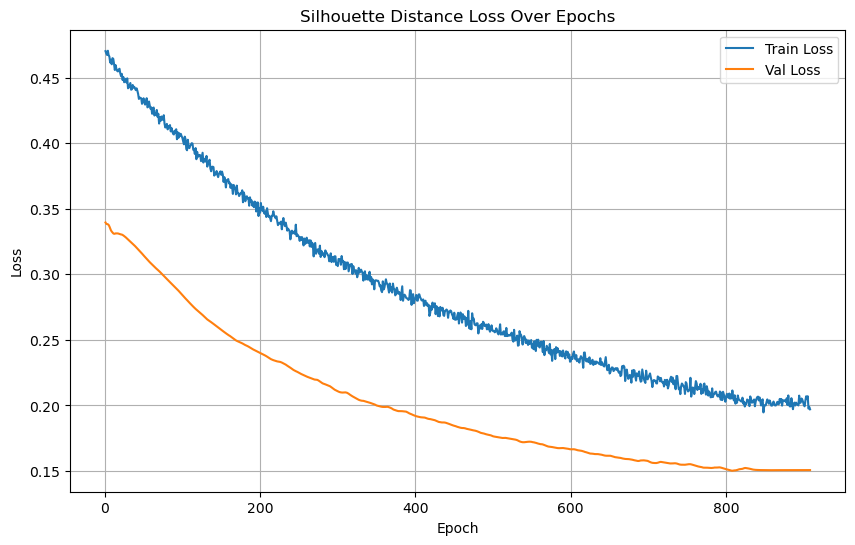

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/840], Loss: 0.0551
Test Batch [20/840], Loss: 0.1526
Test Batch [30/840], Loss: 0.1403
Test Batch [40/840], Loss: 0.5000
Test Batch [50/840], Loss: 0.1337
Test Batch [60/840], Loss: 0.1105
Test Batch [70/840], Loss: 0.1108
Test Batch [80/840], Loss: 0.5000


Test Batch [90/840], Loss: 0.1291
Test Batch [100/840], Loss: 0.2162
Test Batch [110/840], Loss: 0.5000
Test Batch [120/840], Loss: 0.1546
Test Batch [130/840], Loss: 0.1577
Test Batch [140/840], Loss: 0.1764
Test Batch [150/840], Loss: 0.1329
Test Batch [160/840], Loss: 0.2541


Test Batch [170/840], Loss: 0.1088
Test Batch [180/840], Loss: 0.1289
Test Batch [190/840], Loss: 0.1321
Test Batch [200/840], Loss: 0.0733
Test Batch [210/840], Loss: 0.0677


Test Batch [220/840], Loss: 0.0470
Test Batch [230/840], Loss: 0.0951
Test Batch [240/840], Loss: 0.0539
Test Batch [250/840], Loss: 0.0824


Test Batch [260/840], Loss: 0.2494
Test Batch [270/840], Loss: 0.2699
Test Batch [280/840], Loss: 0.3125
Test Batch [290/840], Loss: 0.1559
Test Batch [300/840], Loss: 0.2147


Test Batch [310/840], Loss: 0.2680
Test Batch [320/840], Loss: 0.1634
Test Batch [330/840], Loss: 0.2285
Test Batch [340/840], Loss: 0.1834
Test Batch [350/840], Loss: 0.5000
Test Batch [360/840], Loss: 0.5000
Test Batch [370/840], Loss: 0.5000
Test Batch [380/840], Loss: 0.5000


Test Batch [390/840], Loss: 0.5000
Test Batch [400/840], Loss: 0.5000
Test Batch [410/840], Loss: 0.5000
Test Batch [420/840], Loss: 0.5000
Test Batch [430/840], Loss: 0.0633
Test Batch [440/840], Loss: 0.1011
Test Batch [450/840], Loss: 0.1481
Test Batch [460/840], Loss: 0.0475
Test Batch [470/840], Loss: 0.0753


Test Batch [480/840], Loss: 0.0899
Test Batch [490/840], Loss: 0.5000
Test Batch [500/840], Loss: 0.0548
Test Batch [510/840], Loss: 0.0765
Test Batch [520/840], Loss: 0.0964
Test Batch [530/840], Loss: 0.5000


Test Batch [540/840], Loss: 0.1189
Test Batch [550/840], Loss: 0.1450
Test Batch [560/840], Loss: 0.1309
Test Batch [570/840], Loss: 0.1351
Test Batch [580/840], Loss: 0.1482


Test Batch [590/840], Loss: 0.0833
Test Batch [600/840], Loss: 0.1779
Test Batch [610/840], Loss: 0.1618
Test Batch [620/840], Loss: 0.0540
Test Batch [630/840], Loss: 0.1637


Test Batch [640/840], Loss: 0.0647
Test Batch [650/840], Loss: 0.2076
Test Batch [660/840], Loss: 0.4108
Test Batch [670/840], Loss: 0.0498
Test Batch [680/840], Loss: 0.0826


Test Batch [690/840], Loss: 0.3094
Test Batch [700/840], Loss: 0.2848
Test Batch [710/840], Loss: 0.0937
Test Batch [720/840], Loss: 0.1286
Test Batch [730/840], Loss: 0.0897


Test Batch [740/840], Loss: 0.1921
Test Batch [750/840], Loss: 0.0998
Test Batch [760/840], Loss: 0.5000
Test Batch [770/840], Loss: 0.1248
Test Batch [780/840], Loss: 0.5000
Test Batch [790/840], Loss: 0.2263


Test Batch [800/840], Loss: 0.0993
Test Batch [810/840], Loss: 0.5000
Test Batch [820/840], Loss: 0.1561
Test Batch [830/840], Loss: 0.5000
Test Batch [840/840], Loss: 0.1779

Test Loss: 0.2083


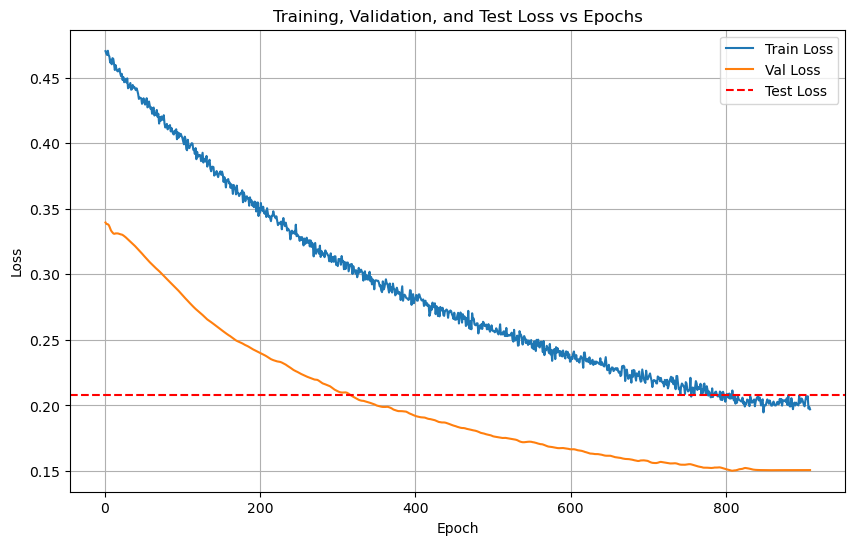

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/840 for test dataset.
  Processed batch 20/840 for test dataset.


  Processed batch 30/840 for test dataset.
  Processed batch 40/840 for test dataset.
  Processed batch 50/840 for test dataset.
  Processed batch 60/840 for test dataset.


  Processed batch 70/840 for test dataset.
  Processed batch 80/840 for test dataset.
  Processed batch 90/840 for test dataset.
  Processed batch 100/840 for test dataset.


  Processed batch 110/840 for test dataset.
  Processed batch 120/840 for test dataset.
  Processed batch 130/840 for test dataset.


  Processed batch 140/840 for test dataset.
  Processed batch 150/840 for test dataset.
  Processed batch 160/840 for test dataset.
  Processed batch 170/840 for test dataset.


  Processed batch 180/840 for test dataset.
  Processed batch 190/840 for test dataset.
  Processed batch 200/840 for test dataset.


  Processed batch 210/840 for test dataset.
  Processed batch 220/840 for test dataset.
  Processed batch 230/840 for test dataset.


  Processed batch 240/840 for test dataset.
  Processed batch 250/840 for test dataset.
  Processed batch 260/840 for test dataset.


  Processed batch 270/840 for test dataset.
  Processed batch 280/840 for test dataset.
  Processed batch 290/840 for test dataset.


  Processed batch 300/840 for test dataset.
  Processed batch 310/840 for test dataset.
  Processed batch 320/840 for test dataset.


  Processed batch 330/840 for test dataset.
  Processed batch 340/840 for test dataset.
  Processed batch 350/840 for test dataset.
  Processed batch 360/840 for test dataset.


  Processed batch 370/840 for test dataset.
  Processed batch 380/840 for test dataset.
  Processed batch 390/840 for test dataset.
  Processed batch 400/840 for test dataset.


  Processed batch 410/840 for test dataset.
  Processed batch 420/840 for test dataset.
  Processed batch 430/840 for test dataset.


  Processed batch 440/840 for test dataset.
  Processed batch 450/840 for test dataset.
  Processed batch 460/840 for test dataset.
  Processed batch 470/840 for test dataset.


  Processed batch 480/840 for test dataset.
  Processed batch 490/840 for test dataset.
  Processed batch 500/840 for test dataset.


  Processed batch 510/840 for test dataset.
  Processed batch 520/840 for test dataset.
  Processed batch 530/840 for test dataset.


  Processed batch 540/840 for test dataset.
  Processed batch 550/840 for test dataset.
  Processed batch 560/840 for test dataset.


  Processed batch 570/840 for test dataset.
  Processed batch 580/840 for test dataset.
  Processed batch 590/840 for test dataset.


  Processed batch 600/840 for test dataset.
  Processed batch 610/840 for test dataset.
  Processed batch 620/840 for test dataset.
  Processed batch 630/840 for test dataset.


  Processed batch 640/840 for test dataset.
  Processed batch 650/840 for test dataset.
  Processed batch 660/840 for test dataset.
  Processed batch 670/840 for test dataset.


  Processed batch 680/840 for test dataset.
  Processed batch 690/840 for test dataset.
  Processed batch 700/840 for test dataset.
  Processed batch 710/840 for test dataset.


  Processed batch 720/840 for test dataset.
  Processed batch 730/840 for test dataset.
  Processed batch 740/840 for test dataset.


  Processed batch 750/840 for test dataset.
  Processed batch 760/840 for test dataset.
  Processed batch 770/840 for test dataset.


  Processed batch 780/840 for test dataset.
  Processed batch 790/840 for test dataset.
  Processed batch 800/840 for test dataset.


  Processed batch 810/840 for test dataset.
  Processed batch 820/840 for test dataset.
  Processed batch 830/840 for test dataset.


  Processed batch 840/840 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9893  |  Val Loss: 2.9469
Validation loss improved from inf to 2.9469.
[Epoch 2/1000] Train Loss: 2.9201  |  Val Loss: 2.8867
Validation loss improved from 2.9469 to 2.8867.
[Epoch 3/1000] Train Loss: 2.8619  |  Val Loss: 2.8290
Validation loss improved from 2.8867 to 2.8290.
[Epoch 4/1000] Train Loss: 2.8030  |  Val Loss: 2.7753
Validation loss improved from 2.8290 to 2.7753.
[Epoch 5/1000] Train Loss: 2.7464  |  Val Loss: 2.7248
Validation loss improved from 2.7753 to 2.7248.
[Epoch 6/1000] Train Loss: 2.6955  |  Val Loss: 2.6756
Validation loss improved from 2.7248 to 2.6756.
[Epoch 7/1000] Train Loss: 2.6465  |  Val Loss: 2.6285
Validation loss improved from 2.6756 to 2.6285.
[Epoch 8/1000] Train Loss: 2.6001  |  Val Loss: 2.5865
Validation loss improved from 2.6285 to 2.5865.
[Epoch 9/1000] Train Loss: 2.5596  |  Val Loss: 2.5494
Validation loss improved from 2.5865 to 2.5494.
[Epoch 10/1000] Train Loss: 2.5221  |  Val Loss: 2.5162
Validation loss impr

[Epoch 15/1000] Train Loss: 2.3555  |  Val Loss: 2.3532
Validation loss improved from 2.3903 to 2.3532.
[Epoch 16/1000] Train Loss: 2.3160  |  Val Loss: 2.3158
Validation loss improved from 2.3532 to 2.3158.
[Epoch 17/1000] Train Loss: 2.2784  |  Val Loss: 2.2794
Validation loss improved from 2.3158 to 2.2794.
[Epoch 18/1000] Train Loss: 2.2426  |  Val Loss: 2.2445
Validation loss improved from 2.2794 to 2.2445.


[Epoch 19/1000] Train Loss: 2.2080  |  Val Loss: 2.2114
Validation loss improved from 2.2445 to 2.2114.
[Epoch 20/1000] Train Loss: 2.1757  |  Val Loss: 2.1793
Validation loss improved from 2.2114 to 2.1793.
[Epoch 21/1000] Train Loss: 2.1435  |  Val Loss: 2.1483
Validation loss improved from 2.1793 to 2.1483.
[Epoch 22/1000] Train Loss: 2.1128  |  Val Loss: 2.1180
Validation loss improved from 2.1483 to 2.1180.
[Epoch 23/1000] Train Loss: 2.0823  |  Val Loss: 2.0883
Validation loss improved from 2.1180 to 2.0883.
[Epoch 24/1000] Train Loss: 2.0515  |  Val Loss: 2.0598
Validation loss improved from 2.0883 to 2.0598.
[Epoch 25/1000] Train Loss: 2.0229  |  Val Loss: 2.0319
Validation loss improved from 2.0598 to 2.0319.
[Epoch 26/1000] Train Loss: 1.9951  |  Val Loss: 2.0041
Validation loss improved from 2.0319 to 2.0041.
[Epoch 27/1000] Train Loss: 1.9674  |  Val Loss: 1.9768
Validation loss improved from 2.0041 to 1.9768.
[Epoch 28/1000] Train Loss: 1.9397  |  Val Loss: 1.9506
Validati

[Epoch 35/1000] Train Loss: 1.7615  |  Val Loss: 1.7768
Validation loss improved from 1.8015 to 1.7768.
[Epoch 36/1000] Train Loss: 1.7363  |  Val Loss: 1.7523
Validation loss improved from 1.7768 to 1.7523.
[Epoch 37/1000] Train Loss: 1.7115  |  Val Loss: 1.7281
Validation loss improved from 1.7523 to 1.7281.
[Epoch 38/1000] Train Loss: 1.6874  |  Val Loss: 1.7043
Validation loss improved from 1.7281 to 1.7043.
[Epoch 39/1000] Train Loss: 1.6629  |  Val Loss: 1.6809
Validation loss improved from 1.7043 to 1.6809.
[Epoch 40/1000] Train Loss: 1.6390  |  Val Loss: 1.6576
Validation loss improved from 1.6809 to 1.6576.
[Epoch 41/1000] Train Loss: 1.6157  |  Val Loss: 1.6346
Validation loss improved from 1.6576 to 1.6346.
[Epoch 42/1000] Train Loss: 1.5918  |  Val Loss: 1.6116
Validation loss improved from 1.6346 to 1.6116.
[Epoch 43/1000] Train Loss: 1.5682  |  Val Loss: 1.5882
Validation loss improved from 1.6116 to 1.5882.
[Epoch 44/1000] Train Loss: 1.5448  |  Val Loss: 1.5646
Validati

[Epoch 54/1000] Train Loss: 1.3133  |  Val Loss: 1.3360
Validation loss improved from 1.3575 to 1.3360.
[Epoch 55/1000] Train Loss: 1.2914  |  Val Loss: 1.3140
Validation loss improved from 1.3360 to 1.3140.
[Epoch 56/1000] Train Loss: 1.2691  |  Val Loss: 1.2928
Validation loss improved from 1.3140 to 1.2928.
[Epoch 57/1000] Train Loss: 1.2477  |  Val Loss: 1.2716
Validation loss improved from 1.2928 to 1.2716.
[Epoch 58/1000] Train Loss: 1.2260  |  Val Loss: 1.2502
Validation loss improved from 1.2716 to 1.2502.
[Epoch 59/1000] Train Loss: 1.2048  |  Val Loss: 1.2285
Validation loss improved from 1.2502 to 1.2285.
[Epoch 60/1000] Train Loss: 1.1838  |  Val Loss: 1.2076
Validation loss improved from 1.2285 to 1.2076.
[Epoch 61/1000] Train Loss: 1.1619  |  Val Loss: 1.1870
Validation loss improved from 1.2076 to 1.1870.
[Epoch 62/1000] Train Loss: 1.1410  |  Val Loss: 1.1666
Validation loss improved from 1.1870 to 1.1666.
[Epoch 63/1000] Train Loss: 1.1199  |  Val Loss: 1.1461
Validati

[Epoch 73/1000] Train Loss: 0.9184  |  Val Loss: 0.9469
Validation loss improved from 0.9658 to 0.9469.
[Epoch 74/1000] Train Loss: 0.8991  |  Val Loss: 0.9282
Validation loss improved from 0.9469 to 0.9282.
[Epoch 75/1000] Train Loss: 0.8800  |  Val Loss: 0.9097
Validation loss improved from 0.9282 to 0.9097.
[Epoch 76/1000] Train Loss: 0.8613  |  Val Loss: 0.8918
Validation loss improved from 0.9097 to 0.8918.
[Epoch 77/1000] Train Loss: 0.8425  |  Val Loss: 0.8736
Validation loss improved from 0.8918 to 0.8736.
[Epoch 78/1000] Train Loss: 0.8245  |  Val Loss: 0.8562
Validation loss improved from 0.8736 to 0.8562.
[Epoch 79/1000] Train Loss: 0.8063  |  Val Loss: 0.8383
Validation loss improved from 0.8562 to 0.8383.
[Epoch 80/1000] Train Loss: 0.7885  |  Val Loss: 0.8208
Validation loss improved from 0.8383 to 0.8208.
[Epoch 81/1000] Train Loss: 0.7707  |  Val Loss: 0.8039
Validation loss improved from 0.8208 to 0.8039.
[Epoch 82/1000] Train Loss: 0.7532  |  Val Loss: 0.7868
Validati

[Epoch 93/1000] Train Loss: 0.5825  |  Val Loss: 0.6238
Validation loss improved from 0.6372 to 0.6238.
[Epoch 94/1000] Train Loss: 0.5691  |  Val Loss: 0.6107
Validation loss improved from 0.6238 to 0.6107.
[Epoch 95/1000] Train Loss: 0.5560  |  Val Loss: 0.5975
Validation loss improved from 0.6107 to 0.5975.
[Epoch 96/1000] Train Loss: 0.5428  |  Val Loss: 0.5850
Validation loss improved from 0.5975 to 0.5850.
[Epoch 97/1000] Train Loss: 0.5305  |  Val Loss: 0.5728
Validation loss improved from 0.5850 to 0.5728.
[Epoch 98/1000] Train Loss: 0.5182  |  Val Loss: 0.5605
Validation loss improved from 0.5728 to 0.5605.
[Epoch 99/1000] Train Loss: 0.5064  |  Val Loss: 0.5487
Validation loss improved from 0.5605 to 0.5487.
[Epoch 100/1000] Train Loss: 0.4949  |  Val Loss: 0.5374
Validation loss improved from 0.5487 to 0.5374.
[Epoch 101/1000] Train Loss: 0.4840  |  Val Loss: 0.5265
Validation loss improved from 0.5374 to 0.5265.
[Epoch 102/1000] Train Loss: 0.4733  |  Val Loss: 0.5156
Valid

[Epoch 112/1000] Train Loss: 0.3826  |  Val Loss: 0.4255
Validation loss improved from 0.4333 to 0.4255.
[Epoch 113/1000] Train Loss: 0.3752  |  Val Loss: 0.4177
Validation loss improved from 0.4255 to 0.4177.
[Epoch 114/1000] Train Loss: 0.3679  |  Val Loss: 0.4102
Validation loss improved from 0.4177 to 0.4102.
[Epoch 115/1000] Train Loss: 0.3609  |  Val Loss: 0.4033
Validation loss improved from 0.4102 to 0.4033.
[Epoch 116/1000] Train Loss: 0.3539  |  Val Loss: 0.3963
Validation loss improved from 0.4033 to 0.3963.
[Epoch 117/1000] Train Loss: 0.3471  |  Val Loss: 0.3900
Validation loss improved from 0.3963 to 0.3900.
[Epoch 118/1000] Train Loss: 0.3409  |  Val Loss: 0.3835
Validation loss improved from 0.3900 to 0.3835.
[Epoch 119/1000] Train Loss: 0.3347  |  Val Loss: 0.3773
Validation loss improved from 0.3835 to 0.3773.
[Epoch 120/1000] Train Loss: 0.3288  |  Val Loss: 0.3714
Validation loss improved from 0.3773 to 0.3714.
[Epoch 121/1000] Train Loss: 0.3229  |  Val Loss: 0.365

[Epoch 131/1000] Train Loss: 0.2739  |  Val Loss: 0.3172
Validation loss improved from 0.3213 to 0.3172.
[Epoch 132/1000] Train Loss: 0.2700  |  Val Loss: 0.3133
Validation loss improved from 0.3172 to 0.3133.
[Epoch 133/1000] Train Loss: 0.2659  |  Val Loss: 0.3094
Validation loss improved from 0.3133 to 0.3094.
[Epoch 134/1000] Train Loss: 0.2622  |  Val Loss: 0.3054
Validation loss improved from 0.3094 to 0.3054.
[Epoch 135/1000] Train Loss: 0.2584  |  Val Loss: 0.3016
Validation loss improved from 0.3054 to 0.3016.
[Epoch 136/1000] Train Loss: 0.2547  |  Val Loss: 0.2978
Validation loss improved from 0.3016 to 0.2978.
[Epoch 137/1000] Train Loss: 0.2512  |  Val Loss: 0.2940
Validation loss improved from 0.2978 to 0.2940.
[Epoch 138/1000] Train Loss: 0.2479  |  Val Loss: 0.2905
Validation loss improved from 0.2940 to 0.2905.
[Epoch 139/1000] Train Loss: 0.2444  |  Val Loss: 0.2874
Validation loss improved from 0.2905 to 0.2874.
[Epoch 140/1000] Train Loss: 0.2412  |  Val Loss: 0.284

[Epoch 149/1000] Train Loss: 0.2155  |  Val Loss: 0.2586
Validation loss improved from 0.2610 to 0.2586.
[Epoch 150/1000] Train Loss: 0.2131  |  Val Loss: 0.2563
Validation loss improved from 0.2586 to 0.2563.
[Epoch 151/1000] Train Loss: 0.2105  |  Val Loss: 0.2535
Validation loss improved from 0.2563 to 0.2535.
[Epoch 152/1000] Train Loss: 0.2082  |  Val Loss: 0.2508
Validation loss improved from 0.2535 to 0.2508.
[Epoch 153/1000] Train Loss: 0.2058  |  Val Loss: 0.2486
Validation loss improved from 0.2508 to 0.2486.
[Epoch 154/1000] Train Loss: 0.2038  |  Val Loss: 0.2465
Validation loss improved from 0.2486 to 0.2465.
[Epoch 155/1000] Train Loss: 0.2014  |  Val Loss: 0.2444
Validation loss improved from 0.2465 to 0.2444.
[Epoch 156/1000] Train Loss: 0.1993  |  Val Loss: 0.2421
Validation loss improved from 0.2444 to 0.2421.
[Epoch 157/1000] Train Loss: 0.1972  |  Val Loss: 0.2400
Validation loss improved from 0.2421 to 0.2400.
[Epoch 158/1000] Train Loss: 0.1952  |  Val Loss: 0.237

[Epoch 168/1000] Train Loss: 0.1773  |  Val Loss: 0.2195
Validation loss improved from 0.2212 to 0.2195.
[Epoch 169/1000] Train Loss: 0.1758  |  Val Loss: 0.2183
Validation loss improved from 0.2195 to 0.2183.
[Epoch 170/1000] Train Loss: 0.1740  |  Val Loss: 0.2166
Validation loss improved from 0.2183 to 0.2166.
[Epoch 171/1000] Train Loss: 0.1726  |  Val Loss: 0.2150
Validation loss improved from 0.2166 to 0.2150.
[Epoch 172/1000] Train Loss: 0.1712  |  Val Loss: 0.2134
Validation loss improved from 0.2150 to 0.2134.
[Epoch 173/1000] Train Loss: 0.1695  |  Val Loss: 0.2120
Validation loss improved from 0.2134 to 0.2120.
[Epoch 174/1000] Train Loss: 0.1682  |  Val Loss: 0.2107
Validation loss improved from 0.2120 to 0.2107.
[Epoch 175/1000] Train Loss: 0.1667  |  Val Loss: 0.2096
Validation loss improved from 0.2107 to 0.2096.
[Epoch 176/1000] Train Loss: 0.1653  |  Val Loss: 0.2084
Validation loss improved from 0.2096 to 0.2084.
[Epoch 177/1000] Train Loss: 0.1640  |  Val Loss: 0.207

[Epoch 187/1000] Train Loss: 0.1517  |  Val Loss: 0.1947
Validation loss improved from 0.1958 to 0.1947.
[Epoch 188/1000] Train Loss: 0.1507  |  Val Loss: 0.1938
Validation loss improved from 0.1947 to 0.1938.
[Epoch 189/1000] Train Loss: 0.1495  |  Val Loss: 0.1925
Validation loss improved from 0.1938 to 0.1925.
[Epoch 190/1000] Train Loss: 0.1485  |  Val Loss: 0.1913
Validation loss improved from 0.1925 to 0.1913.
[Epoch 191/1000] Train Loss: 0.1474  |  Val Loss: 0.1903
Validation loss improved from 0.1913 to 0.1903.
[Epoch 192/1000] Train Loss: 0.1463  |  Val Loss: 0.1895
Validation loss improved from 0.1903 to 0.1895.
[Epoch 193/1000] Train Loss: 0.1453  |  Val Loss: 0.1889
Validation loss improved from 0.1895 to 0.1889.
[Epoch 194/1000] Train Loss: 0.1443  |  Val Loss: 0.1878
Validation loss improved from 0.1889 to 0.1878.
[Epoch 195/1000] Train Loss: 0.1431  |  Val Loss: 0.1871
Validation loss improved from 0.1878 to 0.1871.
[Epoch 196/1000] Train Loss: 0.1424  |  Val Loss: 0.186

[Epoch 205/1000] Train Loss: 0.1340  |  Val Loss: 0.1787
Validation loss improved from 0.1798 to 0.1787.
[Epoch 206/1000] Train Loss: 0.1332  |  Val Loss: 0.1782
Validation loss improved from 0.1787 to 0.1782.
[Epoch 207/1000] Train Loss: 0.1321  |  Val Loss: 0.1776
Validation loss improved from 0.1782 to 0.1776.
[Epoch 208/1000] Train Loss: 0.1316  |  Val Loss: 0.1767
Validation loss improved from 0.1776 to 0.1767.
[Epoch 209/1000] Train Loss: 0.1307  |  Val Loss: 0.1762
Validation loss improved from 0.1767 to 0.1762.
[Epoch 210/1000] Train Loss: 0.1299  |  Val Loss: 0.1755
Validation loss improved from 0.1762 to 0.1755.
[Epoch 211/1000] Train Loss: 0.1290  |  Val Loss: 0.1747
Validation loss improved from 0.1755 to 0.1747.
[Epoch 212/1000] Train Loss: 0.1284  |  Val Loss: 0.1740
Validation loss improved from 0.1747 to 0.1740.
[Epoch 213/1000] Train Loss: 0.1275  |  Val Loss: 0.1738
Validation loss improved from 0.1740 to 0.1738.
[Epoch 214/1000] Train Loss: 0.1266  |  Val Loss: 0.173

[Epoch 223/1000] Train Loss: 0.1201  |  Val Loss: 0.1677
Validation loss improved from 0.1683 to 0.1677.
[Epoch 224/1000] Train Loss: 0.1195  |  Val Loss: 0.1672
Validation loss improved from 0.1677 to 0.1672.
[Epoch 225/1000] Train Loss: 0.1189  |  Val Loss: 0.1667
Validation loss improved from 0.1672 to 0.1667.
[Epoch 226/1000] Train Loss: 0.1182  |  Val Loss: 0.1664
Validation loss improved from 0.1667 to 0.1664.
[Epoch 227/1000] Train Loss: 0.1175  |  Val Loss: 0.1660
Validation loss improved from 0.1664 to 0.1660.
[Epoch 228/1000] Train Loss: 0.1170  |  Val Loss: 0.1655
Validation loss improved from 0.1660 to 0.1655.
[Epoch 229/1000] Train Loss: 0.1162  |  Val Loss: 0.1650
Validation loss improved from 0.1655 to 0.1650.
[Epoch 230/1000] Train Loss: 0.1156  |  Val Loss: 0.1644
Validation loss improved from 0.1650 to 0.1644.
[Epoch 231/1000] Train Loss: 0.1149  |  Val Loss: 0.1640
Validation loss improved from 0.1644 to 0.1640.
[Epoch 232/1000] Train Loss: 0.1142  |  Val Loss: 0.163

[Epoch 242/1000] Train Loss: 0.1084  |  Val Loss: 0.1605
Validation loss improved from 0.1608 to 0.1605.
[Epoch 243/1000] Train Loss: 0.1079  |  Val Loss: 0.1599
Validation loss improved from 0.1605 to 0.1599.
[Epoch 244/1000] Train Loss: 0.1072  |  Val Loss: 0.1595
Validation loss improved from 0.1599 to 0.1595.
[Epoch 245/1000] Train Loss: 0.1067  |  Val Loss: 0.1592
Validation loss improved from 0.1595 to 0.1592.
[Epoch 246/1000] Train Loss: 0.1061  |  Val Loss: 0.1587
Validation loss improved from 0.1592 to 0.1587.
[Epoch 247/1000] Train Loss: 0.1058  |  Val Loss: 0.1584
Validation loss improved from 0.1587 to 0.1584.
[Epoch 248/1000] Train Loss: 0.1051  |  Val Loss: 0.1582
Validation loss improved from 0.1584 to 0.1582.
[Epoch 249/1000] Train Loss: 0.1049  |  Val Loss: 0.1578
Validation loss improved from 0.1582 to 0.1578.
[Epoch 250/1000] Train Loss: 0.1041  |  Val Loss: 0.1576
Validation loss improved from 0.1578 to 0.1576.
[Epoch 251/1000] Train Loss: 0.1039  |  Val Loss: 0.157

[Epoch 262/1000] Train Loss: 0.0984  |  Val Loss: 0.1547
Validation loss improved from 0.1551 to 0.1547.
[Epoch 263/1000] Train Loss: 0.0978  |  Val Loss: 0.1543
Validation loss improved from 0.1547 to 0.1543.
[Epoch 264/1000] Train Loss: 0.0975  |  Val Loss: 0.1540
Validation loss improved from 0.1543 to 0.1540.
[Epoch 265/1000] Train Loss: 0.0970  |  Val Loss: 0.1538
Validation loss improved from 0.1540 to 0.1538.
[Epoch 266/1000] Train Loss: 0.0967  |  Val Loss: 0.1539
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 267/1000] Train Loss: 0.0961  |  Val Loss: 0.1537
Validation loss improved from 0.1538 to 0.1537.
[Epoch 268/1000] Train Loss: 0.0957  |  Val Loss: 0.1534
Validation loss improved from 0.1537 to 0.1534.
[Epoch 269/1000] Train Loss: 0.0953  |  Val Loss: 0.1534
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 0.0948  |  Val Loss: 0.1530
Validation loss improved from 0.1534 to 0.1530.
[Epoch 271/1000] Train Loss: 0.0943  |  Val

[Epoch 281/1000] Train Loss: 0.0905  |  Val Loss: 0.1513
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 282/1000] Train Loss: 0.0900  |  Val Loss: 0.1509
Validation loss improved from 0.1512 to 0.1509.
[Epoch 283/1000] Train Loss: 0.0897  |  Val Loss: 0.1505
Validation loss improved from 0.1509 to 0.1505.
[Epoch 284/1000] Train Loss: 0.0892  |  Val Loss: 0.1505
Validation loss improved from 0.1505 to 0.1505.
[Epoch 285/1000] Train Loss: 0.0890  |  Val Loss: 0.1504
Validation loss improved from 0.1505 to 0.1504.
[Epoch 286/1000] Train Loss: 0.0886  |  Val Loss: 0.1506
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 287/1000] Train Loss: 0.0881  |  Val Loss: 0.1504
Validation loss improved from 0.1504 to 0.1504.
[Epoch 288/1000] Train Loss: 0.0878  |  Val Loss: 0.1503
Validation loss improved from 0.1504 to 0.1503.
[Epoch 289/1000] Train Loss: 0.0873  |  Val Loss: 0.1501
Validation loss improved from 0.1503 to 0.1501.
[Epoch 290/1000] Train Loss: 0.0870  |  Val

[Epoch 301/1000] Train Loss: 0.0834  |  Val Loss: 0.1487
Validation loss improved from 0.1488 to 0.1487.
[Epoch 302/1000] Train Loss: 0.0829  |  Val Loss: 0.1482
Validation loss improved from 0.1487 to 0.1482.
[Epoch 303/1000] Train Loss: 0.0828  |  Val Loss: 0.1483
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 304/1000] Train Loss: 0.0821  |  Val Loss: 0.1483
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 305/1000] Train Loss: 0.0819  |  Val Loss: 0.1482
Validation loss improved from 0.1482 to 0.1482.
[Epoch 306/1000] Train Loss: 0.0814  |  Val Loss: 0.1479
Validation loss improved from 0.1482 to 0.1479.
[Epoch 307/1000] Train Loss: 0.0812  |  Val Loss: 0.1477
Validation loss improved from 0.1479 to 0.1477.
[Epoch 308/1000] Train Loss: 0.0808  |  Val Loss: 0.1476
Validation loss improved from 0.1477 to 0.1476.
[Epoch 309/1000] Train Loss: 0.0804  |  Val Loss: 0.1475
Validation loss improved from 0.1476 to 0.1475.
[Epoch 310/1000] Train Loss: 0.0802  |  Val

[Epoch 319/1000] Train Loss: 0.0774  |  Val Loss: 0.1473
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 320/1000] Train Loss: 0.0769  |  Val Loss: 0.1471
Validation loss improved from 0.1472 to 0.1471.
[Epoch 321/1000] Train Loss: 0.0768  |  Val Loss: 0.1471
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 0.0764  |  Val Loss: 0.1473
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 0.0762  |  Val Loss: 0.1474
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 0.0760  |  Val Loss: 0.1472
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 0.0756  |  Val Loss: 0.1470
Validation loss improved from 0.1471 to 0.1470.
[Epoch 326/1000] Train Loss: 0.0753  |  Val Loss: 0.1469
Validation loss improved from 0.1470 to 0.1469.
[Epoch 327/1000] Train Loss: 0.0751  |  Val Loss: 0.1474
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 328/1000] Tr

[Epoch 338/1000] Train Loss: 0.0719  |  Val Loss: 0.1470
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 339/1000] Train Loss: 0.0715  |  Val Loss: 0.1469
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 340/1000] Train Loss: 0.0713  |  Val Loss: 0.1470
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 341/1000] Train Loss: 0.0712  |  Val Loss: 0.1470
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 342/1000] Train Loss: 0.0710  |  Val Loss: 0.1467
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 343/1000] Train Loss: 0.0708  |  Val Loss: 0.1464
Validation loss improved from 0.1466 to 0.1464.
[Epoch 344/1000] Train Loss: 0.0703  |  Val Loss: 0.1467
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 345/1000] Train Loss: 0.0702  |  Val Loss: 0.1468
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 346/1000] Train Loss: 0.0704  |  Val Loss: 0.1468
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 358/1000] Train Loss: 0.0667  |  Val Loss: 0.1472
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 359/1000] Train Loss: 0.0667  |  Val Loss: 0.1474
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 360/1000] Train Loss: 0.0667  |  Val Loss: 0.1471
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 361/1000] Train Loss: 0.0661  |  Val Loss: 0.1473
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 362/1000] Train Loss: 0.0659  |  Val Loss: 0.1474
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 363/1000] Train Loss: 0.0656  |  Val Loss: 0.1471
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 364/1000] Train Loss: 0.0655  |  Val Loss: 0.1471
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 365/1000] Train Loss: 0.0652  |  Val Loss: 0.1472
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 366/1000] Train Loss: 0.0653  |  Val Loss: 0.1477
!! Validation loss did NOT improve !! Patience:

[Epoch 377/1000] Train Loss: 0.0626  |  Val Loss: 0.1480
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 378/1000] Train Loss: 0.0623  |  Val Loss: 0.1482
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 379/1000] Train Loss: 0.0620  |  Val Loss: 0.1479
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 380/1000] Train Loss: 0.0619  |  Val Loss: 0.1480
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 381/1000] Train Loss: 0.0617  |  Val Loss: 0.1484
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 382/1000] Train Loss: 0.0618  |  Val Loss: 0.1485
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 383/1000] Train Loss: 0.0613  |  Val Loss: 0.1487
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 384/1000] Train Loss: 0.0612  |  Val Loss: 0.1486
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 385/1000] Train Loss: 0.0608  |  Val Loss: 0.1485
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.0586  |  Val Loss: 0.1497
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 397/1000] Train Loss: 0.0585  |  Val Loss: 0.1495
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 398/1000] Train Loss: 0.0586  |  Val Loss: 0.1497
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 399/1000] Train Loss: 0.0582  |  Val Loss: 0.1499
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 400/1000] Train Loss: 0.0578  |  Val Loss: 0.1498
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 401/1000] Train Loss: 0.0576  |  Val Loss: 0.1501
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 402/1000] Train Loss: 0.0574  |  Val Loss: 0.1503
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 403/1000] Train Loss: 0.0574  |  Val Loss: 0.1505
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 404/1000] Train Loss: 0.0574  |  Val Loss: 0.1505
!! Validation loss did NOT improve !! Patience:

[Epoch 413/1000] Train Loss: 0.0554  |  Val Loss: 0.1517
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 414/1000] Train Loss: 0.0553  |  Val Loss: 0.1519
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 415/1000] Train Loss: 0.0552  |  Val Loss: 0.1521
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 416/1000] Train Loss: 0.0554  |  Val Loss: 0.1523
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 417/1000] Train Loss: 0.0547  |  Val Loss: 0.1524
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 418/1000] Train Loss: 0.0546  |  Val Loss: 0.1522
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 419/1000] Train Loss: 0.0545  |  Val Loss: 0.1524
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 420/1000] Train Loss: 0.0543  |  Val Loss: 0.1528
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 421/1000] Train Loss: 0.0542  |  Val Loss: 0.1532
!! Validation loss did NOT improve !! Patience:

[Epoch 431/1000] Train Loss: 0.0523  |  Val Loss: 0.1542
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 432/1000] Train Loss: 0.0522  |  Val Loss: 0.1547
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 433/1000] Train Loss: 0.0524  |  Val Loss: 0.1545
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 434/1000] Train Loss: 0.0522  |  Val Loss: 0.1547
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 435/1000] Train Loss: 0.0517  |  Val Loss: 0.1541
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 436/1000] Train Loss: 0.0517  |  Val Loss: 0.1541
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 437/1000] Train Loss: 0.0516  |  Val Loss: 0.1550
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 438/1000] Train Loss: 0.0515  |  Val Loss: 0.1550
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 439/1000] Train Loss: 0.0512  |  Val Loss: 0.1555
!! Validation loss did NOT improve !! Patience:

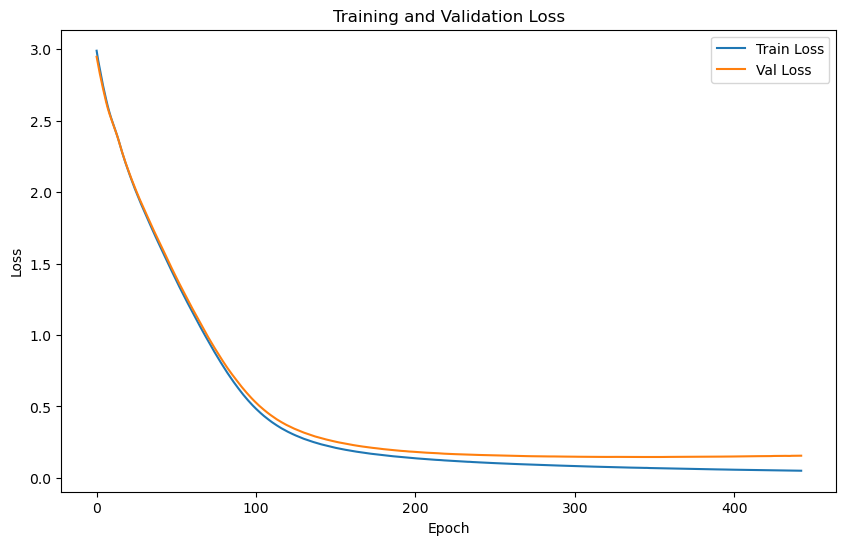

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7645 | Test Accuracy: 84.16%


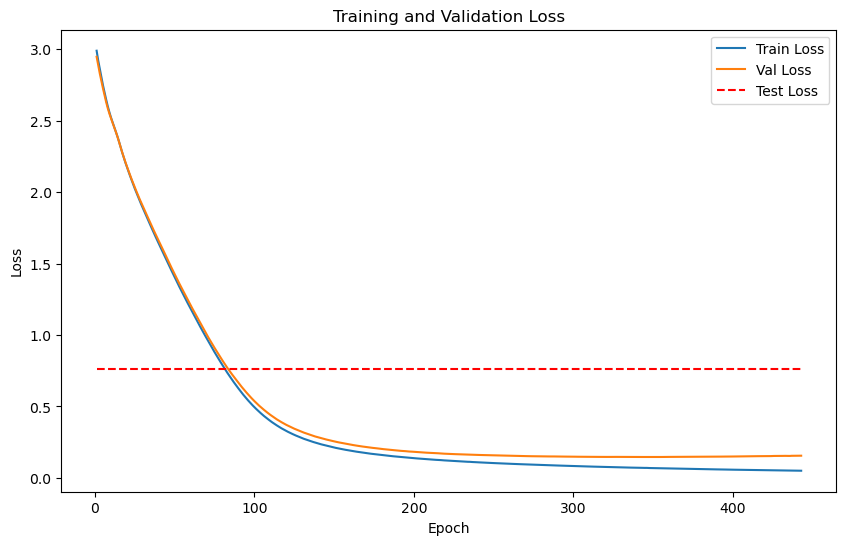

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


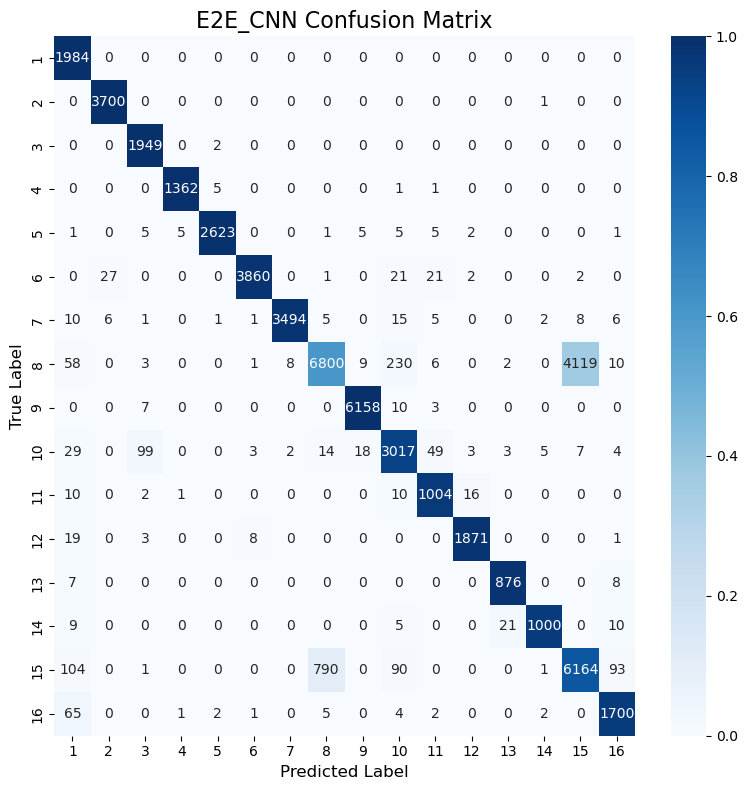

Classification Accuracy: 88.52%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


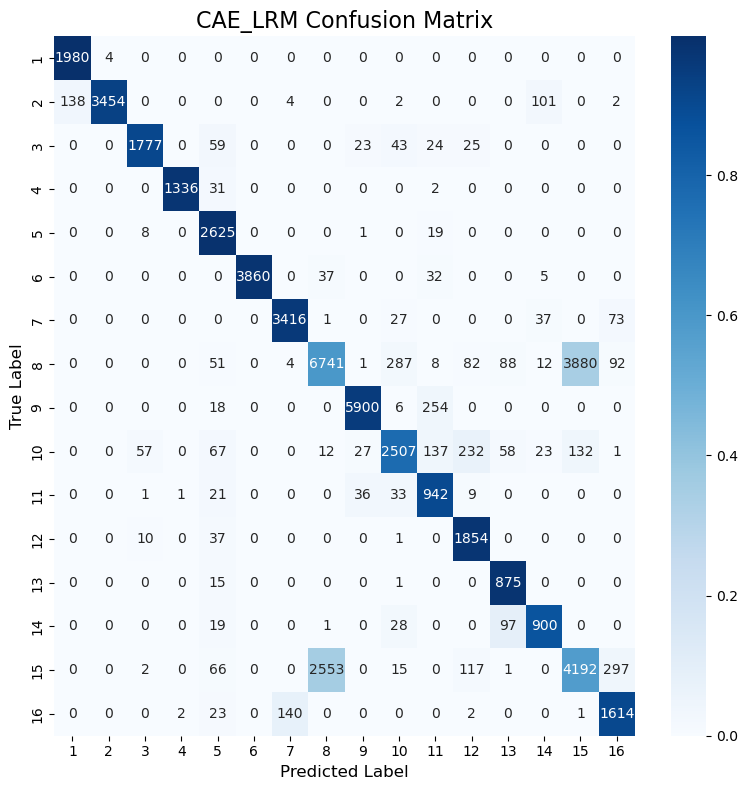

Classification Accuracy: 81.84%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


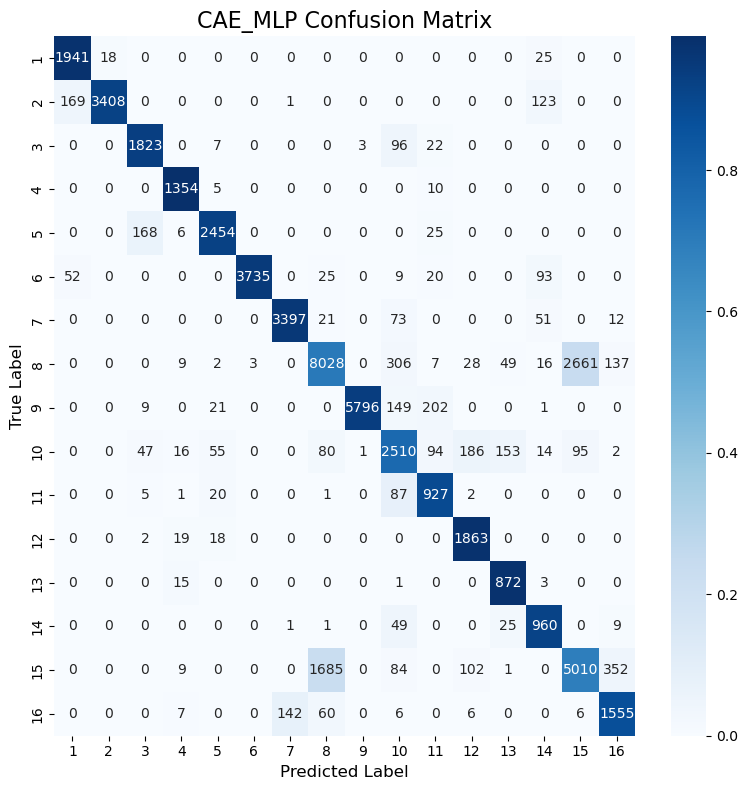

Classification Accuracy: 84.93%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


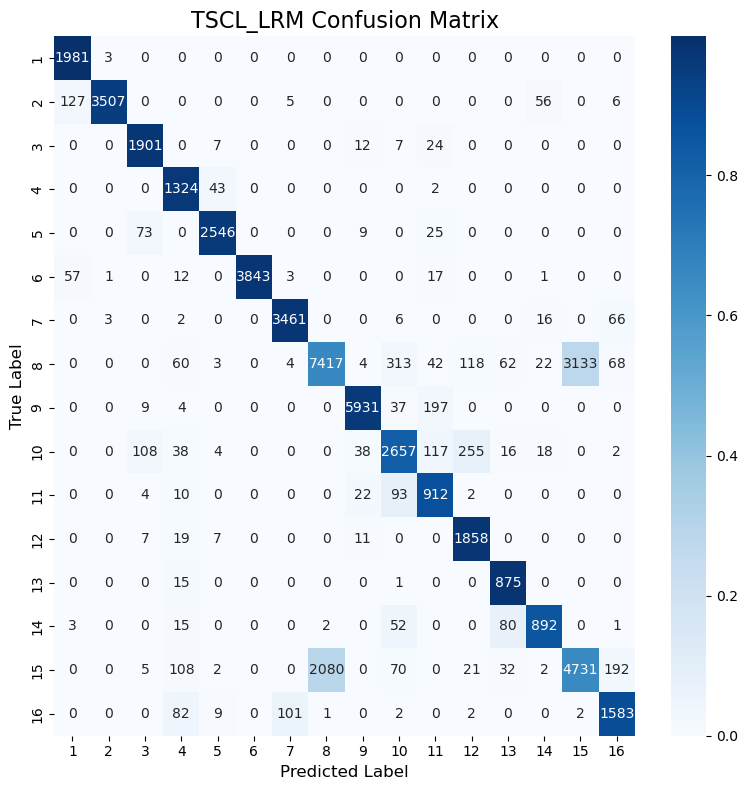

Classification Accuracy: 84.53%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


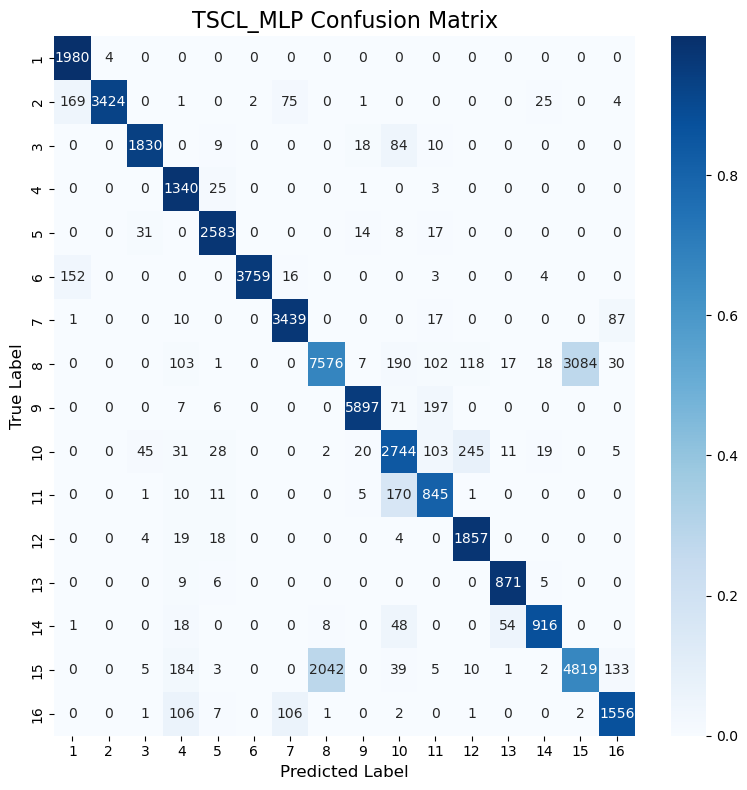

Classification Accuracy: 84.57%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


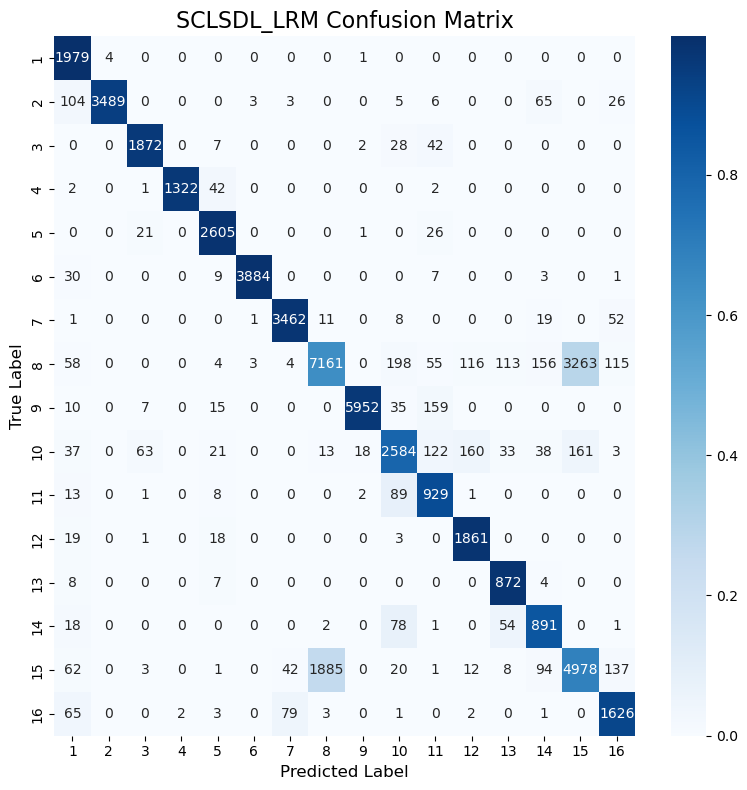

Classification Accuracy: 84.62%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


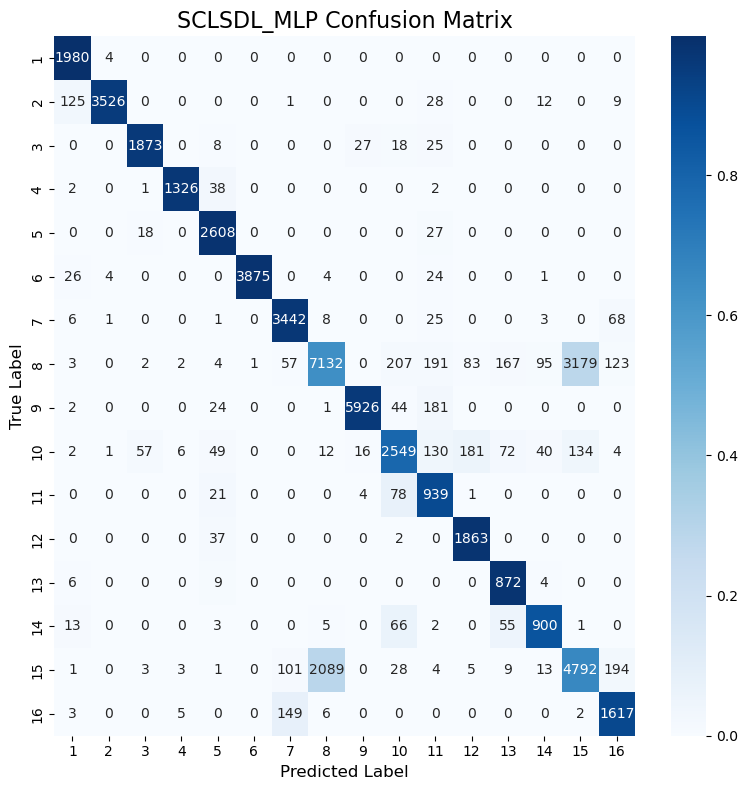

Classification Accuracy: 84.16%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          88.52
1    LRM (CAE)          81.84
2    MLP (CAE)          84.93
3     TSCL LRM          84.53
4     TSCL MLP          84.57
5  SCL_SDL LRM          84.62
6  SCL_SDL MLP          84.16

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          88.52
2    MLP (CAE)          84.93
5  SCL_SDL LRM          84.62
4     TSCL MLP          84.57
3     TSCL LRM          84.53
6  SCL_SDL MLP          84.16
1    LRM (CAE)          81.84
